# Setup

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import re
import plotly.express as px
import plotly.io as pio


## Global Settings

In [ ]:
sns.set_theme(palette='husl', rc={"figure.dpi": 200})
pd.set_option('display.max_columns', 50, 'display.width', 200)
pio.renderers.default = "browser"


# Data Processing

## Load Data

In [ ]:
df = pd.read_csv('input/datasets/Unicorns_Completed (2024).csv')
df_wiki = pd.read_csv('input/raw_data/list-of-unicorn-startups_20250619 (wikipedia).csv')


## Data Cleaning

In [ ]:
def clean_years_to_unicorn_labels(s):
    m = re.match(r'(\d+)y?\s?(\d+)m?o?', s)
    return f'{m[1]}y{m[2]}m' if m else s
df['Years to Unicorn'] = df['Years to Unicorn'].apply(clean_years_to_unicorn_labels)

def correct_industry_labels(s):
    if s == 'Health':
        return 'Healthcare & Life Sciences'
    if s == 'West Palm Beach':
        return 'Enterprise Tech'
    return s
df['Industry'] = df['Industry'].apply(correct_industry_labels)

def correct_company_names(s):
    if s == 'Scale':
        return 'Scale AI'
    return s
df['Company'] = df['Company'].apply(correct_company_names)

# Remove duplicates
df = df[~df.duplicated(['Company'])]


## Data Preparation

### Column Types

In [ ]:
df['Unicorn Date'] = pd.to_datetime(df['Unicorn Date'])
df['Valuation ($B)'] = pd.to_numeric(df['Valuation ($B)'])
df['Valuation ($)'] = df['Valuation ($B)'] * 1e9
df['Unicorn Year'] = df['Unicorn Date'].dt.year
df['Funding ($B)'] = df['Total Equity Funding ($)'] / 1e9
df['Funding ($M)'] = df['Total Equity Funding ($)'] / 1e6
df['Investors'] = df['Select Investors'].str.split(', ')


### Time to Unicorn

In [ ]:
def convert_years_to_months(years_str):
    if 'y' in years_str and 'm' in years_str:
        years, months = years_str.split('y')
        months = months.replace('m', '').strip()
        return int(years.strip()) * 12 + int(months)
    elif 'y' in years_str:
        years = years_str.replace('y', '').strip()
        return int(years) * 12
    elif 'm' in years_str:
        months = years_str.replace('mo', '').replace('m', '').strip()
        return int(months)
    else:
        return None
df['Months to Unicorn'] = df['Years to Unicorn'].apply(convert_years_to_months)
df['Years to Unicorn'] = df['Months to Unicorn'] / 12


### Merge datasets

-   Scraped data from Wikepedia (Latest Valuations, Sectors and
    Founders)

    ``` python
    df_wiki.rename(columns={'Valuation (US$ billions)': 'Latest Valuation ($B)',
                            'Industry': 'Sector'},
                   inplace=True)
    df_wiki = df_wiki.drop_duplicates('Company')
    df_wiki['Company'] = df_wiki['Company'].str.strip()
    df_wiki['Founder(s)'] = df_wiki['Founder(s)'].str.replace(' and ', ', ').str.split(', ')
    def list_of_sectors(s):
        sectors = s.replace(' and ', ', ').split(', ')
        return list(map(lambda x: x.strip().title(), sectors))
    df_wiki['Sector'] = df_wiki['Sector'].dropna().apply(list_of_sectors)
    df_wiki = df_wiki.assign(tmp_col=lambda x: x.Company.str.lower()) # Create a tmp col for Company matching
    df = df.assign(tmp_col=lambda x: x.Company.str.lower())\
           .merge(df_wiki[['tmp_col', 'Latest Valuation ($B)', 'Sector', 'Founder(s)']], on='tmp_col', how='left')\
           .drop(['tmp_col'], axis=1)
    df['Latest Valuation ($B)'] = pd.to_numeric(df['Latest Valuation ($B)'].fillna(value=df['Valuation ($B)']))
    # Determine unicorn type based on latest valuations
    df['Unicorn Type'] = pd.cut(df['Latest Valuation ($B)'],
                                labels=['Unicorn', 'Decacorn', 'Centicorn'],
                                bins=[0, 10, 100, df['Latest Valuation ($B)'].max()])
    ```

## Preview

In [ ]:
df.info()


``` example
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Company                   1240 non-null   object
 1   Valuation ($B)            1240 non-null   float64
 2   Total Equity Funding ($)  1240 non-null   int64
 3   Unicorn Date              1240 non-null   datetime64[ns]
 4   Date Founded              1240 non-null   int64
 5   Years to Unicorn          1240 non-null   float64
 6   Industry                  1240 non-null   object
 7   Country                   1240 non-null   object
 8   City                      1240 non-null   object
 9   Select Investors          1240 non-null   object
 10  Valuation ($)             1240 non-null   float64
 11  Unicorn Year              1240 non-null   int32
 12  Funding ($B)              1240 non-null   float64
 13  Funding ($M)              1240 non-null   float64
 14  Investors                 1240 non-null   object
 15  Months to Unicorn         1240 non-null   int64
 16  Latest Valuation ($B)     1240 non-null   float64
 17  Sector                    427 non-null    object
 18  Founder(s)                137 non-null    object
 19  Unicorn Type              1240 non-null   category
dtypes: category(1), datetime64[ns](1), float64(6), int32(1), int64(3), object(8)
memory usage: 180.7+ KB
```

# Exploratory Data Analysis

## Industry-Based Analysis

### Distribution of Companies across Different Industries

In [ ]:
_df = df.groupby('Industry').size()
_df


``` example
Industry
Consumer & Retail             201
Enterprise Tech               404
Financial Services            225
Healthcare & Life Sciences    118
Industrials                   183
Insurance                      25
Media & Entertainment          84
dtype: int64
```

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), constrained_layout=True)
total = _df.sum()
_df.plot.pie(legend=True, labels=None,
             autopct=lambda pct:f"{round(total*pct/100)}\n({pct:.1f}%)",
             wedgeprops=dict(width=0.7, edgecolor='w'))
plt.suptitle('Distribution of Companies across Different Industries')
plt.show()


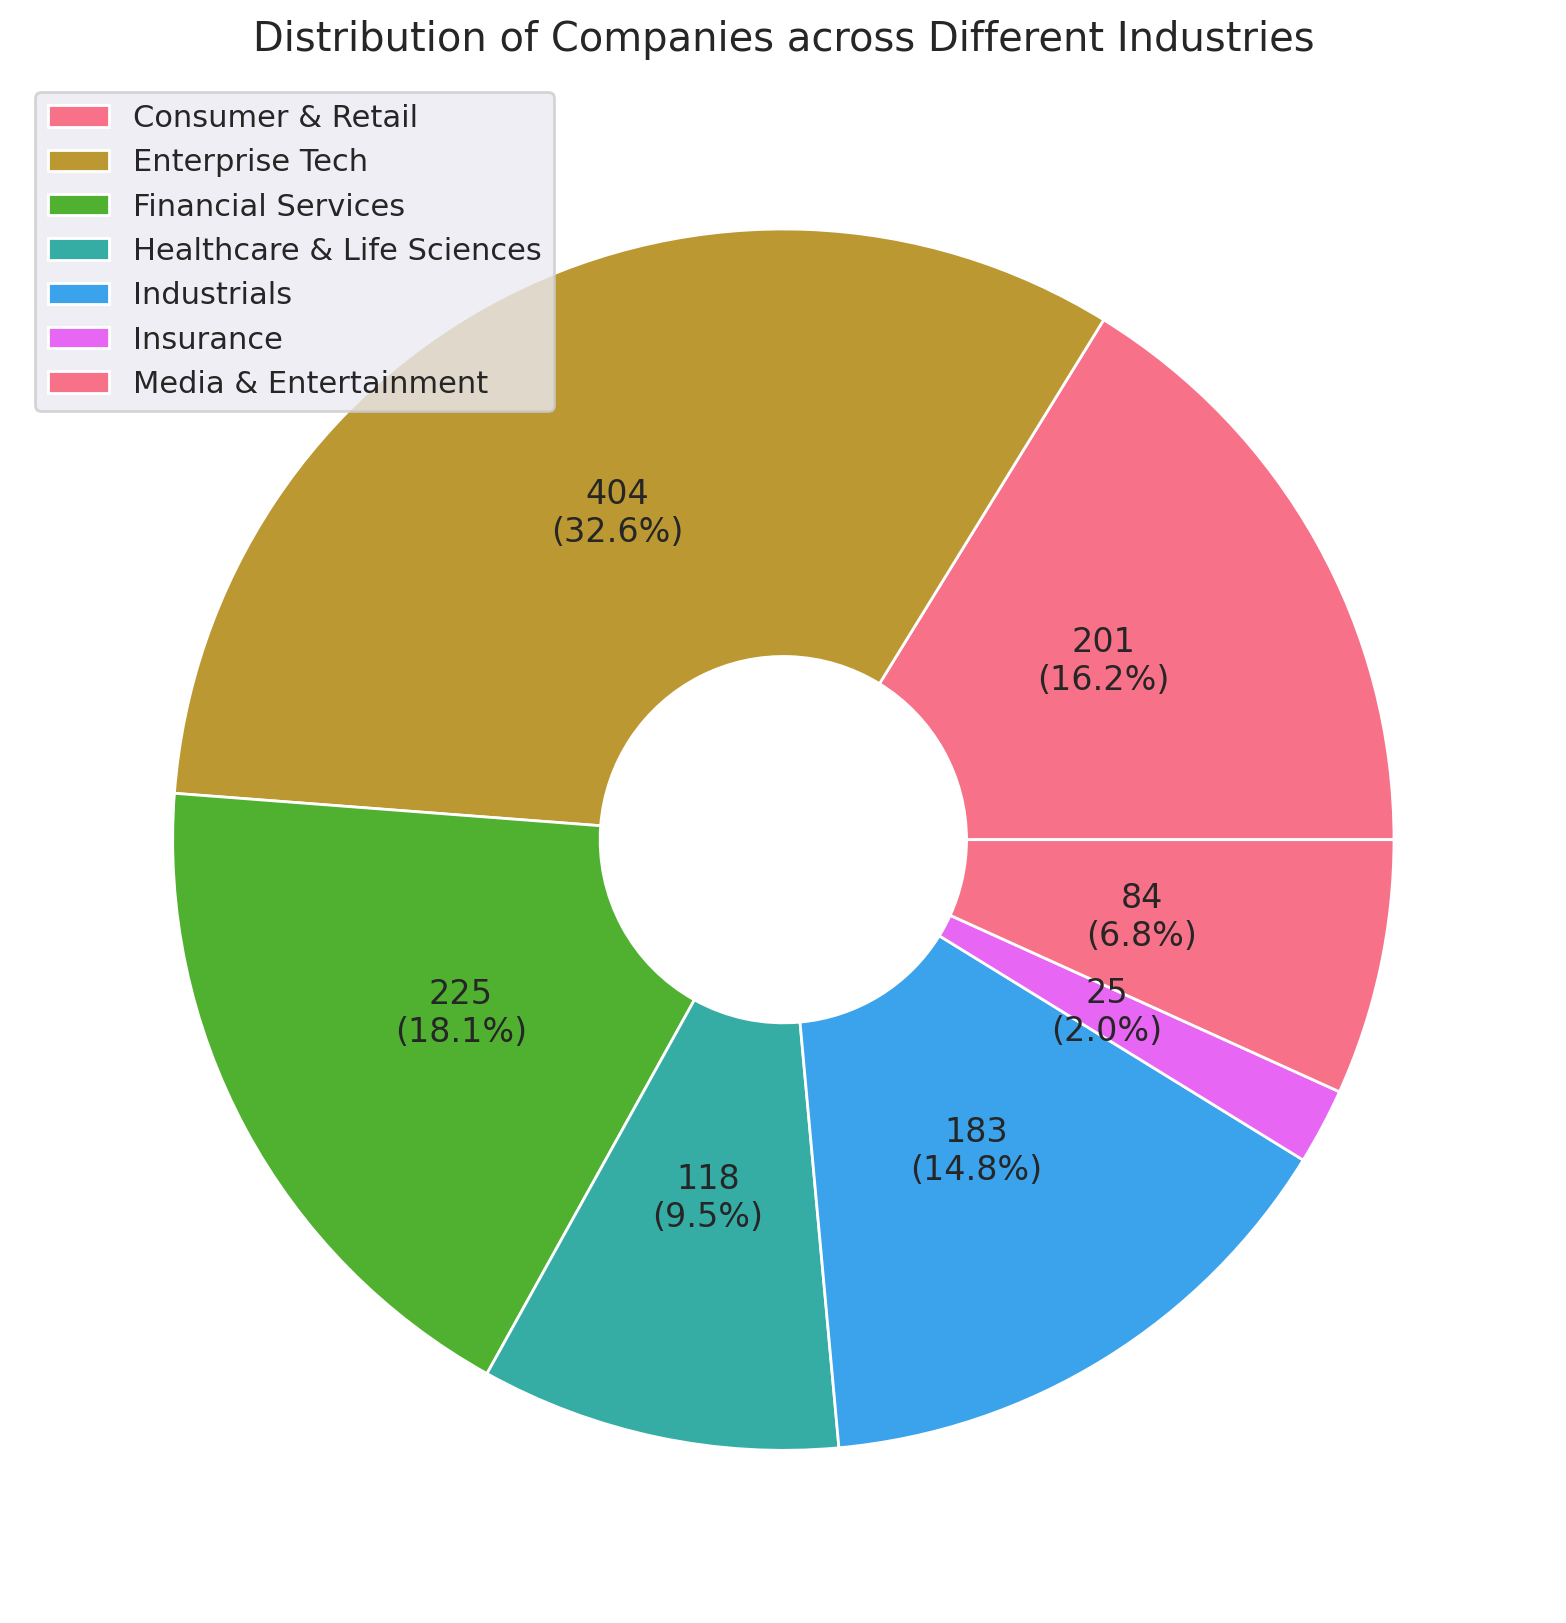

### Distribution of Valuation across Different Industries

In [ ]:
_df = df.groupby('Industry')['Latest Valuation ($B)'].sum().sort_values(ascending=False)

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=2, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.sharey(ax2)
# ax3 = fig.add_subplot(gs[1, :])

g = sns.barplot(y=_df.index, x=_df.values, hue=_df.index, ax=ax1)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%.2f')
ax1.set_xlabel('Total Valuation ($B)')
ax1.set_ylabel(None)
sns.boxplot(df, y='Industry', x='Latest Valuation ($B)', hue='Industry', showfliers=False, ax=ax2)
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('Mean Valuation ($B)')

plt.grid(axis='x', alpha=0.75)
plt.suptitle('Distribution of Valuation across Different Industries')

plt.ylabel(None)
plt.show()


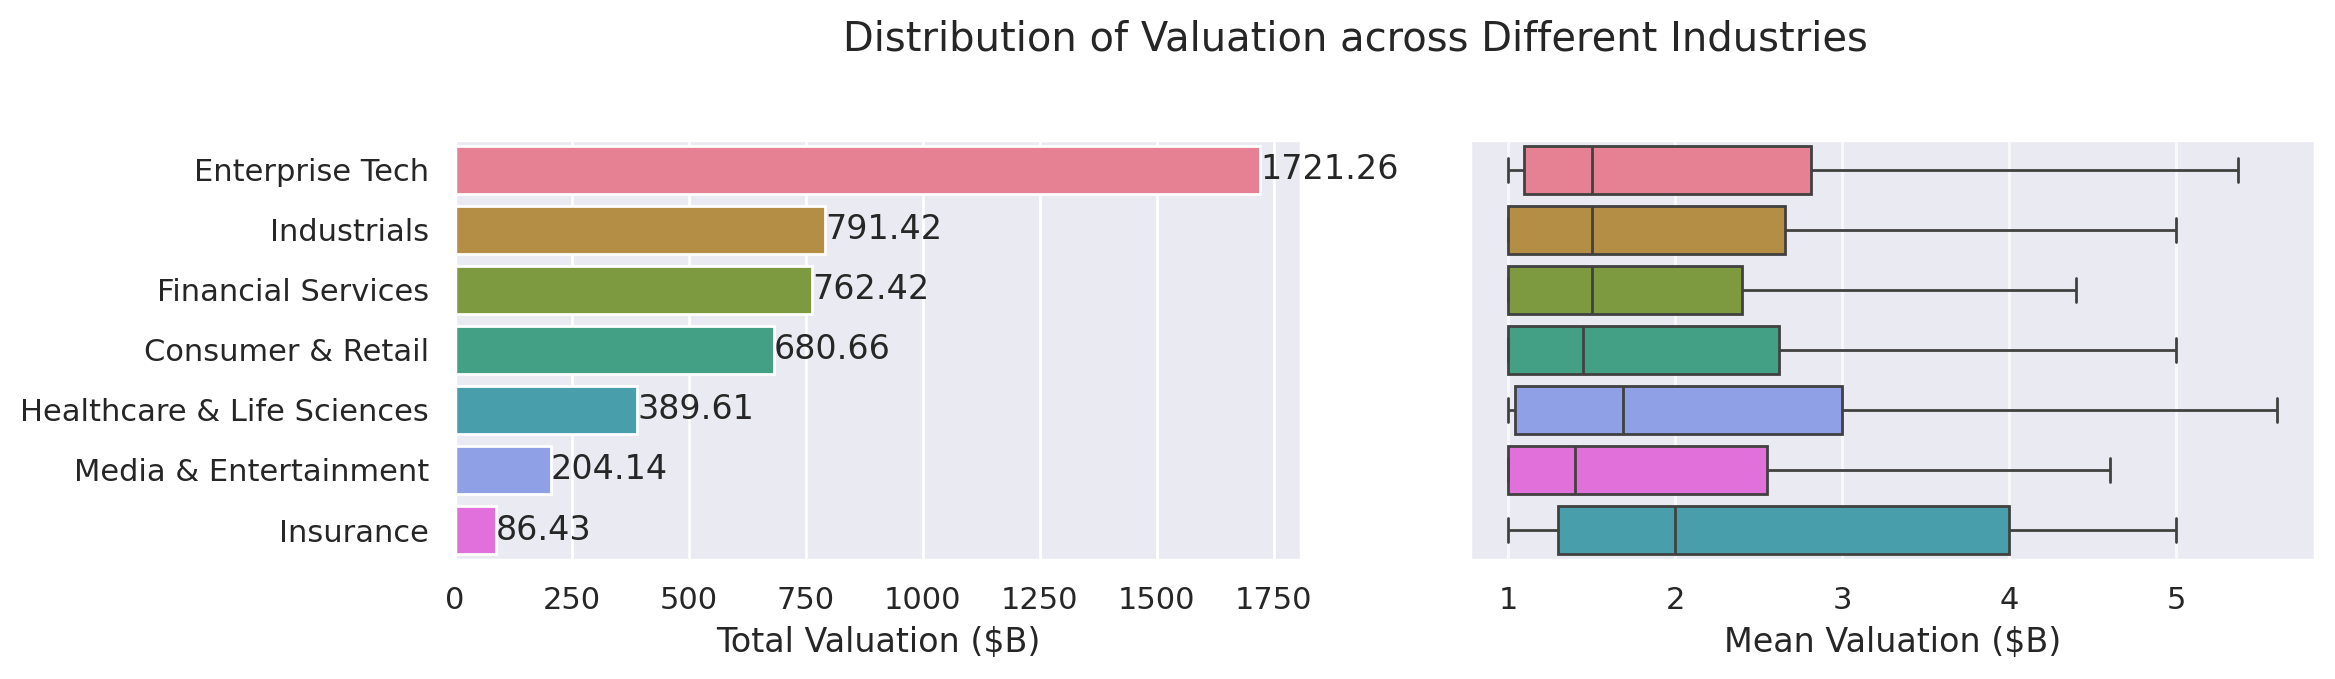

### Distribution of Equity Funding across Different Industries

In [ ]:
_df = df.groupby('Industry')['Funding ($B)'].sum().sort_values(ascending=False)

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=2, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.sharey(ax2)

g = sns.barplot(y=_df.index, x=_df.values, hue=_df.index, ax=ax1)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%.2f')
ax1.set_xlabel('Total Equity Funding ($B)')
ax1.set_ylabel(None)
sns.boxplot(df, y='Industry', x='Funding ($M)', hue='Industry', showfliers=False, ax=ax2)
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('Mean Equity Funding ($M)')

plt.grid(axis='x', alpha=0.75)
plt.suptitle('Distribution of Equity Funding across Different Industries')

plt.ylabel(None)
plt.show()


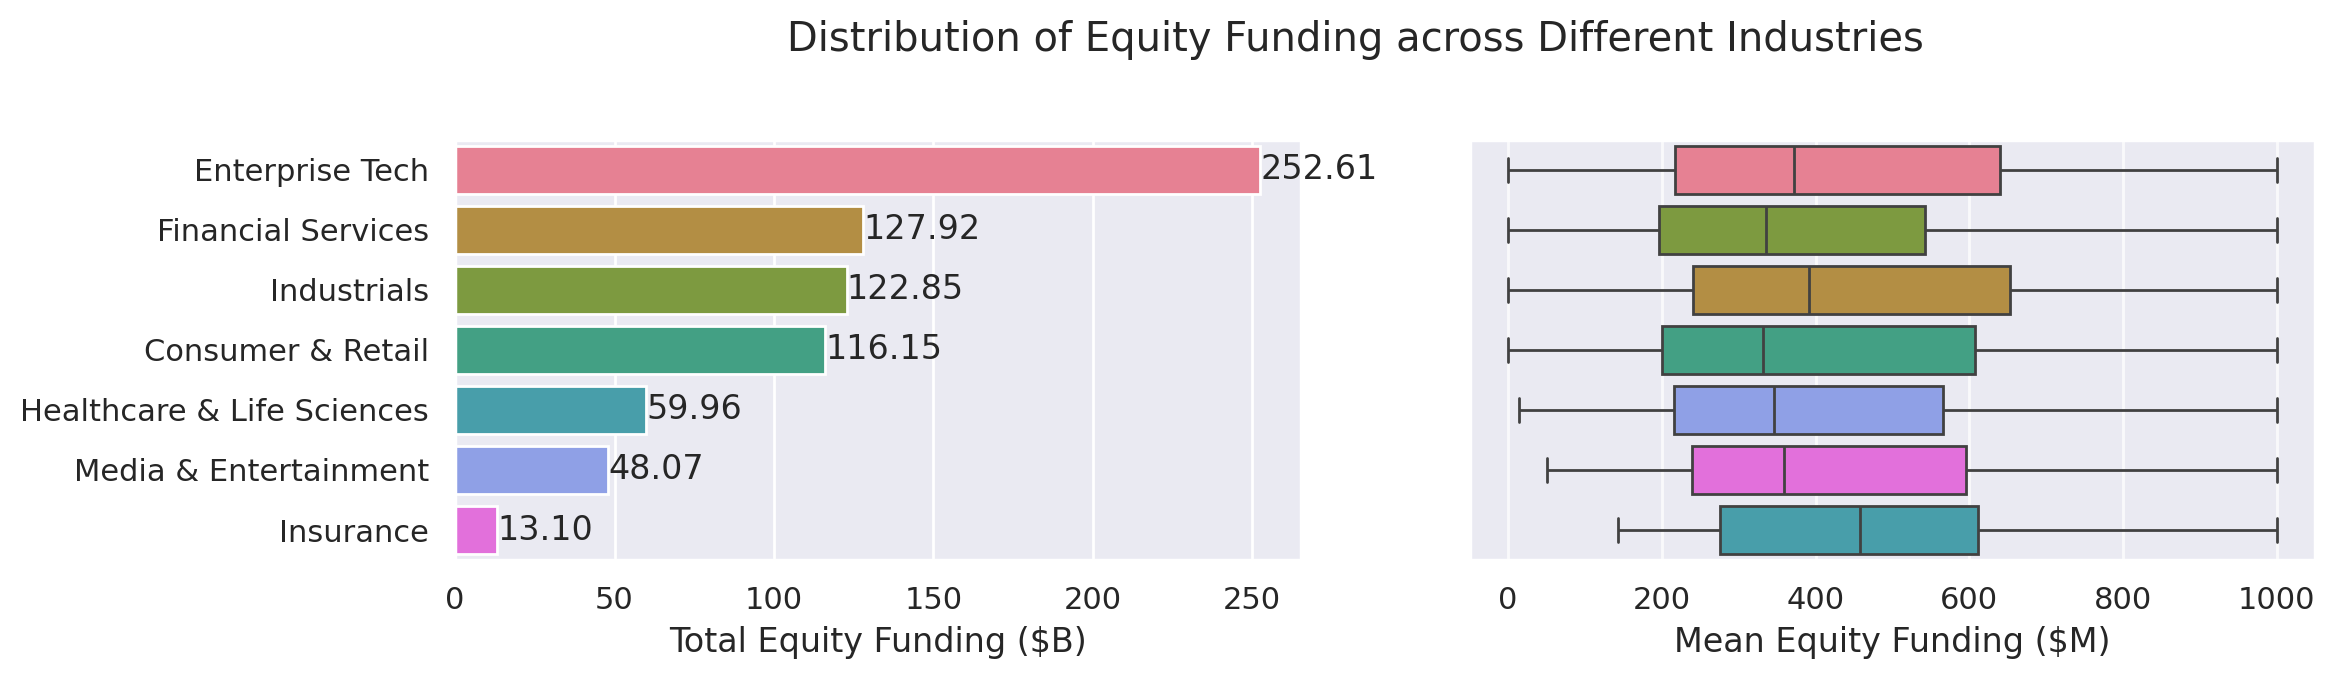

## Geographical Analysis

In [ ]:
df_worldcities = pd.read_csv('./input/datasets/worldcities.csv')
df_worldcities = df_worldcities.drop_duplicates('city_ascii')
df_geo = df.merge(df_worldcities[['city_ascii', 'lat', 'lng']], left_on='City', right_on='city_ascii', how='inner')
_df = df_geo.groupby(['Country', 'City', 'lat', 'lng'])\
            .agg(valuation=('Latest Valuation ($B)', 'sum'),
                 cnt=('Company', 'count'))\
            .sort_values('valuation', ascending=False)\
            .reset_index()
fig = px.scatter_geo(_df, lat='lat', lon='lng', hover_name='City', size='valuation', color='Country')
fig.show()


### Top Countries by Valuation

In [ ]:
_df = df.groupby('Country')['Latest Valuation ($B)']\
        .agg(['count', 'sum'])\
        .sort_values(by='sum', ascending=False)\
        .head(30)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
g = sns.barplot(_df, x=_df.index, y='sum', hue=_df.index, ax=ax[0])
g.set(ylabel='Latest Valuation ($B)',
      yscale='log')
for i in ax[0].containers:
    ax[0].bar_label(i, rotation=45, fontsize=8)
g = sns.barplot(_df, x=_df.index, y='count', hue=_df.index, ax=ax[1])
g.set(ylabel='Number of Companies',
      yscale='log')
for i in ax[1].containers:
    ax[1].bar_label(i, rotation=45, fontsize=8)
plt.suptitle('Top Countries')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')
plt.xlabel(None)
plt.show()


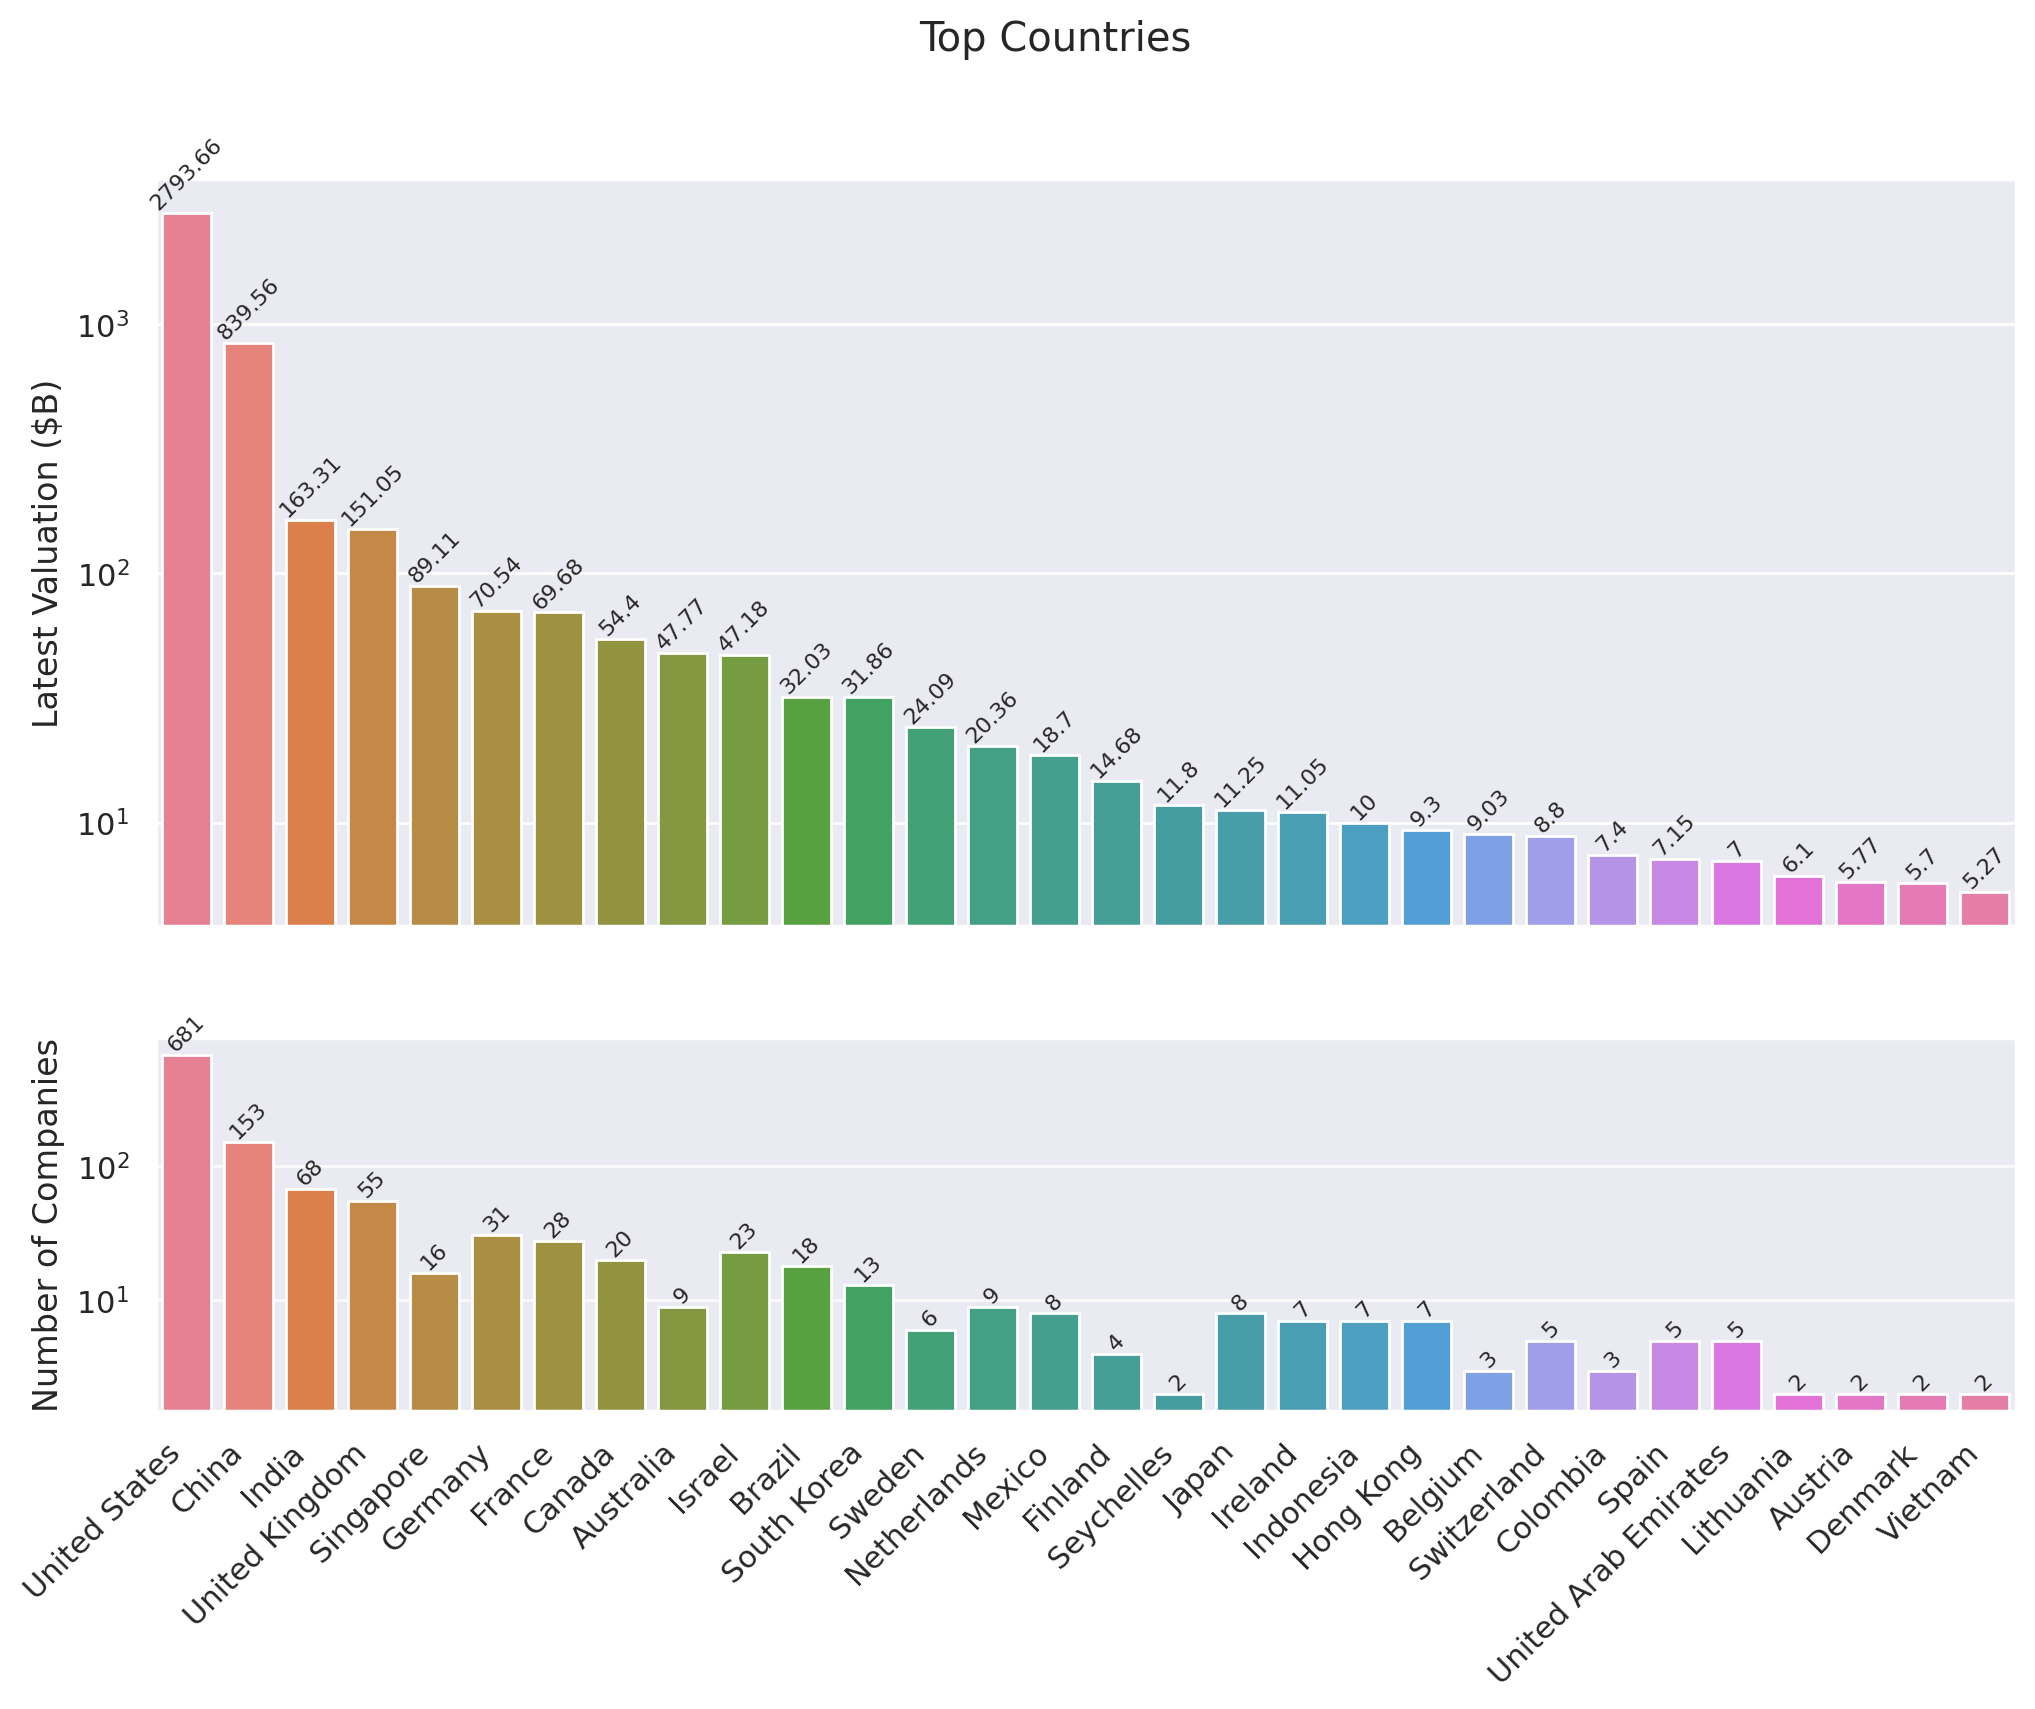

### Top Countries across Different Industries

In [ ]:
df_filtered =  df[df['Country'].isin(top_countries.head(10).index)]\
    .groupby(['Country', 'Industry'])['Latest Valuation ($B)']\
    .agg(['count', 'sum'])\
    .reset_index()


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
g = sns.barplot(df_filtered, x='Country', y='sum', hue='Industry', ax=ax[0])
sns.move_legend(ax[0], 'upper left', bbox_to_anchor=(1, .55), frameon=False)
g.set(ylabel='Valuation ($B)',
      yscale='log')
for i in ax[0].containers:
    ax[0].bar_label(i, rotation=45, fontsize=8, fmt='%d')
g = sns.barplot(df_filtered, x='Country', y='count', hue='Industry', ax=ax[1], legend=False)
g.set(ylabel='Number of Companies',
      yscale='log')
for i in ax[1].containers:
    ax[1].bar_label(i, rotation=45, fontsize=8)
plt.suptitle('Top Countries across Different Industries')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')
plt.xlabel(None)
plt.show()


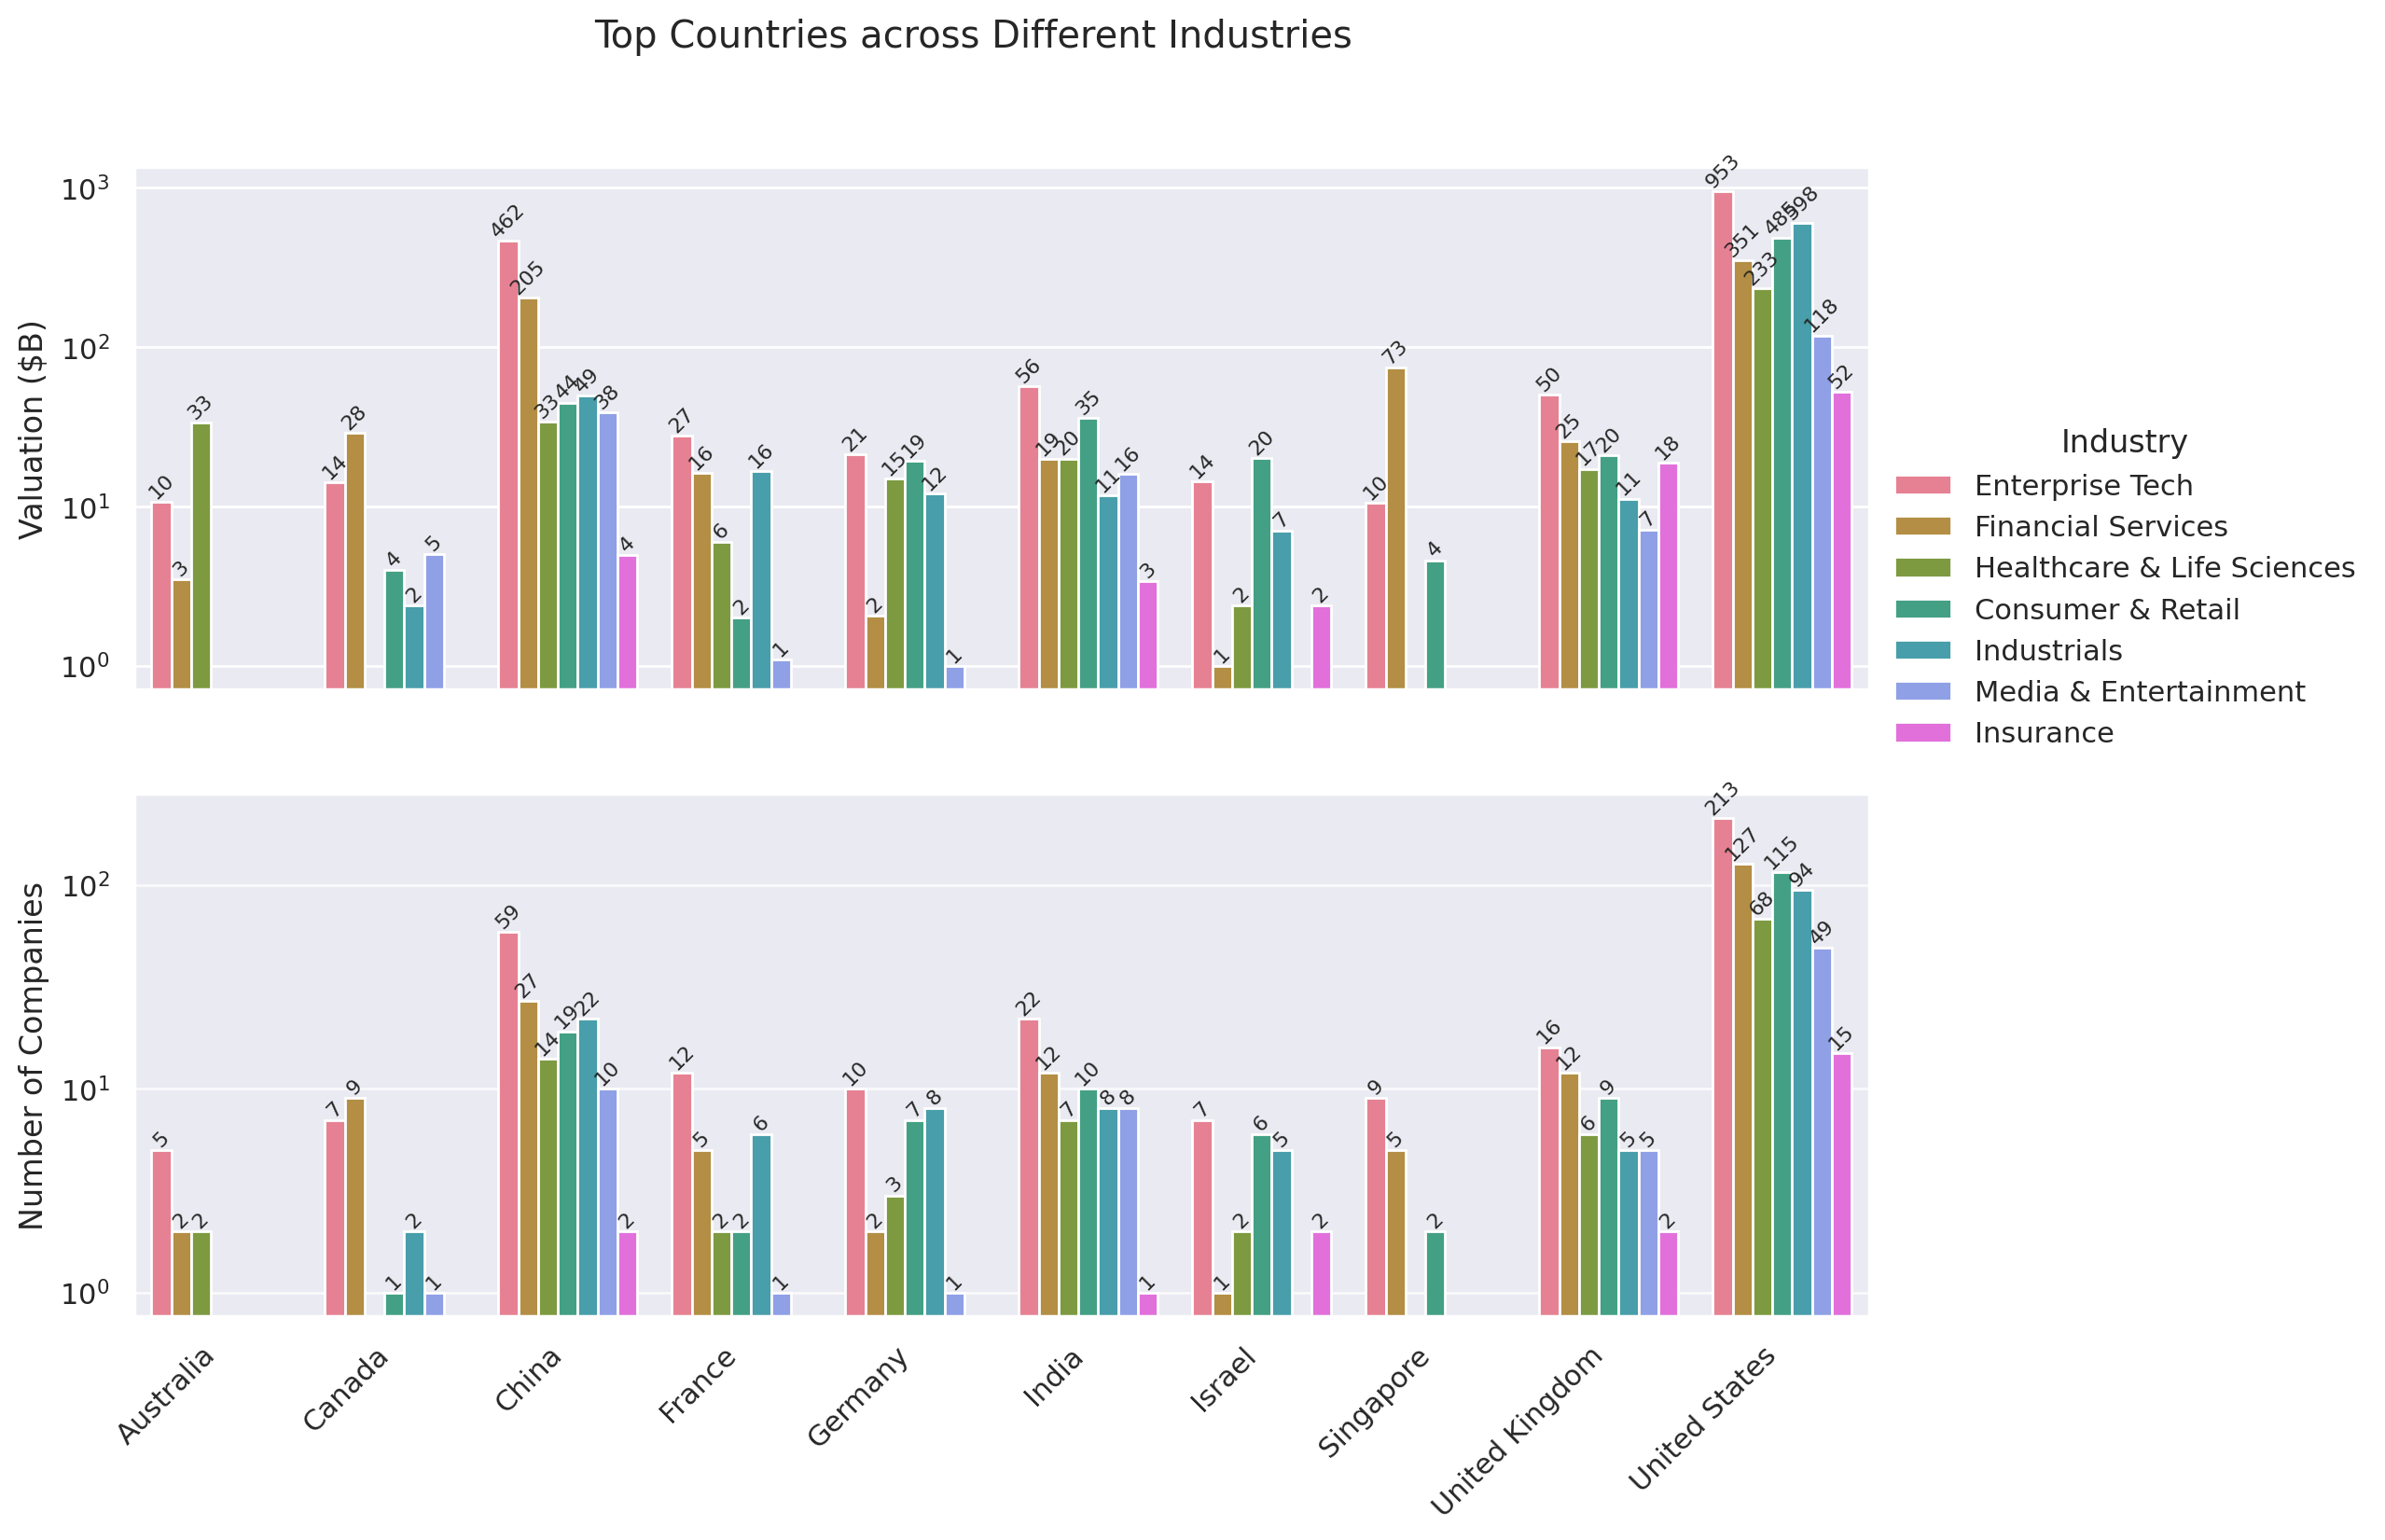

### Mean Distribution of Valuations across Different Countries

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(df[df['Country'].isin(top_countries.index)],
            y='Country',
            x='Latest Valuation ($B)',
            hue='Country',
            showfliers=False)
plt.suptitle('Distribution of Valuations across Different Countries')
ax.set(xlabel='Total Valuation ($B)',
       ylabel='Country')
plt.grid(axis='x', alpha=0.7)
plt.show()


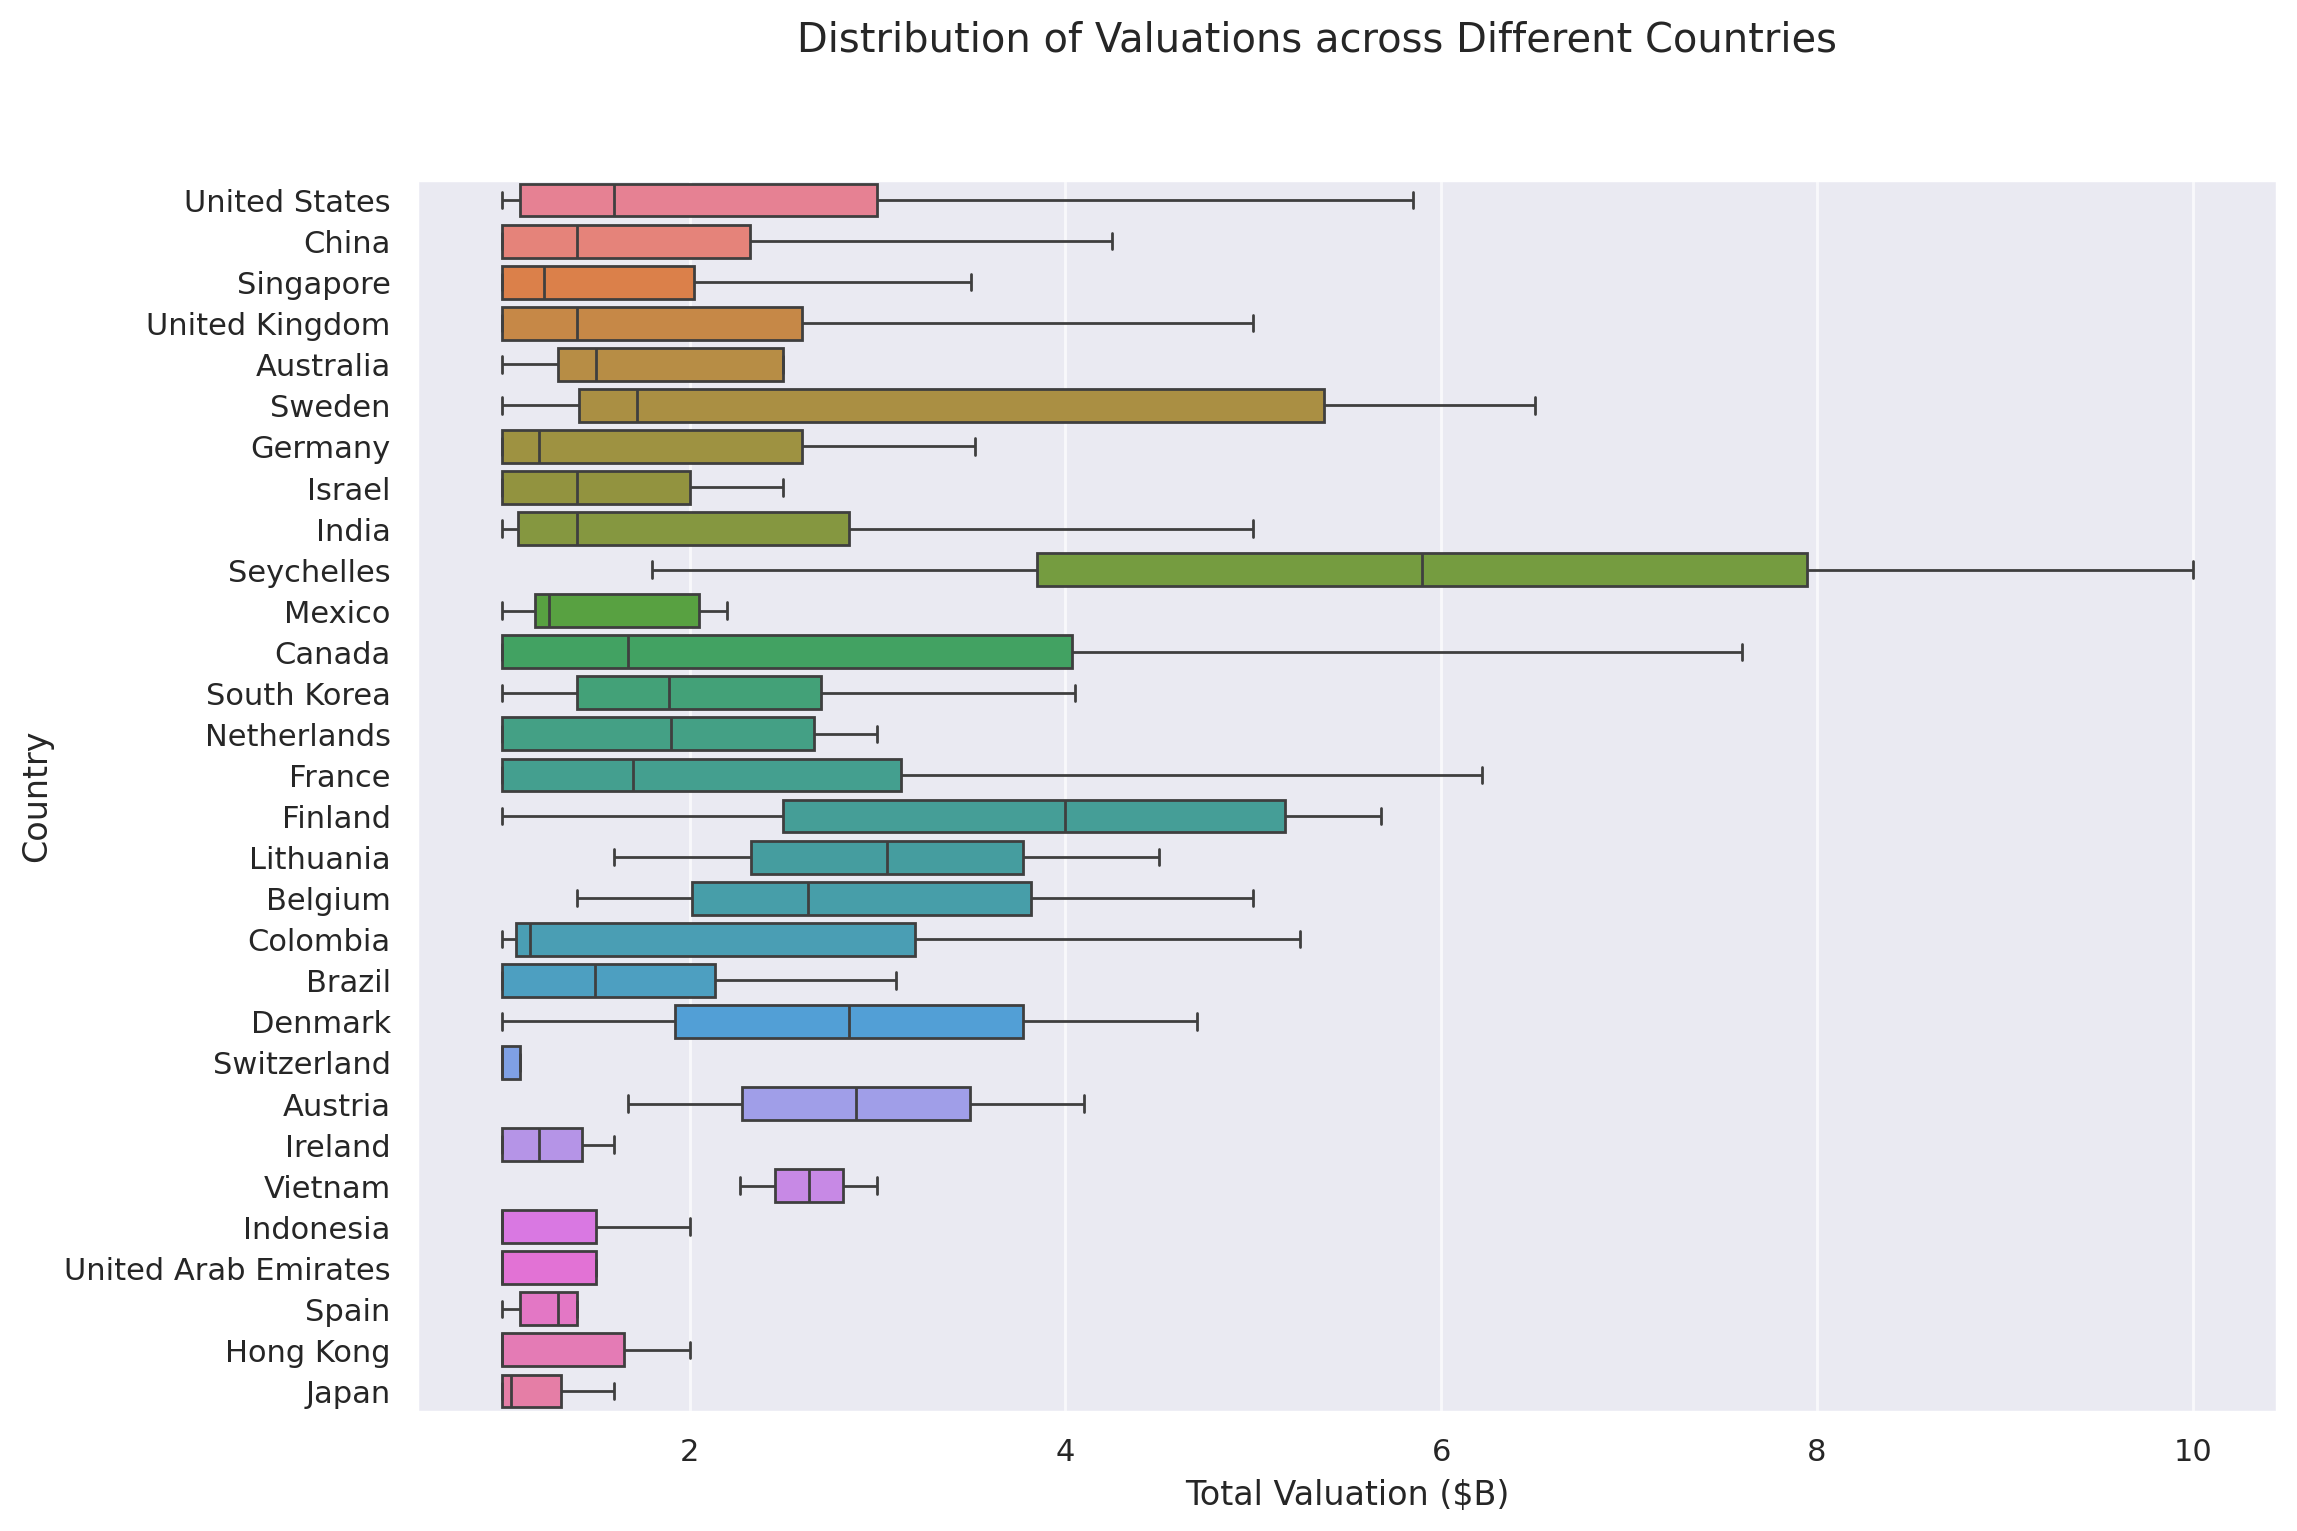

In [ ]:
_df = df.pivot_table(index='Country', columns='Industry', values='Latest Valuation ($B)', aggfunc='median')
plt.figure(figsize=(15, 14))
sns.heatmap(_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Median Valuation ($B) by Country and Industry')
plt.tight_layout()
plt.show()


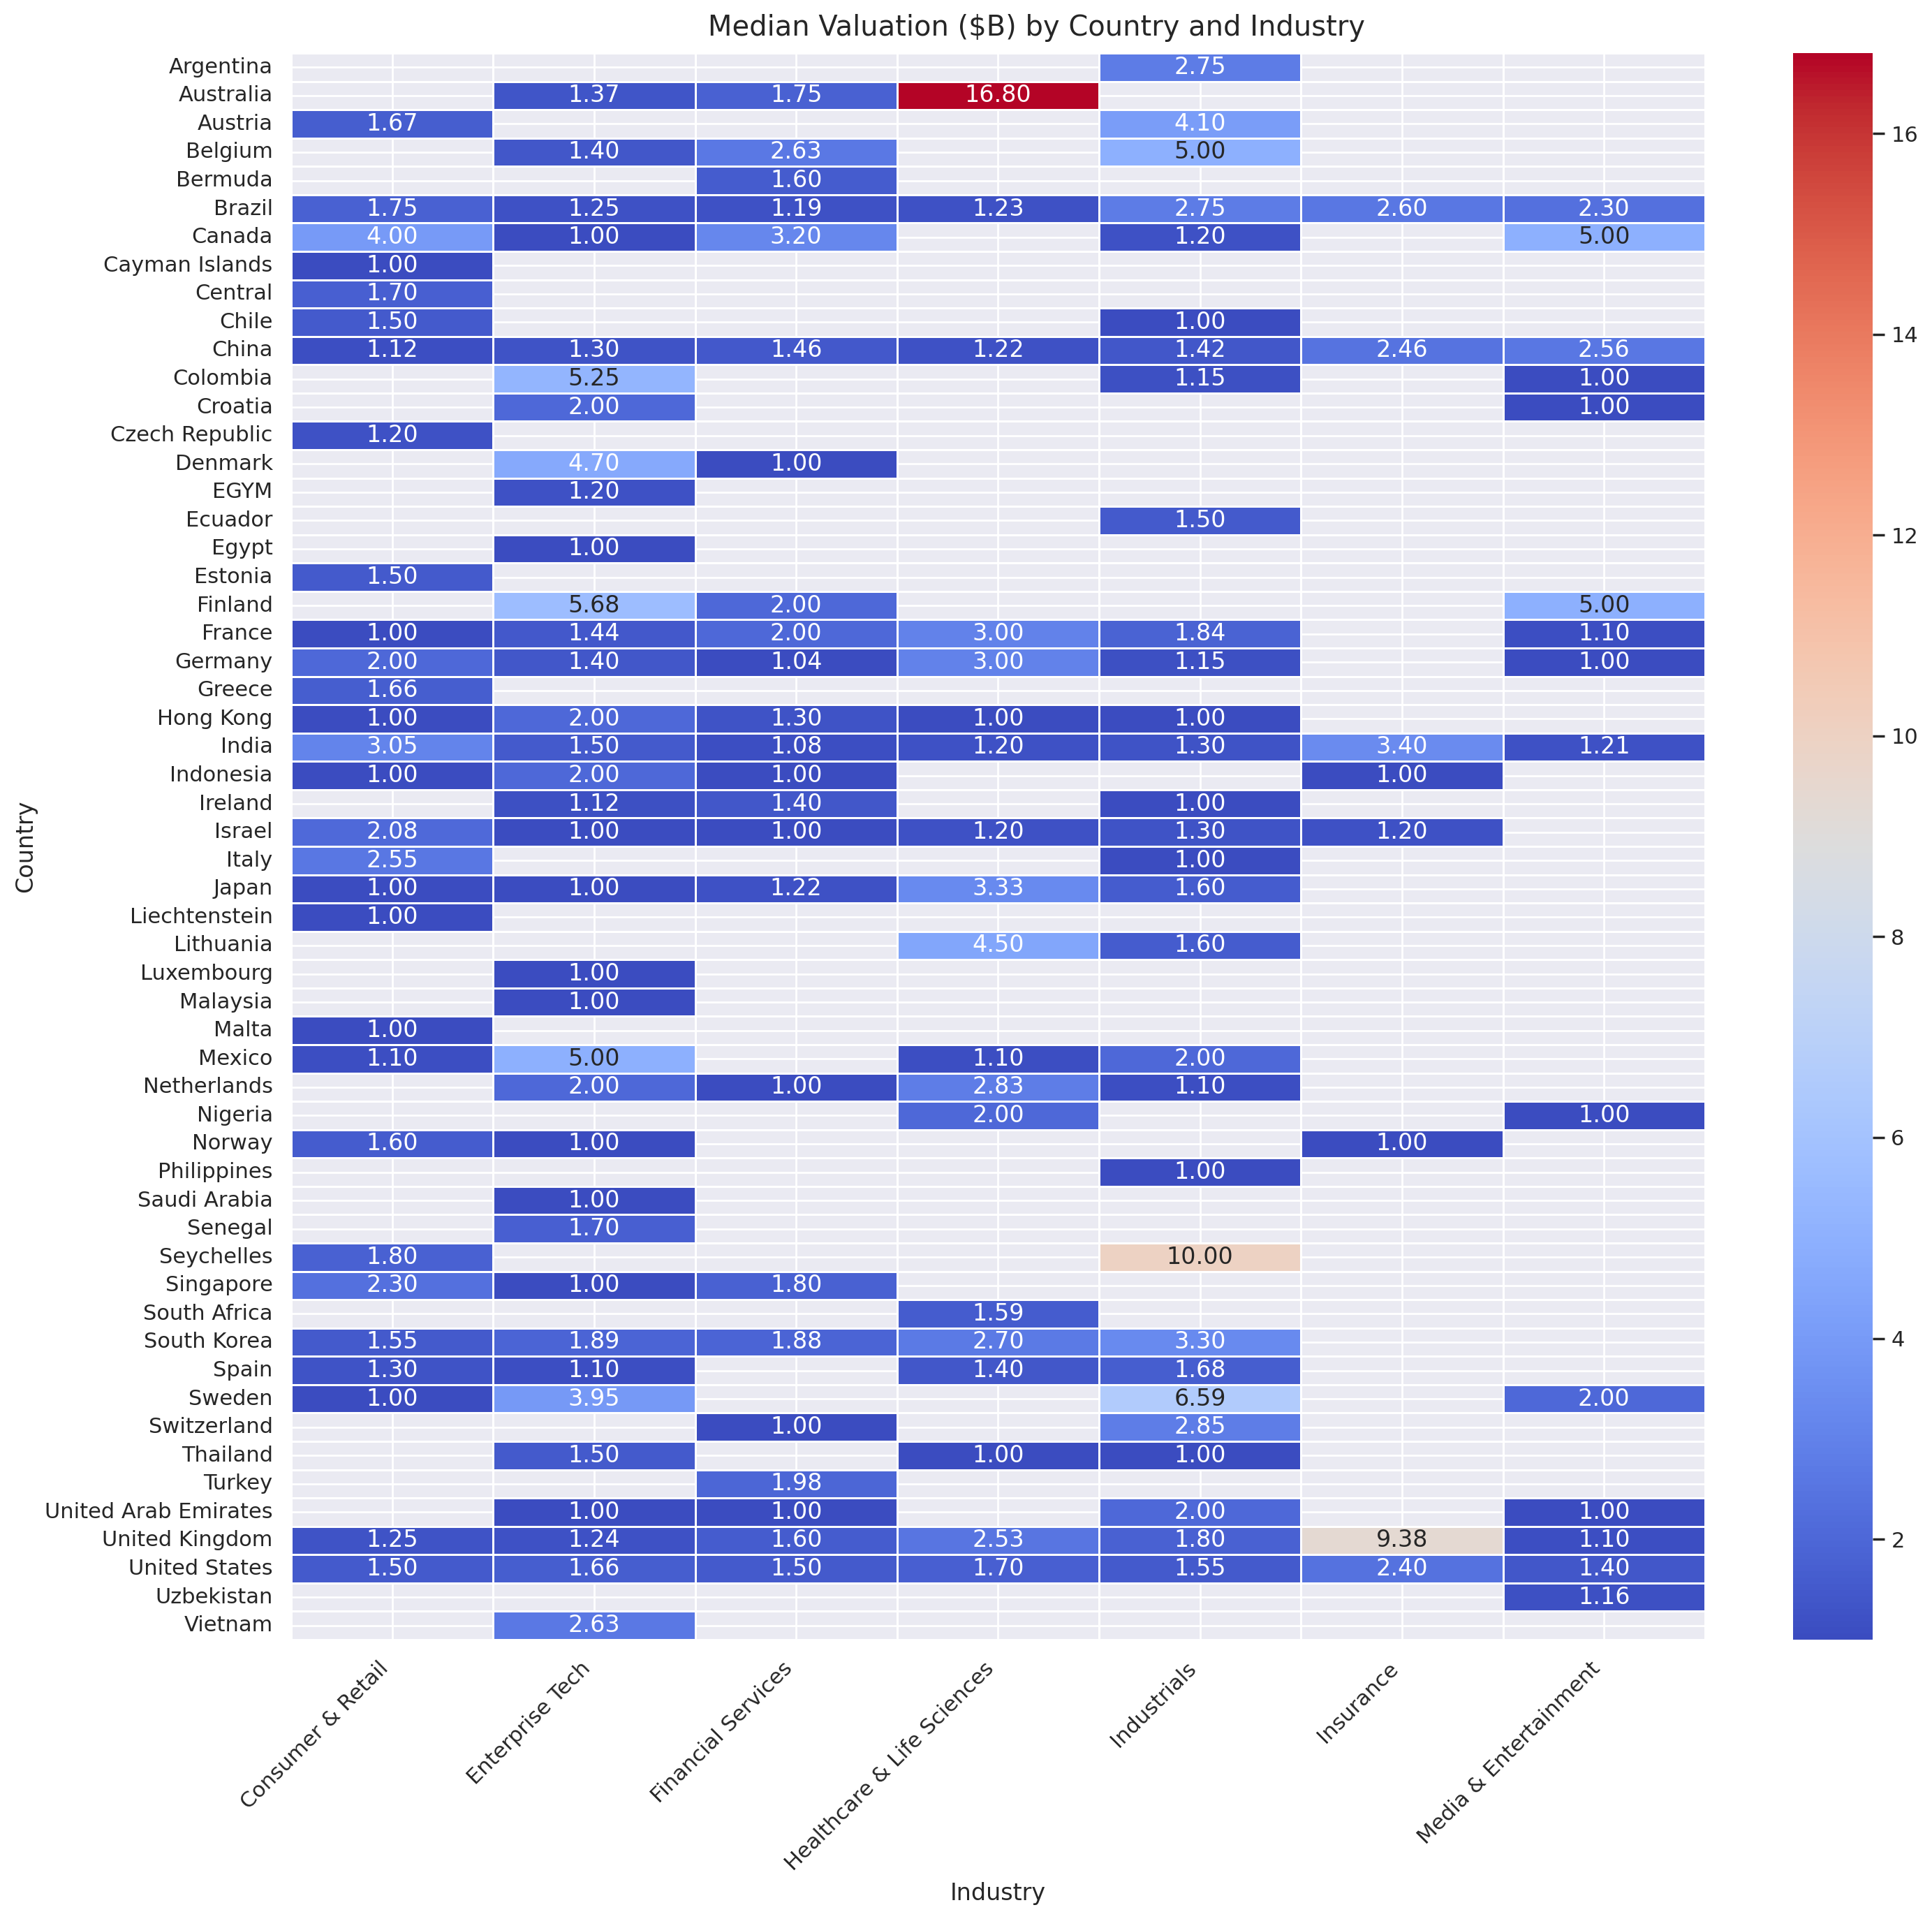

### Mean Distribution of Equity Funding across Different Countries

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(df[df['Country'].isin(top_countries.index)], y='Country', x='Funding ($M)', hue='Country', showfliers=False)
plt.suptitle('Distribution of Funding across Different Countries')
ax.set(xlabel='Funding ($M)',
       ylabel='Country')
plt.grid(axis='x', alpha=0.7)
plt.show()


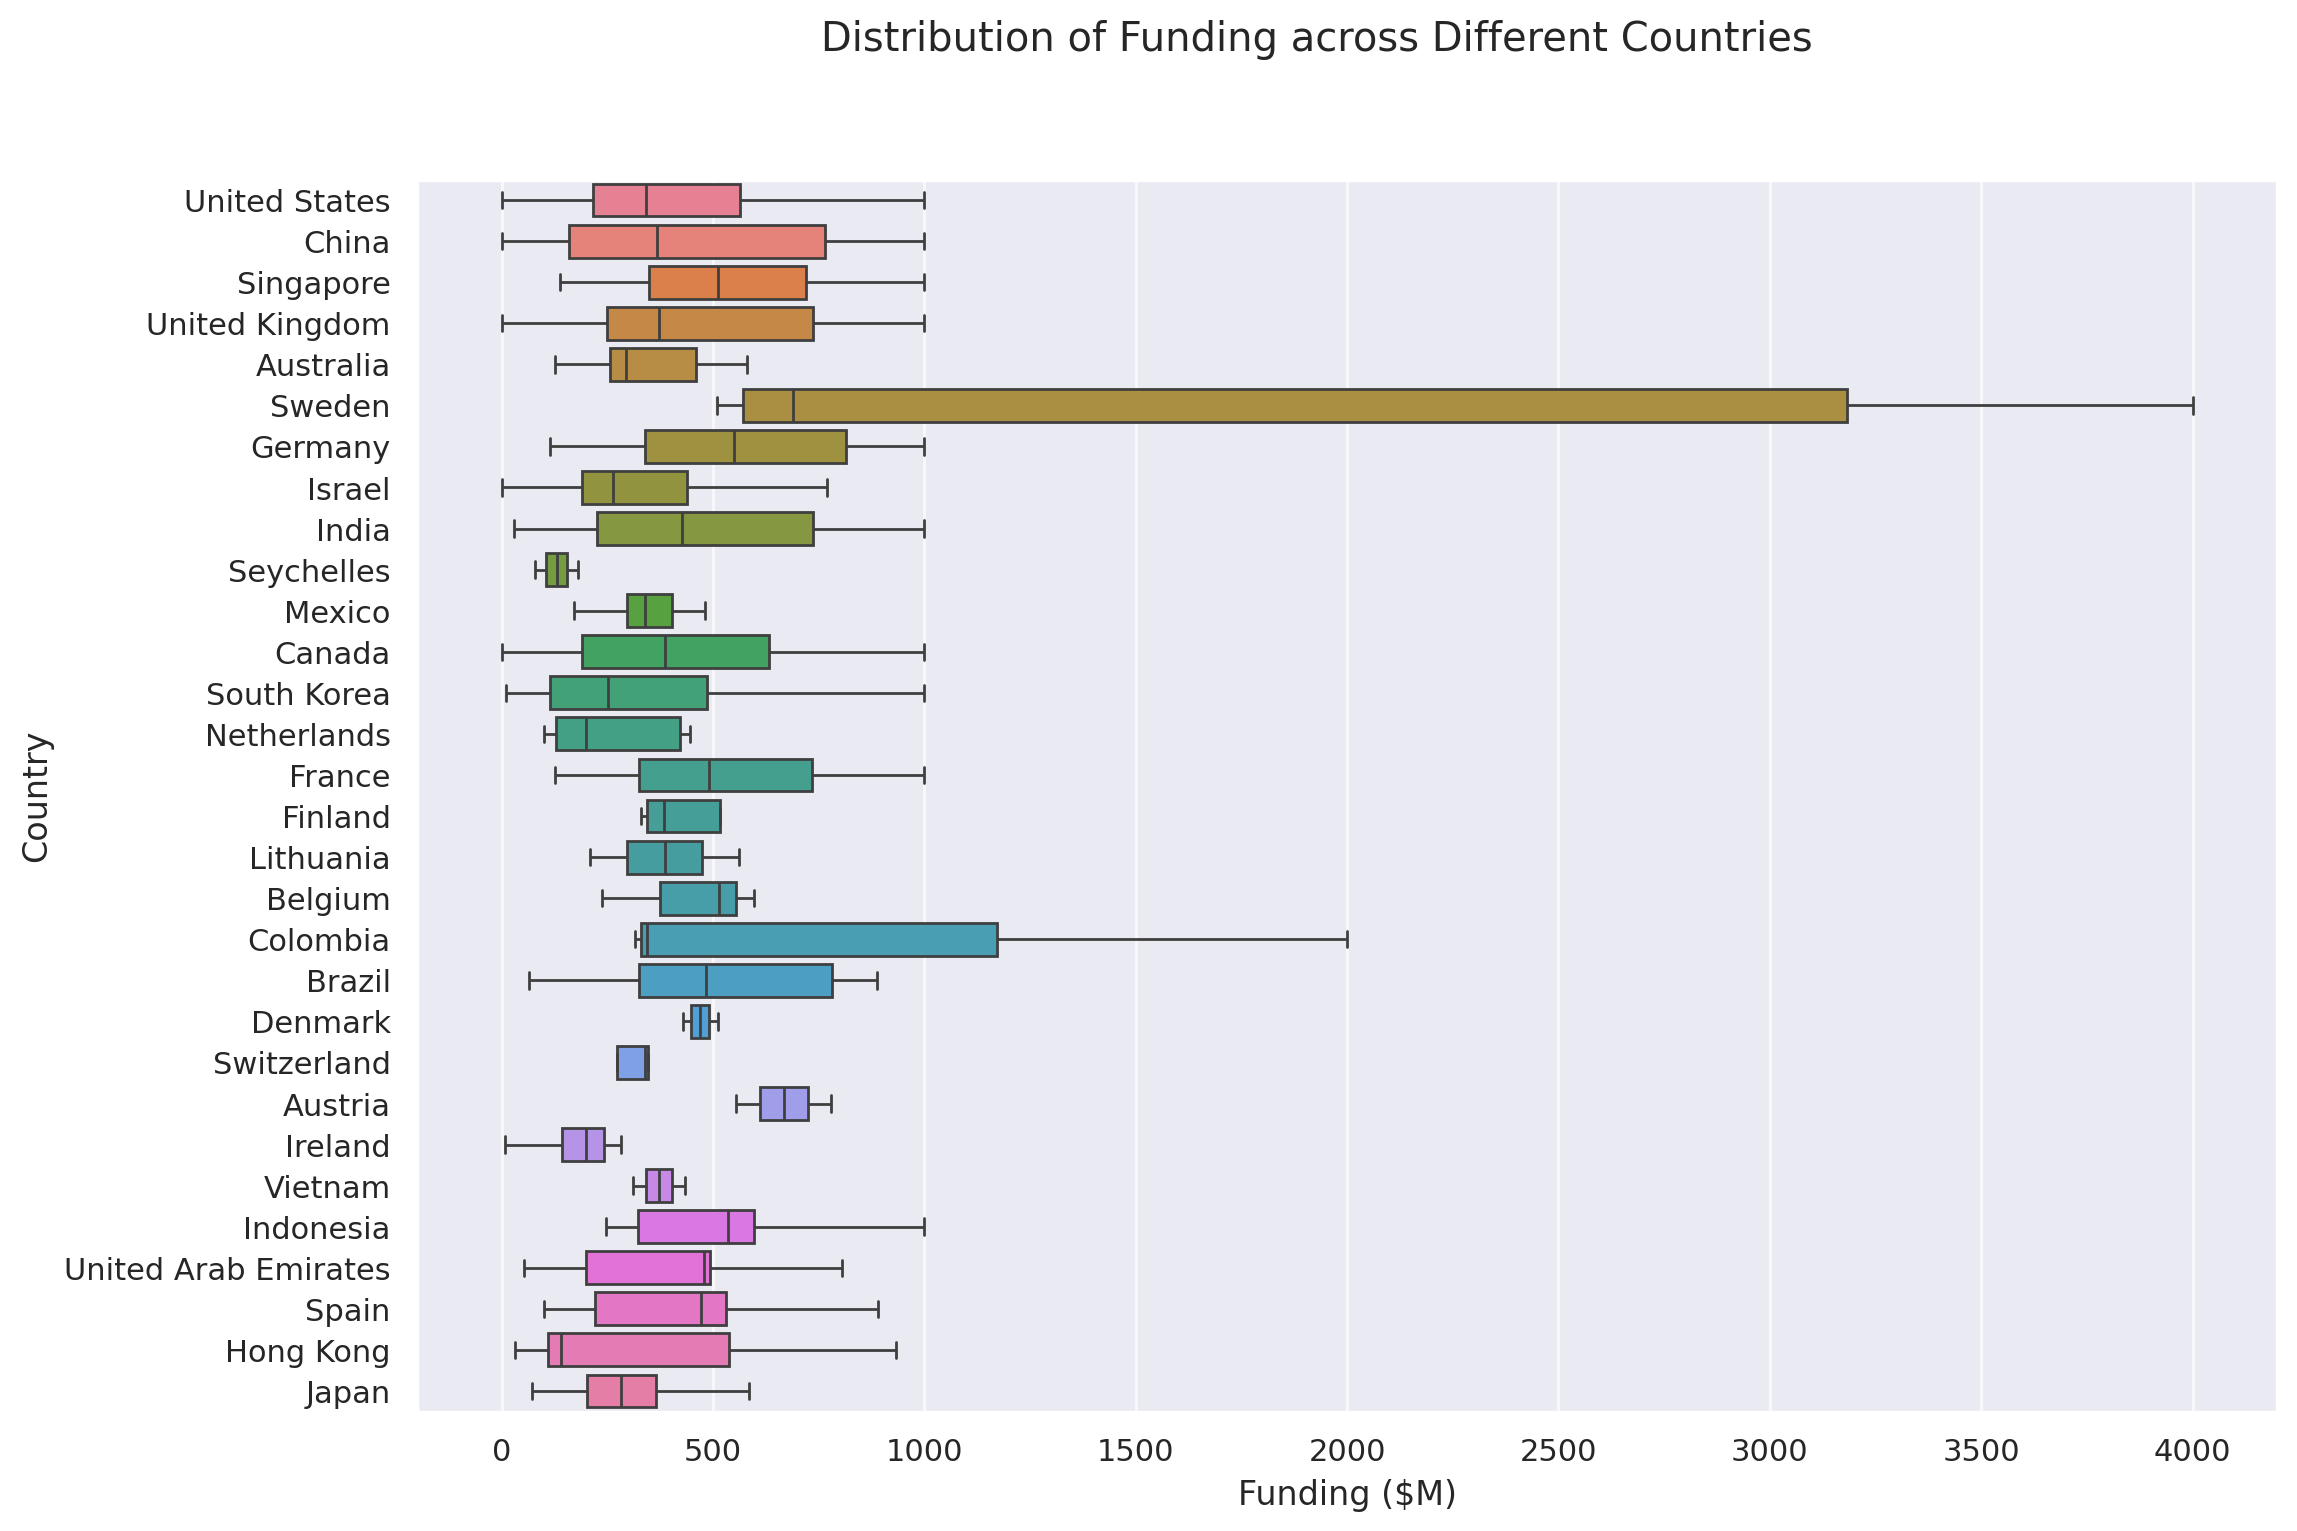

In [ ]:
_df = df.pivot_table(index='Country', columns='Industry', values='Funding ($M)', aggfunc='median')
plt.figure(figsize=(15, 14))
sns.heatmap(_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Median Funding ($M) by Country and Industry')
plt.tight_layout()
plt.show()


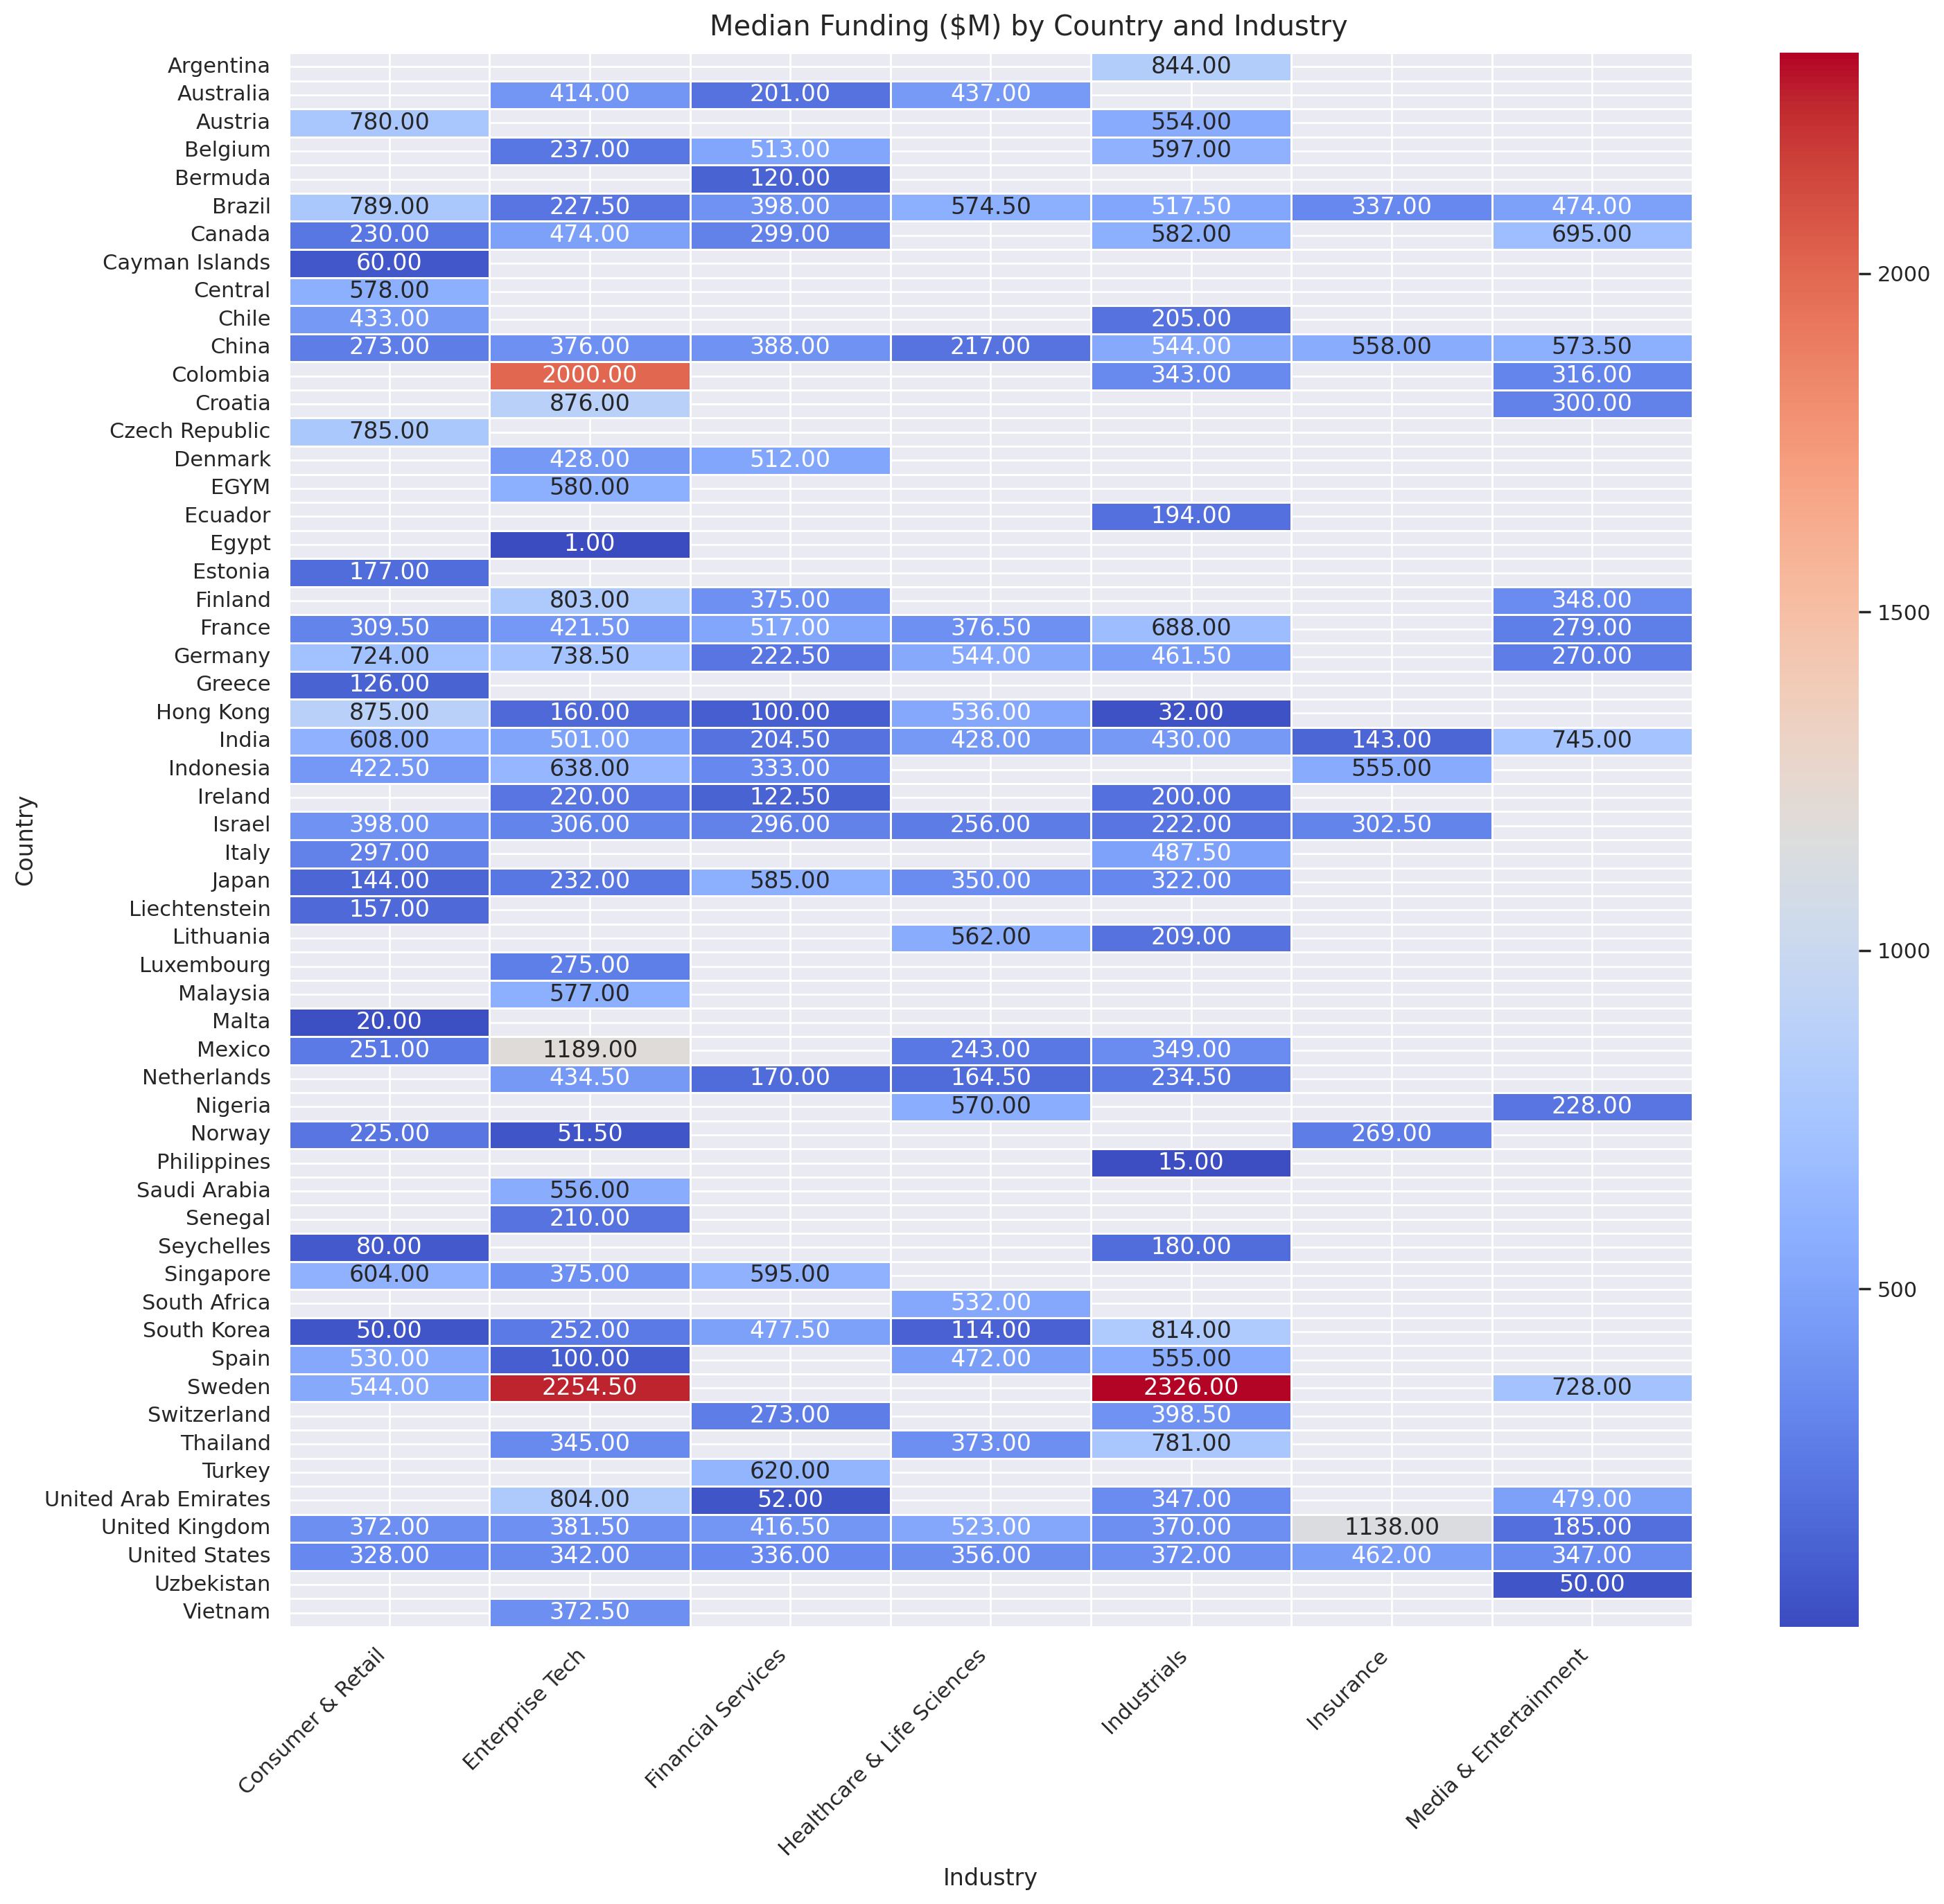

## Sector-Based Analysis

### Top Sectors

In [ ]:
_df = df.explode('Sector')[['Sector', 'Latest Valuation ($B)', 'Funding ($B)']]\
        .groupby('Sector')[['Latest Valuation ($B)', 'Funding ($B)']]\
        .agg({'Latest Valuation ($B)': ['sum', 'count'], 'Funding ($B)': 'sum'})
_df.columns = ['Valuation ($B)', 'Number of Companies', 'Funding ($B)']
_df = _df.sort_values(by='Valuation ($B)', ascending=False).head(20)
print(_df)


``` example
                         Valuation ($B)  Number of Companies  Funding ($B)
Sector
Artificial Intelligence          585.98                   22        48.908
Aerospace                        354.20                    2        10.000
Internet                         320.00                    4         9.373
Software                         214.06                   44        35.165
Financial Technology             185.27                   53        34.698
E-Commerce                       169.11                   22        23.460
Financial Services               142.55                   14        21.798
Cybersecurity                     54.08                   21        12.301
Marketplace                       48.03                   14        13.480
Cryptocurrency                    41.90                   11         4.204
Video Games                       39.70                    4         9.375
Educational Technology            33.47                    9         9.586
Graphic Design                    33.00                    2         0.775
Software As A Service             32.70                   11         4.542
Healthcare                        31.30                   11         6.196
Transportation                    25.05                    7        10.480
Collaborative Software            24.00                    2         1.400
Finance                           21.30                    4         2.359
Blockchain                        20.80                    4         2.060
Logistics                         18.02                    9         6.418
```

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
g = sns.barplot(_df, x=_df.index, y='Valuation ($B)', ax=ax[0], hue=_df.index)
for i in ax[0].containers:
    g.bar_label(i, fmt='%d', fontsize=10)
# g = sns.barplot(_df, x=_df.index, y='Funding ($B)', ax=ax[1], hue=_df.index)
# for i in ax[1].containers:
#     g.bar_label(i, fmt='%.1f', fontsize=10)
g = sns.barplot(_df, x=_df.index, y='Number of Companies', ax=ax[1], hue=_df.index)
ax[1].set(ylabel='Companies')
for i in ax[1].containers:
    g.bar_label(i, fmt='%d', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel(None)
plt.suptitle('Top Sectors')
plt.show()


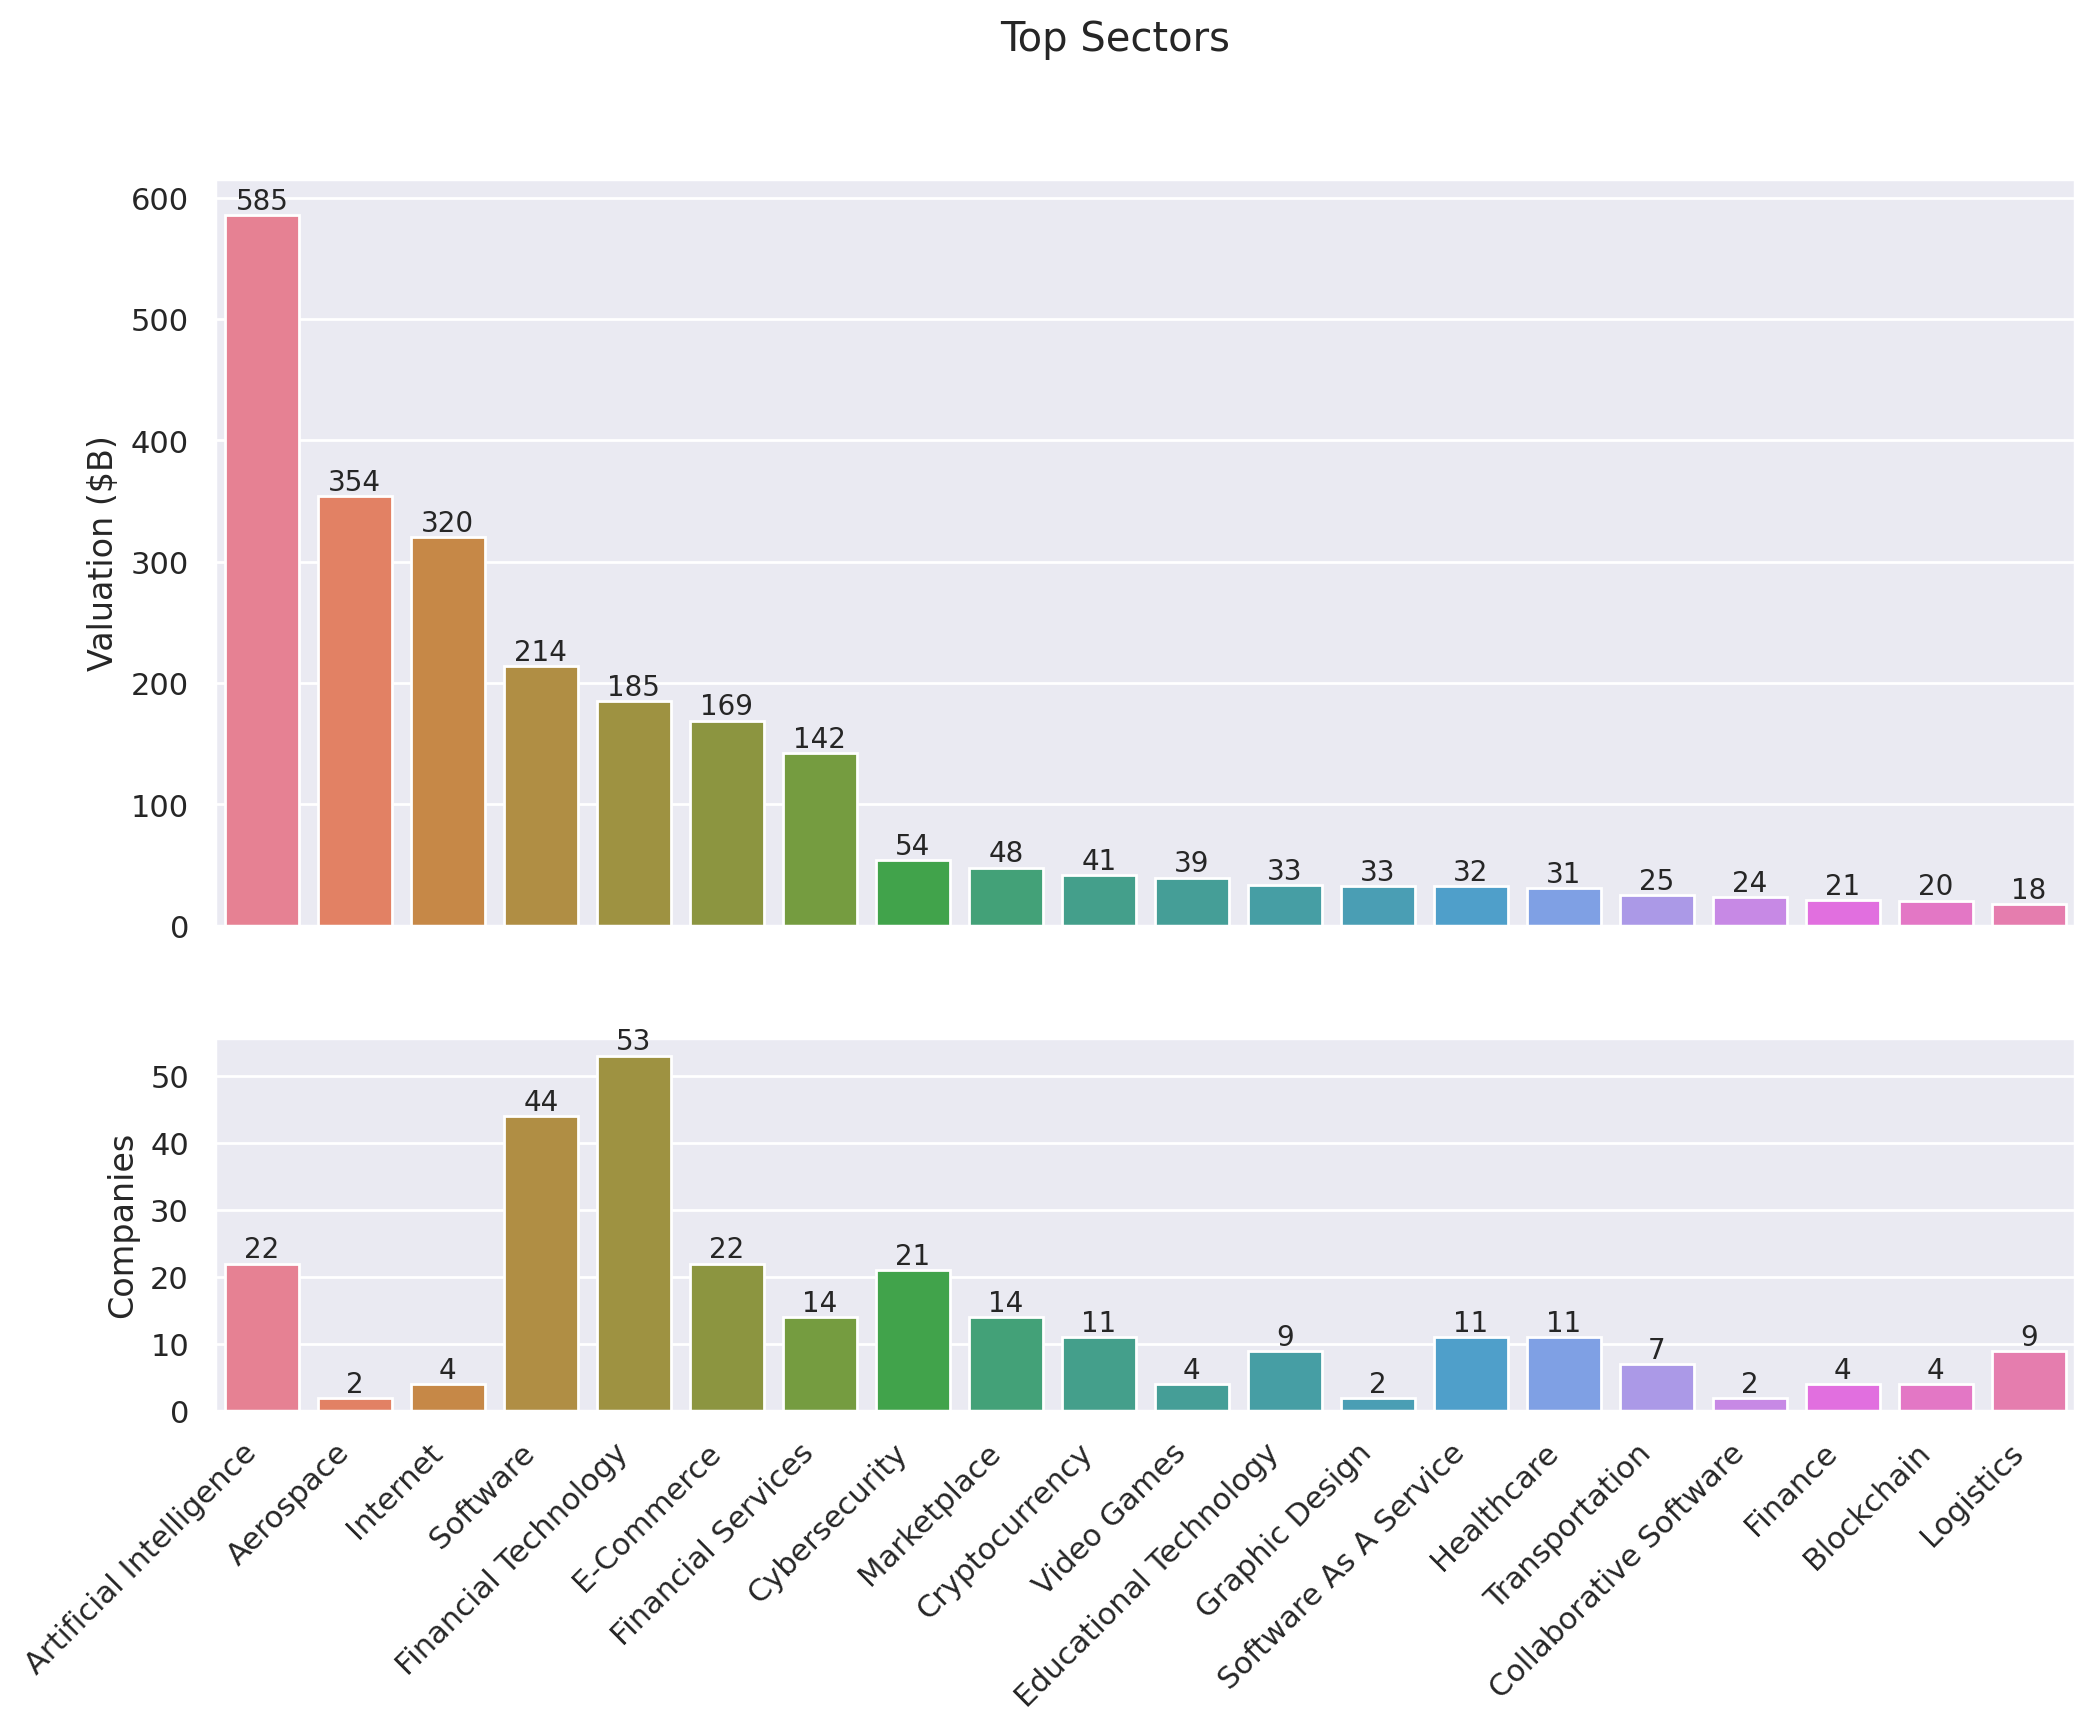

## Company-Based Analysis

### Top Companies by Valuation

In [ ]:
top_companies = df.sort_values(by='Latest Valuation ($B)', ascending=False).head(20)
top_companies['Growth Rate'] = (top_companies['Latest Valuation ($B)'] - top_companies['Valuation ($B)']) / top_companies['Valuation ($B)'] * 100


In [ ]:
# Set the positions and width for the bars
N = len(top_companies)
ind = np.arange(N)  # the x locations for the groups
width = 0.35  # the width of the bars

# Create the bars for valuation and funding
fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax[0].bar(ind, top_companies['Valuation ($B)'], width, label='2024')
ax[0].bar(ind + width, top_companies['Latest Valuation ($B)'], width, label='2025')

ax[0].set(ylabel='Valuation ($B)')
ax[0].legend()
ax[0].grid(axis='y', alpha=0.75)

ax[1].bar(ind, top_companies['Growth Rate'], color=np.where(top_companies['Growth Rate']>0,'g','r'))
ax[1].set(title='Growth Rate (%)')
for i in ax[1].containers:
    ax[1].bar_label(i, fmt='%d%%', fontsize=8)
ax[1].set(ylim=(-100,1600))
plt.xticks(ind+width/2, top_companies['Company'], rotation=45, ha='right')
plt.suptitle('Top Companies by Valuation')
plt.show()


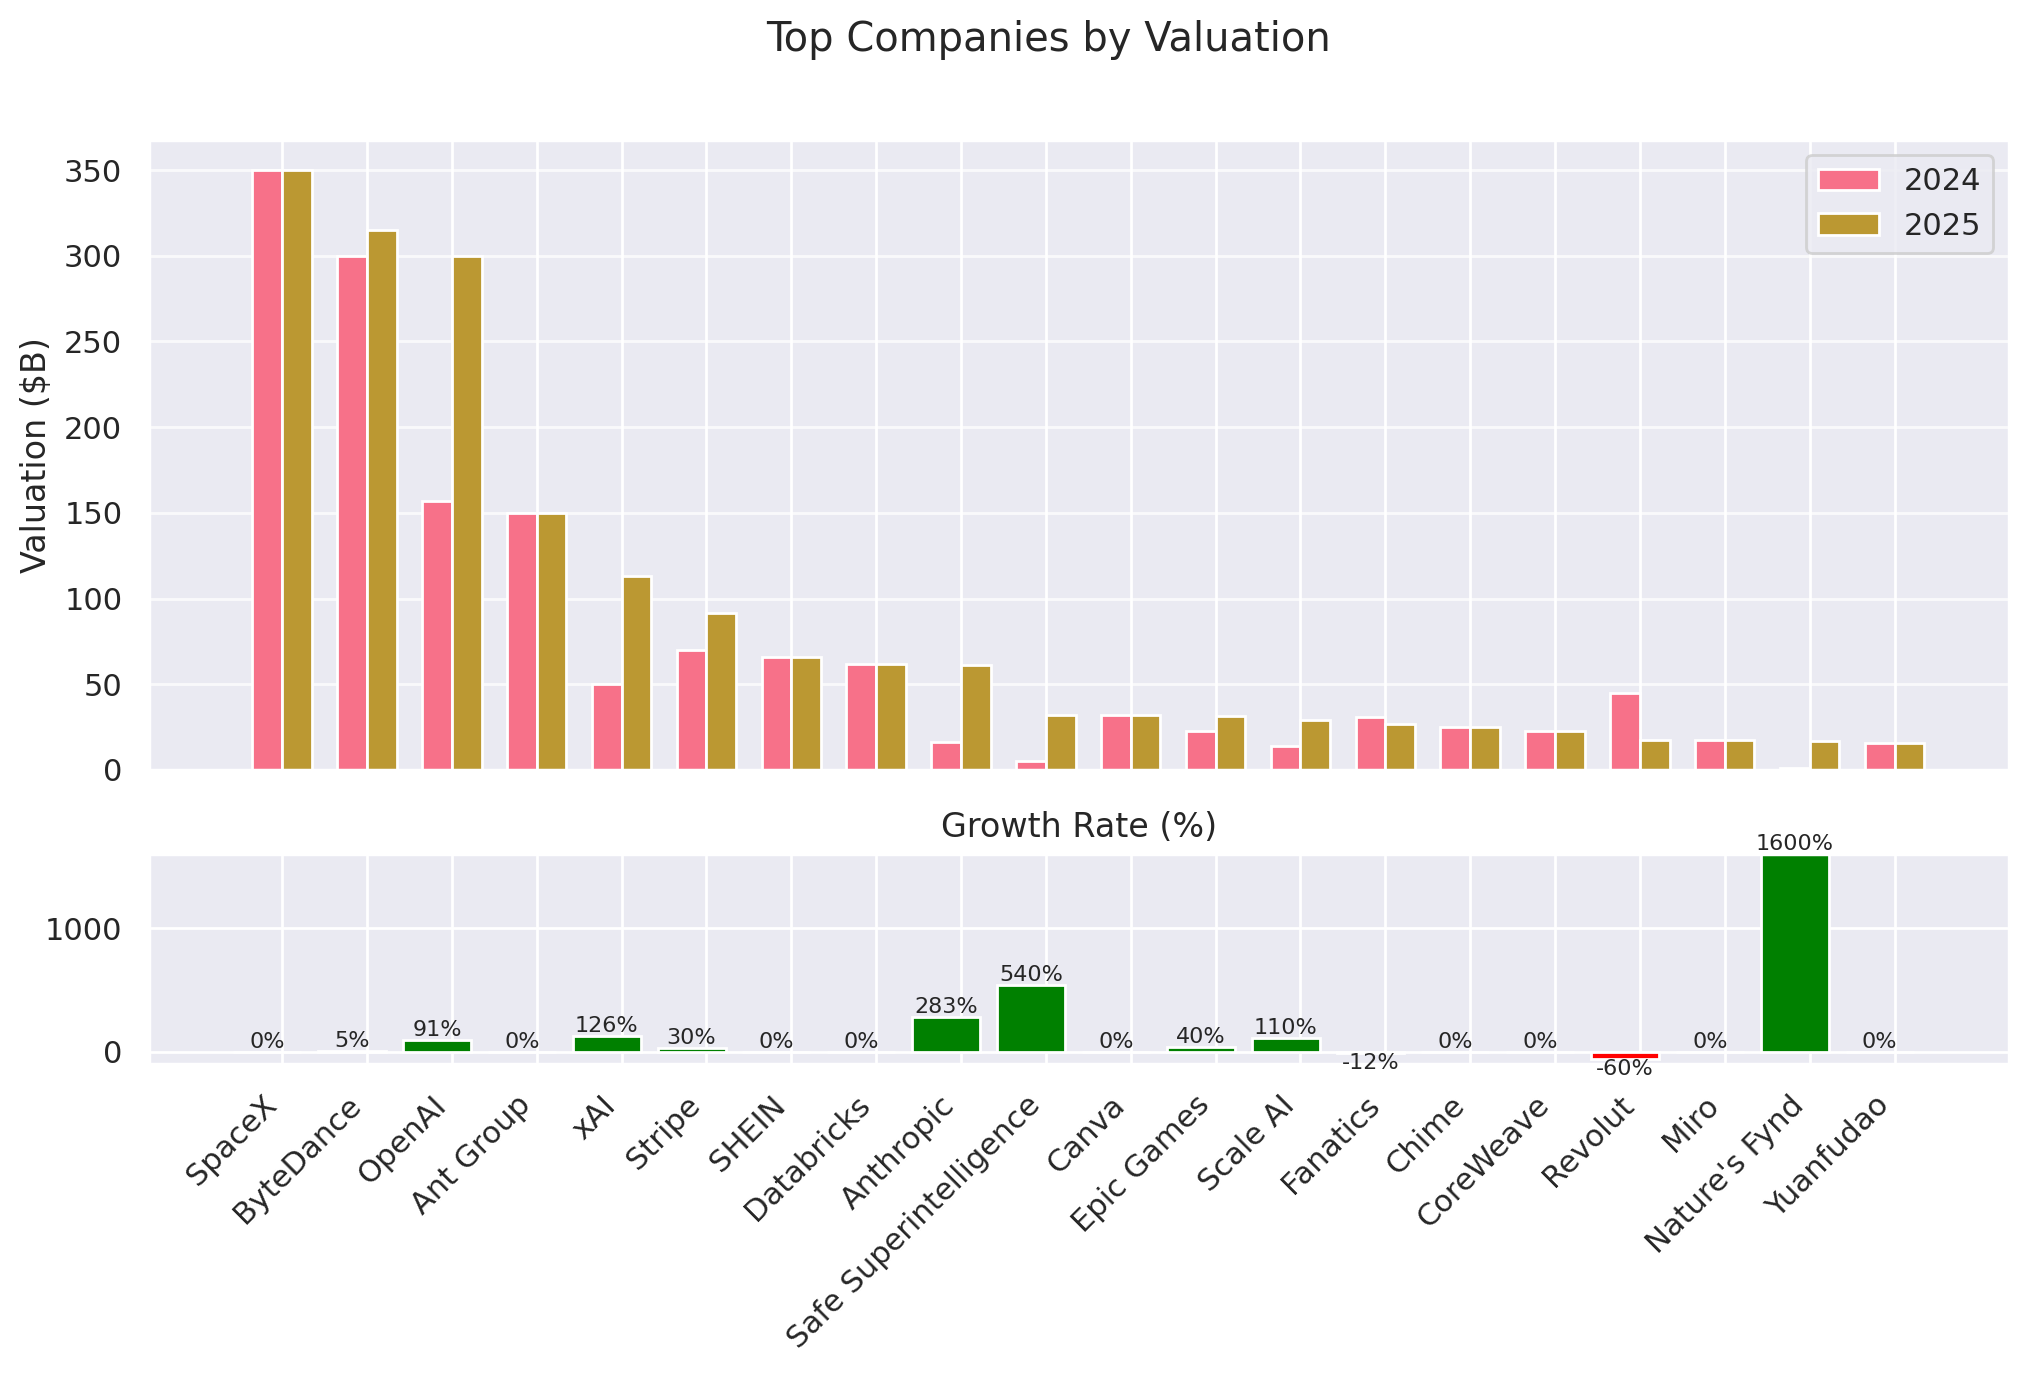

#### Top Companies accross Different Industries

In [ ]:
_df = df.groupby('Industry')[['Company', 'Latest Valuation ($B)']].apply(lambda grp: grp.nlargest(3, 'Latest Valuation ($B)'))[['Company', 'Latest Valuation ($B)']]
_df.index = _df.index.droplevel(1)
_df = _df.groupby(level=0).apply(lambda x: ', '.join(x['Company'])).reset_index(name='Companies')
_df


|     | Industry                   | Companies                                   |
|-----|----------------------------|---------------------------------------------|
| 0   | Consumer & Retail          | xAI, Stripe, Safe Superintelligence         |
| 1   | Enterprise Tech            | SpaceX, ByteDance, Anthropic                |
| 2   | Financial Services         | Ant Group, SHEIN, Epic Games                |
| 3   | Healthcare & Life Sciences | Canva, CoreWeave, Miro                      |
| 4   | Industrials                | OpenAI, Databricks, Discord                 |
| 5   | Insurance                  | Revolut, Gusto, Ramp                        |
| 6   | Media & Entertainment      | Nature's Fynd, Xingsheng Selected, Talkdesk |

#### Top Companies accross Different Countries

In [ ]:
_df = df[df['Country'].isin(top_countries.index)]\
    .groupby('Country')[['Company', 'Latest Valuation ($B)']]\
    .apply(lambda grp: grp.nlargest(3, 'Latest Valuation ($B)'))[['Company', 'Latest Valuation ($B)']]
_df.index = _df.index.droplevel(1)
_df = _df.groupby(level=0)\
         .apply(lambda x: ', '.join(x['Company']))\
         .reset_index(name='Companies')
_df


|     | Country              | Companies                                                 |
|-----|----------------------|-----------------------------------------------------------|
| 0   | Australia            | Canva, Airwallex, Immutable                               |
| 1   | Austria              | BitPanda, GoStudent                                       |
| 2   | Belgium              | Collibra, Odoo, Deliverect                                |
| 3   | Brazil               | QuintoAndar, Nuvemshop, Wildlife Studios                  |
| 4   | Canada               | Dapper Labs, 1Password, Cohere                            |
| 5   | China                | ByteDance, Ant Group, Yuanfudao                           |
| 6   | Colombia             | Rappi, LifeMiles, Habi                                    |
| 7   | Denmark              | Pleo, Lunar                                               |
| 8   | Finland              | RELEX, Oura, Aiven                                        |
| 9   | France               | Doctolib, Mistral AI, Back Market                         |
| 10  | Germany              | Celonis, Personio, Helsing                                |
| 11  | Hong Kong            | Babel Finance, Trendy Group International, HashKeyHashKey |
| 12  | India                | BYJU's, OYO Rooms, Dream11                                |
| 13  | Indonesia            | Traveloka, Akulaku, eFishery                              |
| 14  | Ireland              | BrowserStack, Wayflyer, Flipdish                          |
| 15  | Israel               | StarkWare, Wiz, Moon Active                               |
| 16  | Japan                | Preferred Networks, SmartHR, Spiber                       |
| 17  | Lithuania            | Vinted, Nord Security                                     |
| 18  | Mexico               | Kavak, Bitso, Clip                                        |
| 19  | Netherlands          | Mollie, MessageBird, BackBase                             |
| 20  | Seychelles           | KuCoin, Scroll                                            |
| 21  | Singapore            | SHEIN, HyalRoute, Coda Payments                           |
| 22  | South Korea          | Toss, Yello Mobile, Kurly                                 |
| 23  | Spain                | Jobandtalent, Cabify, TravelPerk                          |
| 24  | Sweden               | Northvolt, Klarna, Kry                                    |
| 25  | Switzerland          | SonarSource, Nexthink, MindMaze                           |
| 26  | United Arab Emirates | Vista Global, Tabby, Kitopi                               |
| 27  | United Kingdom       | Revolut, Global Switch, Checkout.com                      |
| 28  | United States        | SpaceX, OpenAI, xAI                                       |
| 29  | Vietnam              | Sky Mavis, MoMo                                           |

#### Top Companies accross Different Sectors

In [ ]:
top_sectors = df.explode('Sector')\
        .groupby('Sector')['Latest Valuation ($B)']\
        .sum()\
        .sort_values(ascending=False)\
        .head(30)

_df = df.explode('Sector')
_df = _df[_df['Sector'].isin(top_sectors.index)]\
    .groupby('Sector')[['Company', 'Latest Valuation ($B)']]\
    .apply(lambda grp: grp.nlargest(3, 'Latest Valuation ($B)'))[['Company', 'Latest Valuation ($B)']]
_df.index = _df.index.droplevel(1)
_df = _df.groupby(level=0)\
         .apply(lambda x: ', '.join(x['Company']))\
         .reset_index(name='Companies')
_df


|     | Sector                  | Companies                          |
|-----|-------------------------|------------------------------------|
| 0   | Aerospace               | SpaceX, Relativity Space           |
| 1   | Artificial Intelligence | OpenAI, xAI, Anthropic             |
| 2   | Batteries               | Northvolt                          |
| 3   | Blockchain              | Alchemy, Chainalysis, ConsenSys    |
| 4   | Collaborative Software  | Grammarly, Airtable                |
| 5   | Consumer Packaged Goods | Nature's Fynd                      |
| 6   | Cryptocurrency          | Ripple, KuCoin, Blockchain.com     |
| 7   | Cybersecurity           | Tanium, Wiz, OneTrust              |
| 8   | E-Commerce              | SHEIN, Fanatics, Gopuff            |
| 9   | Educational Technology  | Yuanfudao, Articulate, Unacademy   |
| 10  | Fantasy Sports          | Dream11, Sorare                    |
| 11  | Finance                 | Brex, Qonto, TradingView           |
| 12  | Financial Services      | Stripe, Chime, Airwallex           |
| 13  | Financial Technology    | Revolut, Plaid, GoodLeap           |
| 14  | Graphic Design          | Canva, PicsArt                     |
| 15  | Health Technology       | Ro, Commure, Alan                  |
| 16  | Healthcare              | Devoted Health, Noom, Hinge Health |
| 17  | Internet                | ByteDance, Automattic, InMobi      |
| 18  | Logistics               | Flexport, Zipline, Cart.com        |
| 19  | Marketplace             | Chehaoduo, Kavak, Back Market      |
| 20  | Retail                  | HEYTEA, Lenskart, Away             |
| 21  | Robotics                | Nuro, CMR Surgical, Exotec         |
| 22  | Self-Driving Cars       | ZongMu Technology                  |
| 23  | Software                | Databricks, Miro, Discord          |
| 24  | Software As A Service   | Talkdesk, ContentSquare, Postman   |
| 25  | Software Development    | OutSystems, Unqork, Lightricks     |
| 26  | Technology              | MEGVII, MURAL, Workato             |
| 27  | Transportation          | Bolt, Rappi, Hello TransTech       |
| 28  | Video Games             | Epic Games, Niantic, Sky Mavis     |
| 29  | Workforce Management    | Rippling, Papaya Global, Workrise  |

### Most-Funded Companies

In [ ]:
df_filtered = df[df['Funding ($M)']>2000].sort_values(by='Funding ($M)', ascending=False).head(30)


In [ ]:
plt.subplots(figsize=(12, 8))
ax = sns.barplot(df_filtered, y='Company', x='Funding ($M)', hue='Company')
for i in ax.containers:
    ax.bar_label(i)
plt.suptitle('Companies Received Most Funding')
plt.xlabel('Amount ($M)')
plt.grid(axis='x', alpha=0.75)
plt.show()


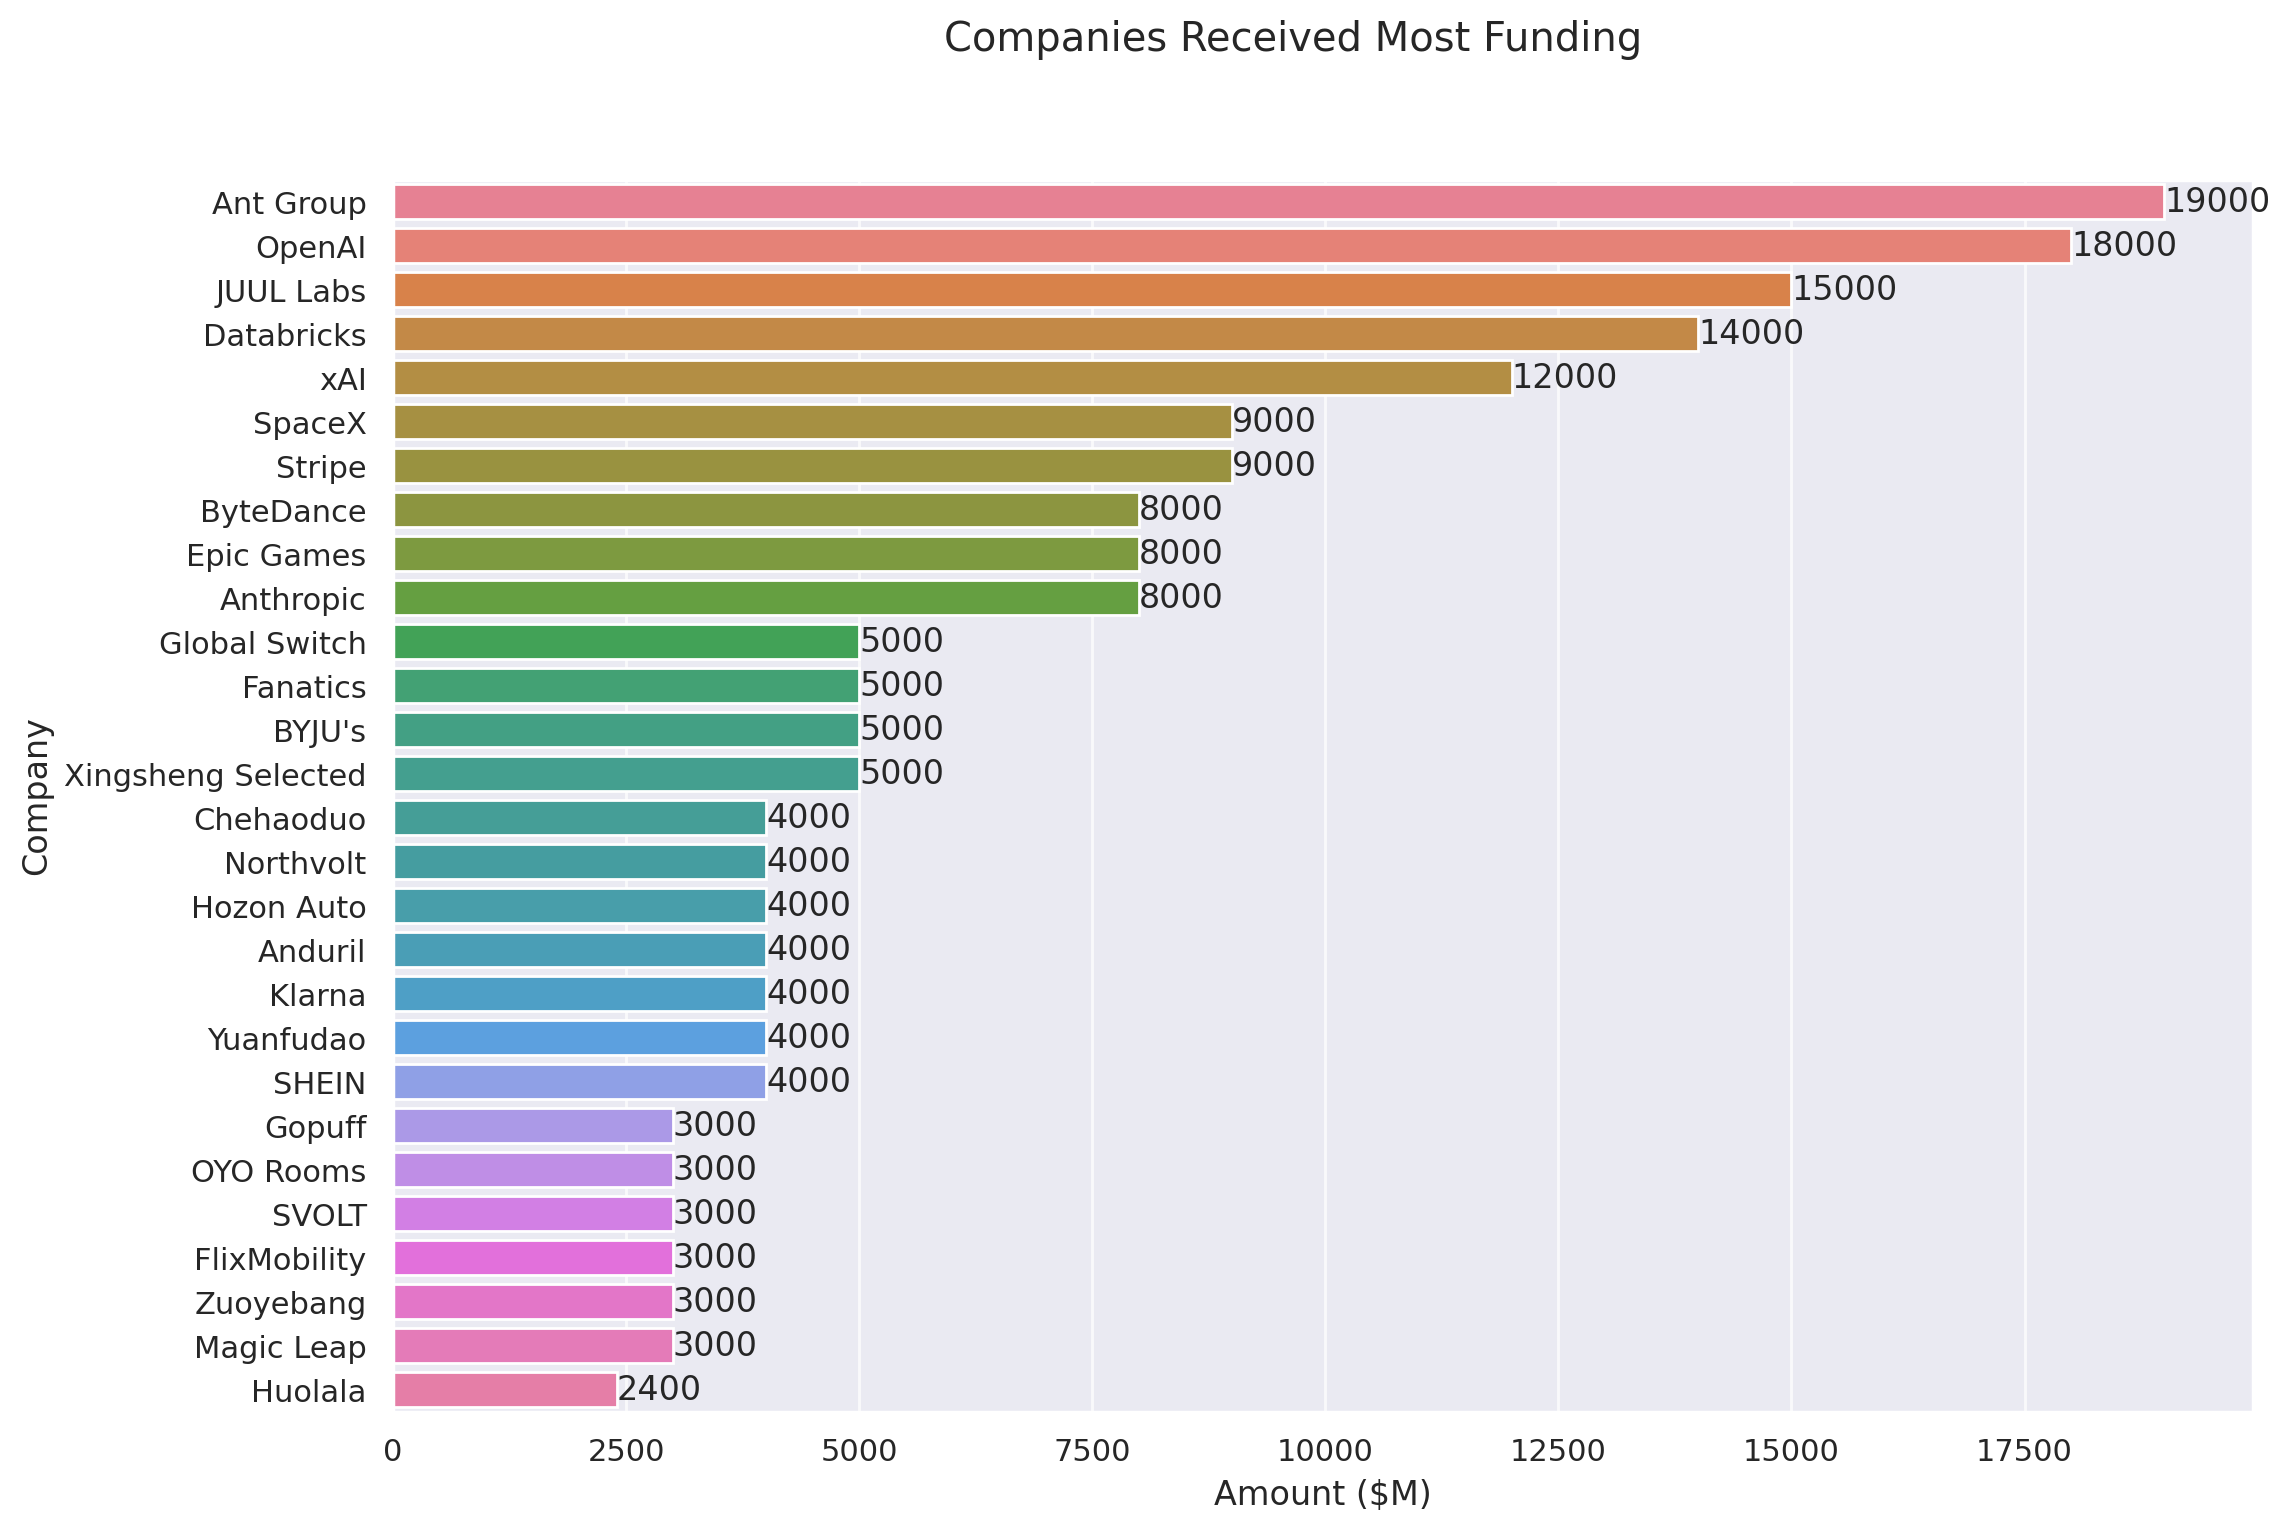

### Distribution of Valuation by Companies

In [ ]:
# Define the bins for valuation ranges
# bins = [0, 1, 1.5, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 200, 300, 400]
# labels =  [f'{a}-{b}' for a, b in zip(bins[:-1], bins[1:])]
# cuts = pd.cut(df['Valuation ($B)'], bins=bins, labels=labels)

cuts = pd.qcut(df['Latest Valuation ($B)'], 50, duplicates='drop')

# Count the number of companies in each bin
distribution = cuts.value_counts().sort_index()

# Plot the Bar Chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=distribution.index,
                 y=distribution.values, hue=distribution.values)
for i in ax.containers:
    ax.bar_label(i)
plt.suptitle('Distribution of Valuations by Companies')
plt.xlabel('Valuation ($B)')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.show()


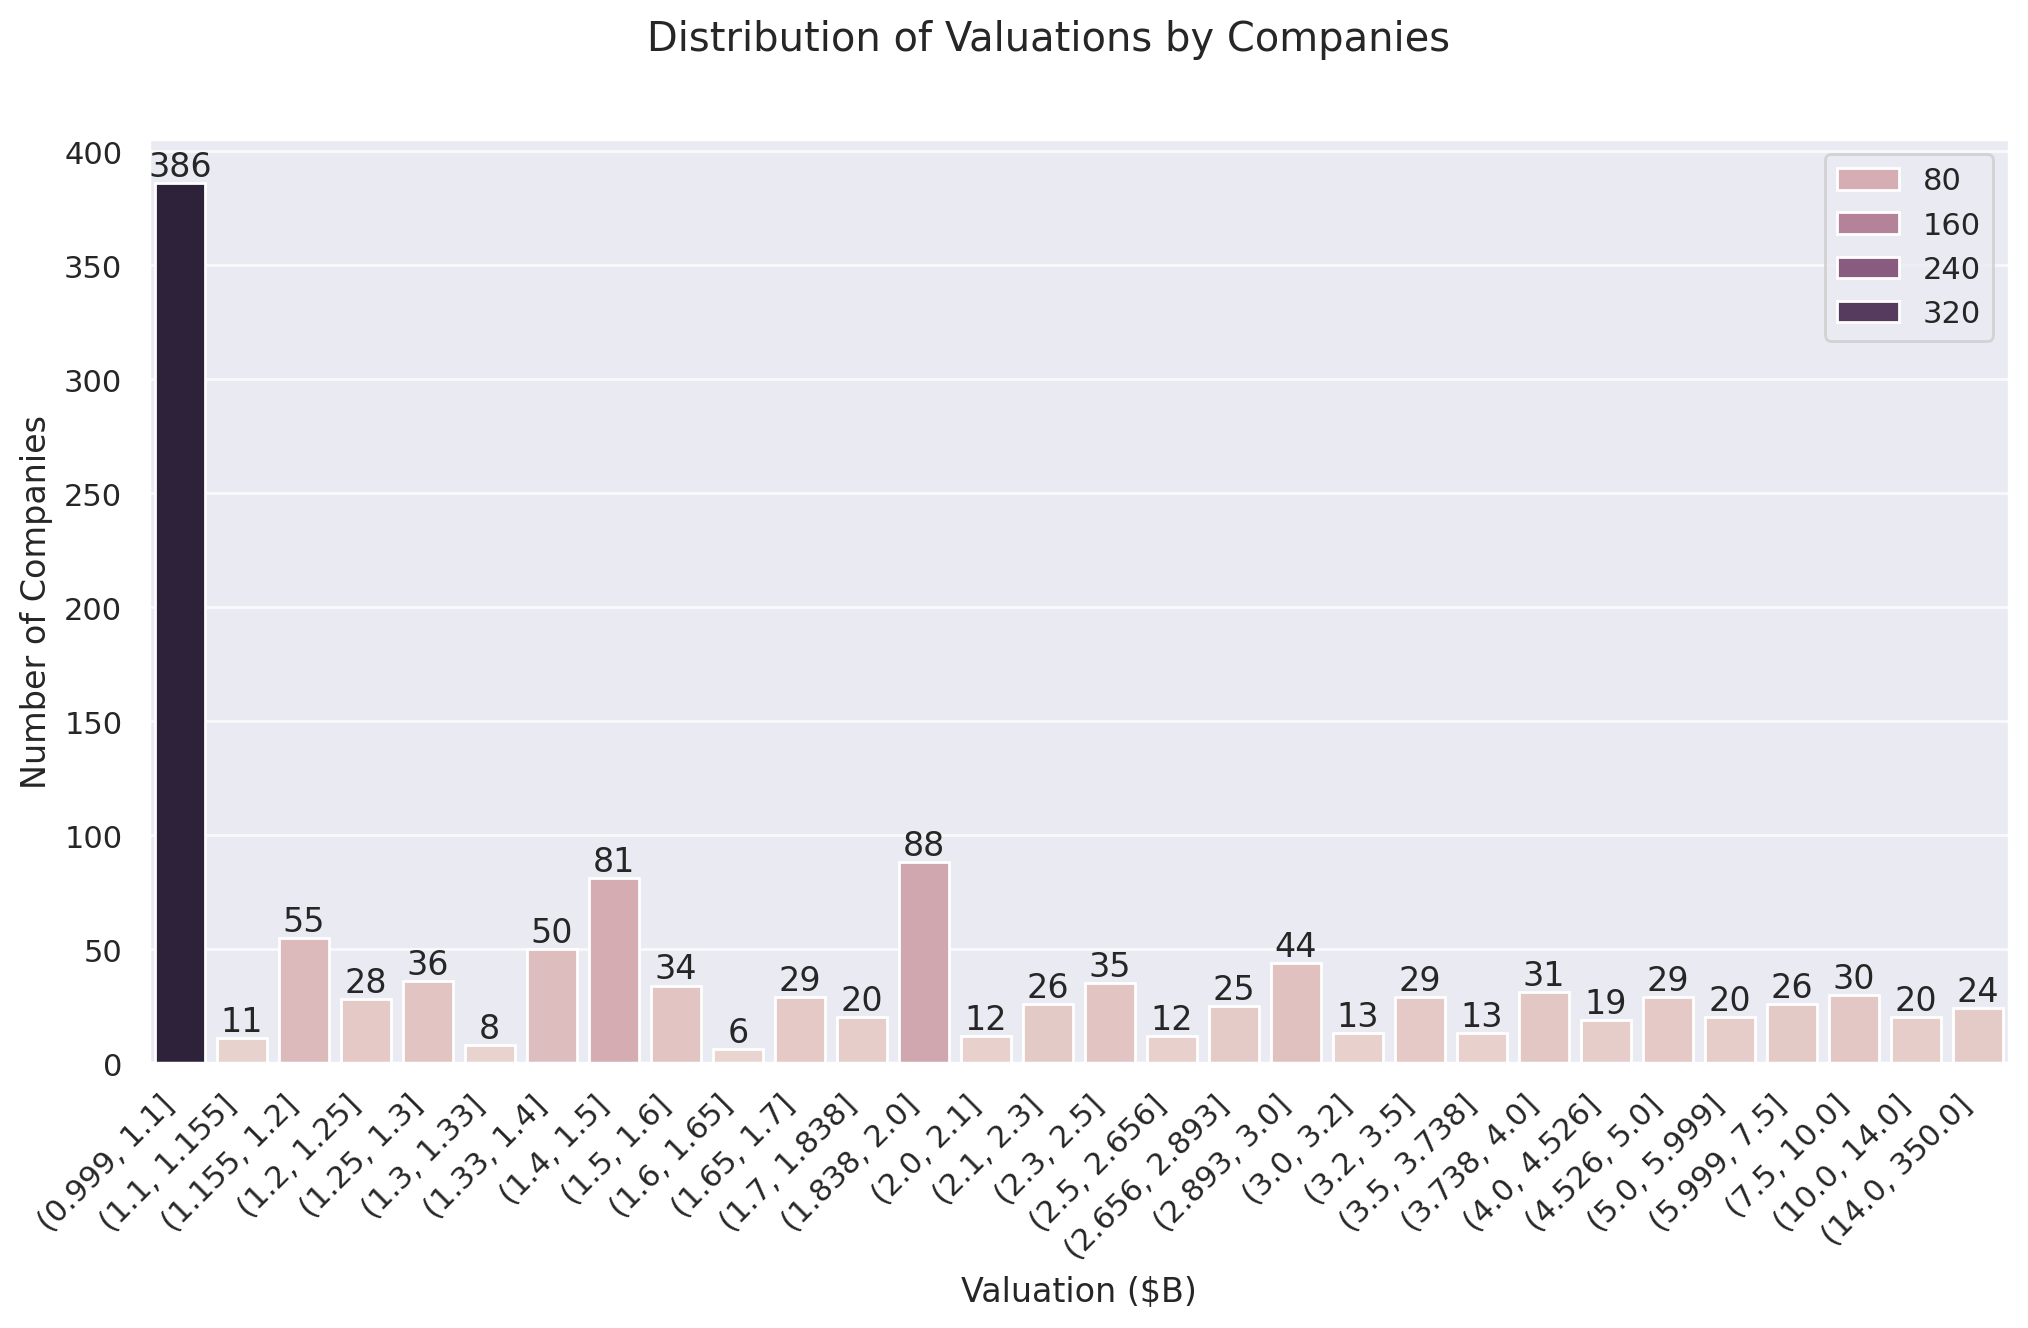

### Distribution of Equity Funding by Companies

In [ ]:
cuts = pd.qcut(df['Funding ($M)'], 30, duplicates='drop')

# Count the number of companies in each bin
distribution = cuts.value_counts().sort_index()

# Plot the Bar Chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=distribution.index,
                 y=distribution.values, hue=distribution.values)
for i in ax.containers:
    ax.bar_label(i)
plt.suptitle('Distribution of Equity Funding by Companies')
plt.xlabel('Equity Funding ($M)')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.show()


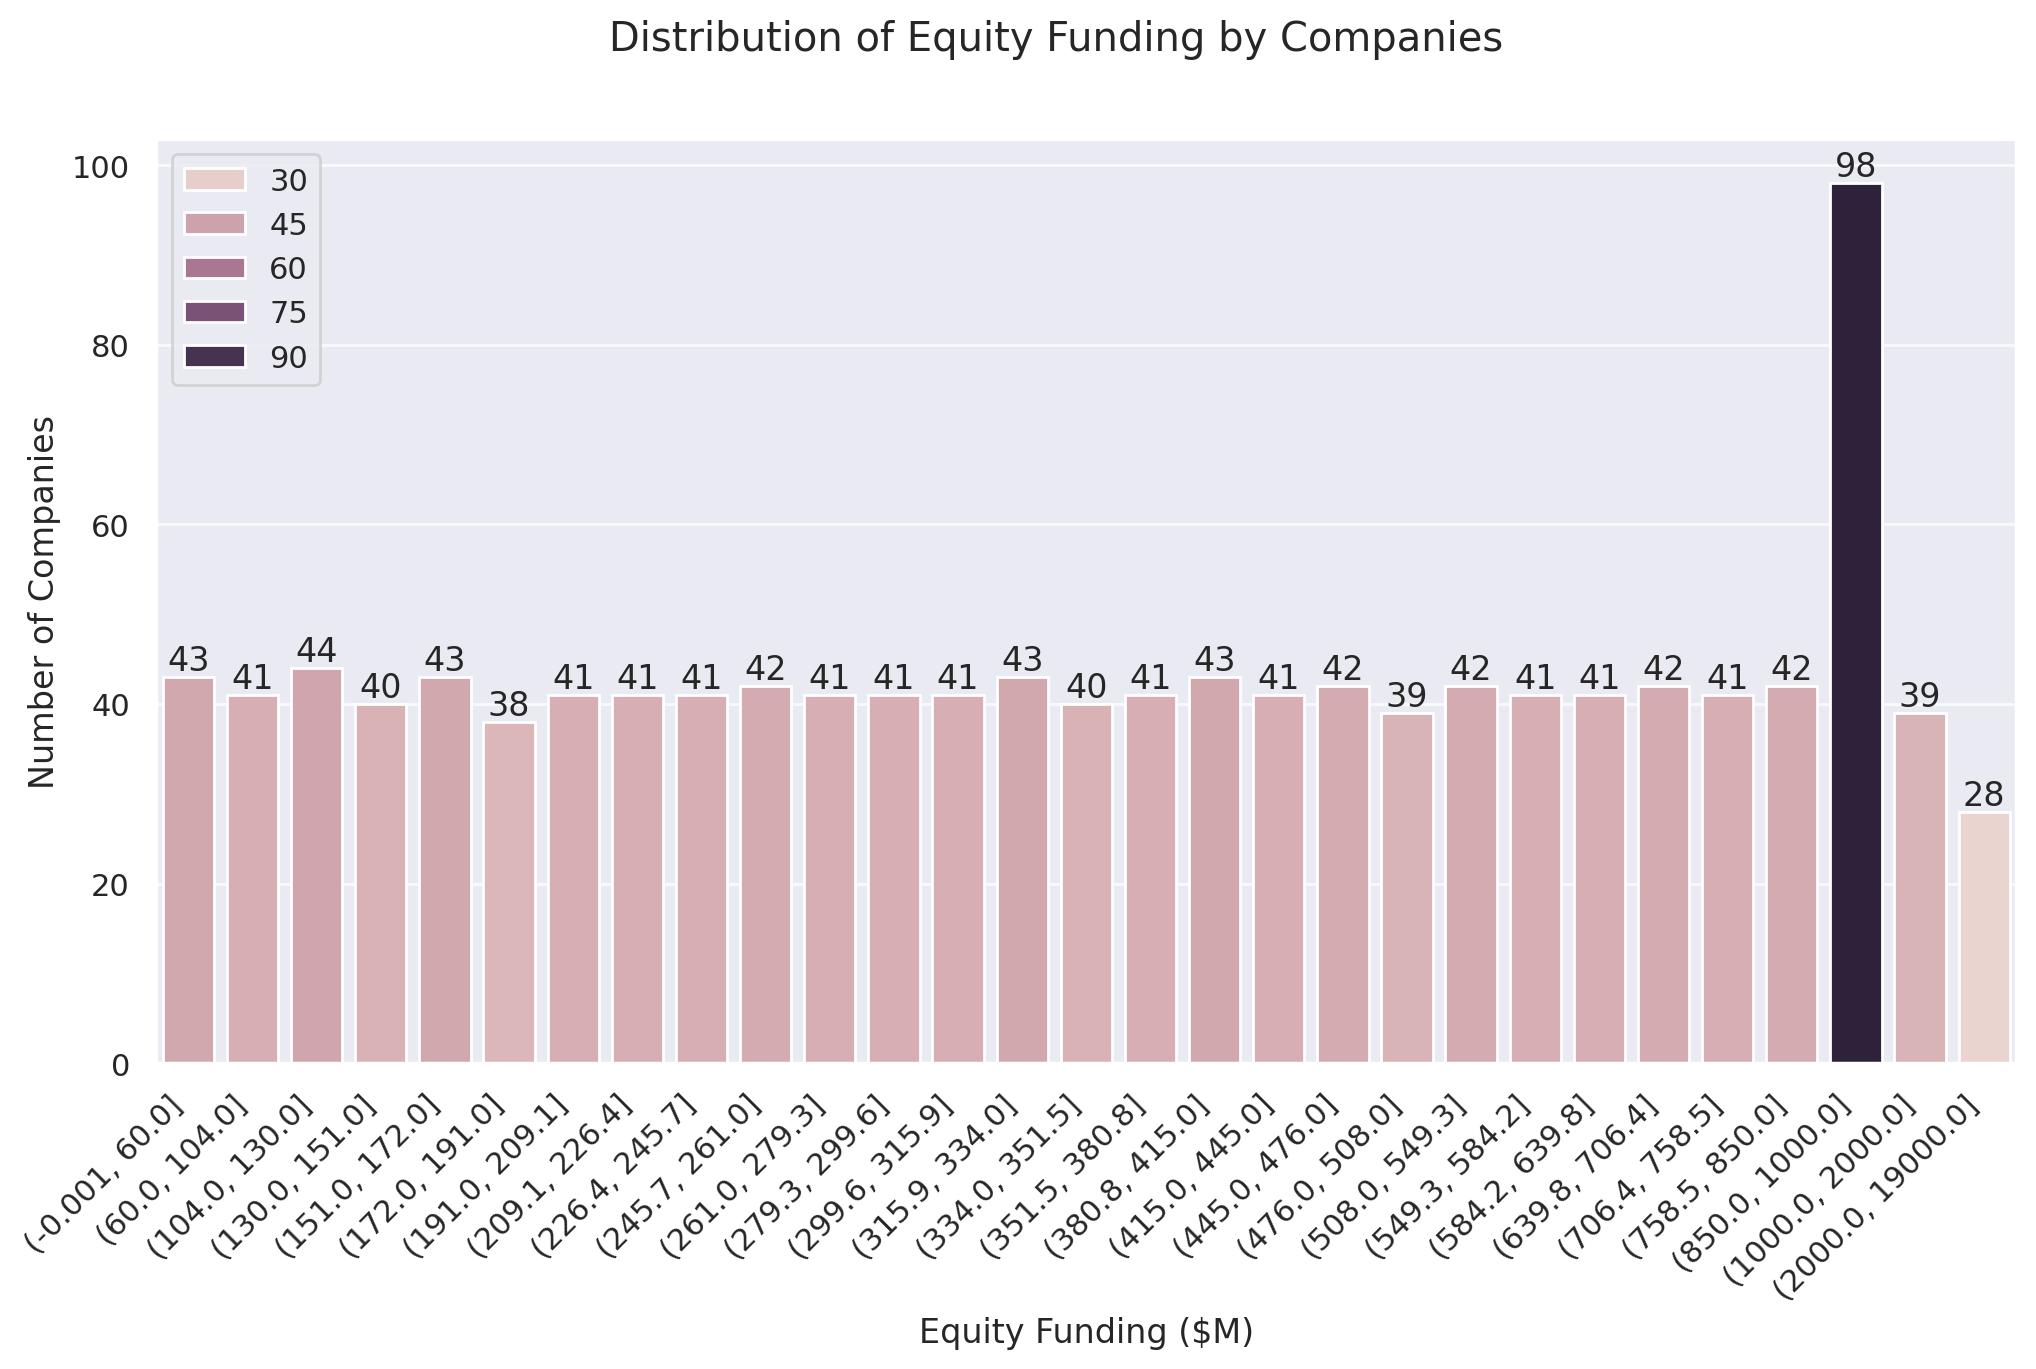

## Investor Analysis

### Top Investors

In [ ]:
def top_investors_agg(grp):
    return pd.Series({'count': grp['Company'].size,
                      'valuation': grp['Latest Valuation ($B)'].sum(),
                      'companies': ', '.join(grp.nlargest(3, 'Latest Valuation ($B)')['Company'])})
top_investors = df.explode('Investors')\
                  .groupby('Investors')[['Company', 'Latest Valuation ($B)']]\
                  .apply(top_investors_agg)\
                  .sort_values(by=['valuation', 'count'], ascending=False)\
                  .head(20)
top_investors


| Investors                 | count | valuation | companies                                             |
|---------------------------|-------|-----------|-------------------------------------------------------|
| RRE Ventures              | 5     | 397.6     | SpaceX, Fanatics, Gopuff                              |
| Founders Fund             | 24    | 363.01    | OpenAI, Scale AI, Articulate                          |
| Relay Ventures            | 2     | 358       | SpaceX, Flexport                                      |
| Opus Capital              | 2     | 355.68    | SpaceX, RELEX                                         |
| Breyer Capital            | 5     | 320.16    | ByteDance, Promasidor Holdings, Generate Biomedicines |
| Parkway VC                | 2     | 316       | ByteDance, EcoVadis                                   |
| TIME Ventures             | 1     | 315       | ByteDance                                             |
| Susa Ventures             | 2     | 304.9     | OpenAI, Meesho                                        |
| Dynamo VC                 | 1     | 300       | OpenAI                                                |
| Sequoia Capital China     | 40    | 183.61    | Stripe, Miro, Airwallex                               |
| Andreessen Horowitz       | 71    | 179.01    | Bitmain Technologies, Digital Currency Group, KuCoin  |
| Sequoia Capital           | 59    | 176.7     | Faire, Bitmain Technologies, Airtable                 |
| Alibaba Group             | 9     | 163.39    | Ant Group, Starburst, Redis                           |
| Accel                     | 65    | 161.91    | DJI Innovations, Checkout.com, Dapper Labs            |
| New Enterprise Associates | 26    | 157.5     | Anthropic, DJI Innovations, Celonis                   |
| The Carlyle Group         | 5     | 154.55    | Ant Group, Paradox, InCred                            |
| CPP Investments           | 1     | 150       | Ant Group                                             |
| Tiger Global Management   | 56    | 144.47    | Devoted Health, Ripple, OYO Rooms                     |
| General Atlantic          | 30    | 138.95    | Databricks, Chime, Ro                                 |
| Index Ventures            | 38    | 138.65    | Canva, Scale AI, Airtable                             |

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

sns.barplot(top_investors, ax=ax[0], y='valuation', x=top_investors.index, hue=top_investors.index, legend=False)
ax[0].set(ylabel=None, title='Valuations of Invested Companies ($B)')
for i in ax[0].containers:
    ax[0].bar_label(i, rotation=45, fontsize=8)

sns.barplot(top_investors, ax=ax[1], y='count', x=top_investors.index, hue=top_investors.index, legend=False)
for i in ax[1].containers:
    ax[1].bar_label(i, rotation=45, fontsize=8)

ax[1].set(ylabel=None, title='Number of Companies Invested')

plt.xticks(rotation=90)
plt.suptitle('Top Investors')
plt.show()


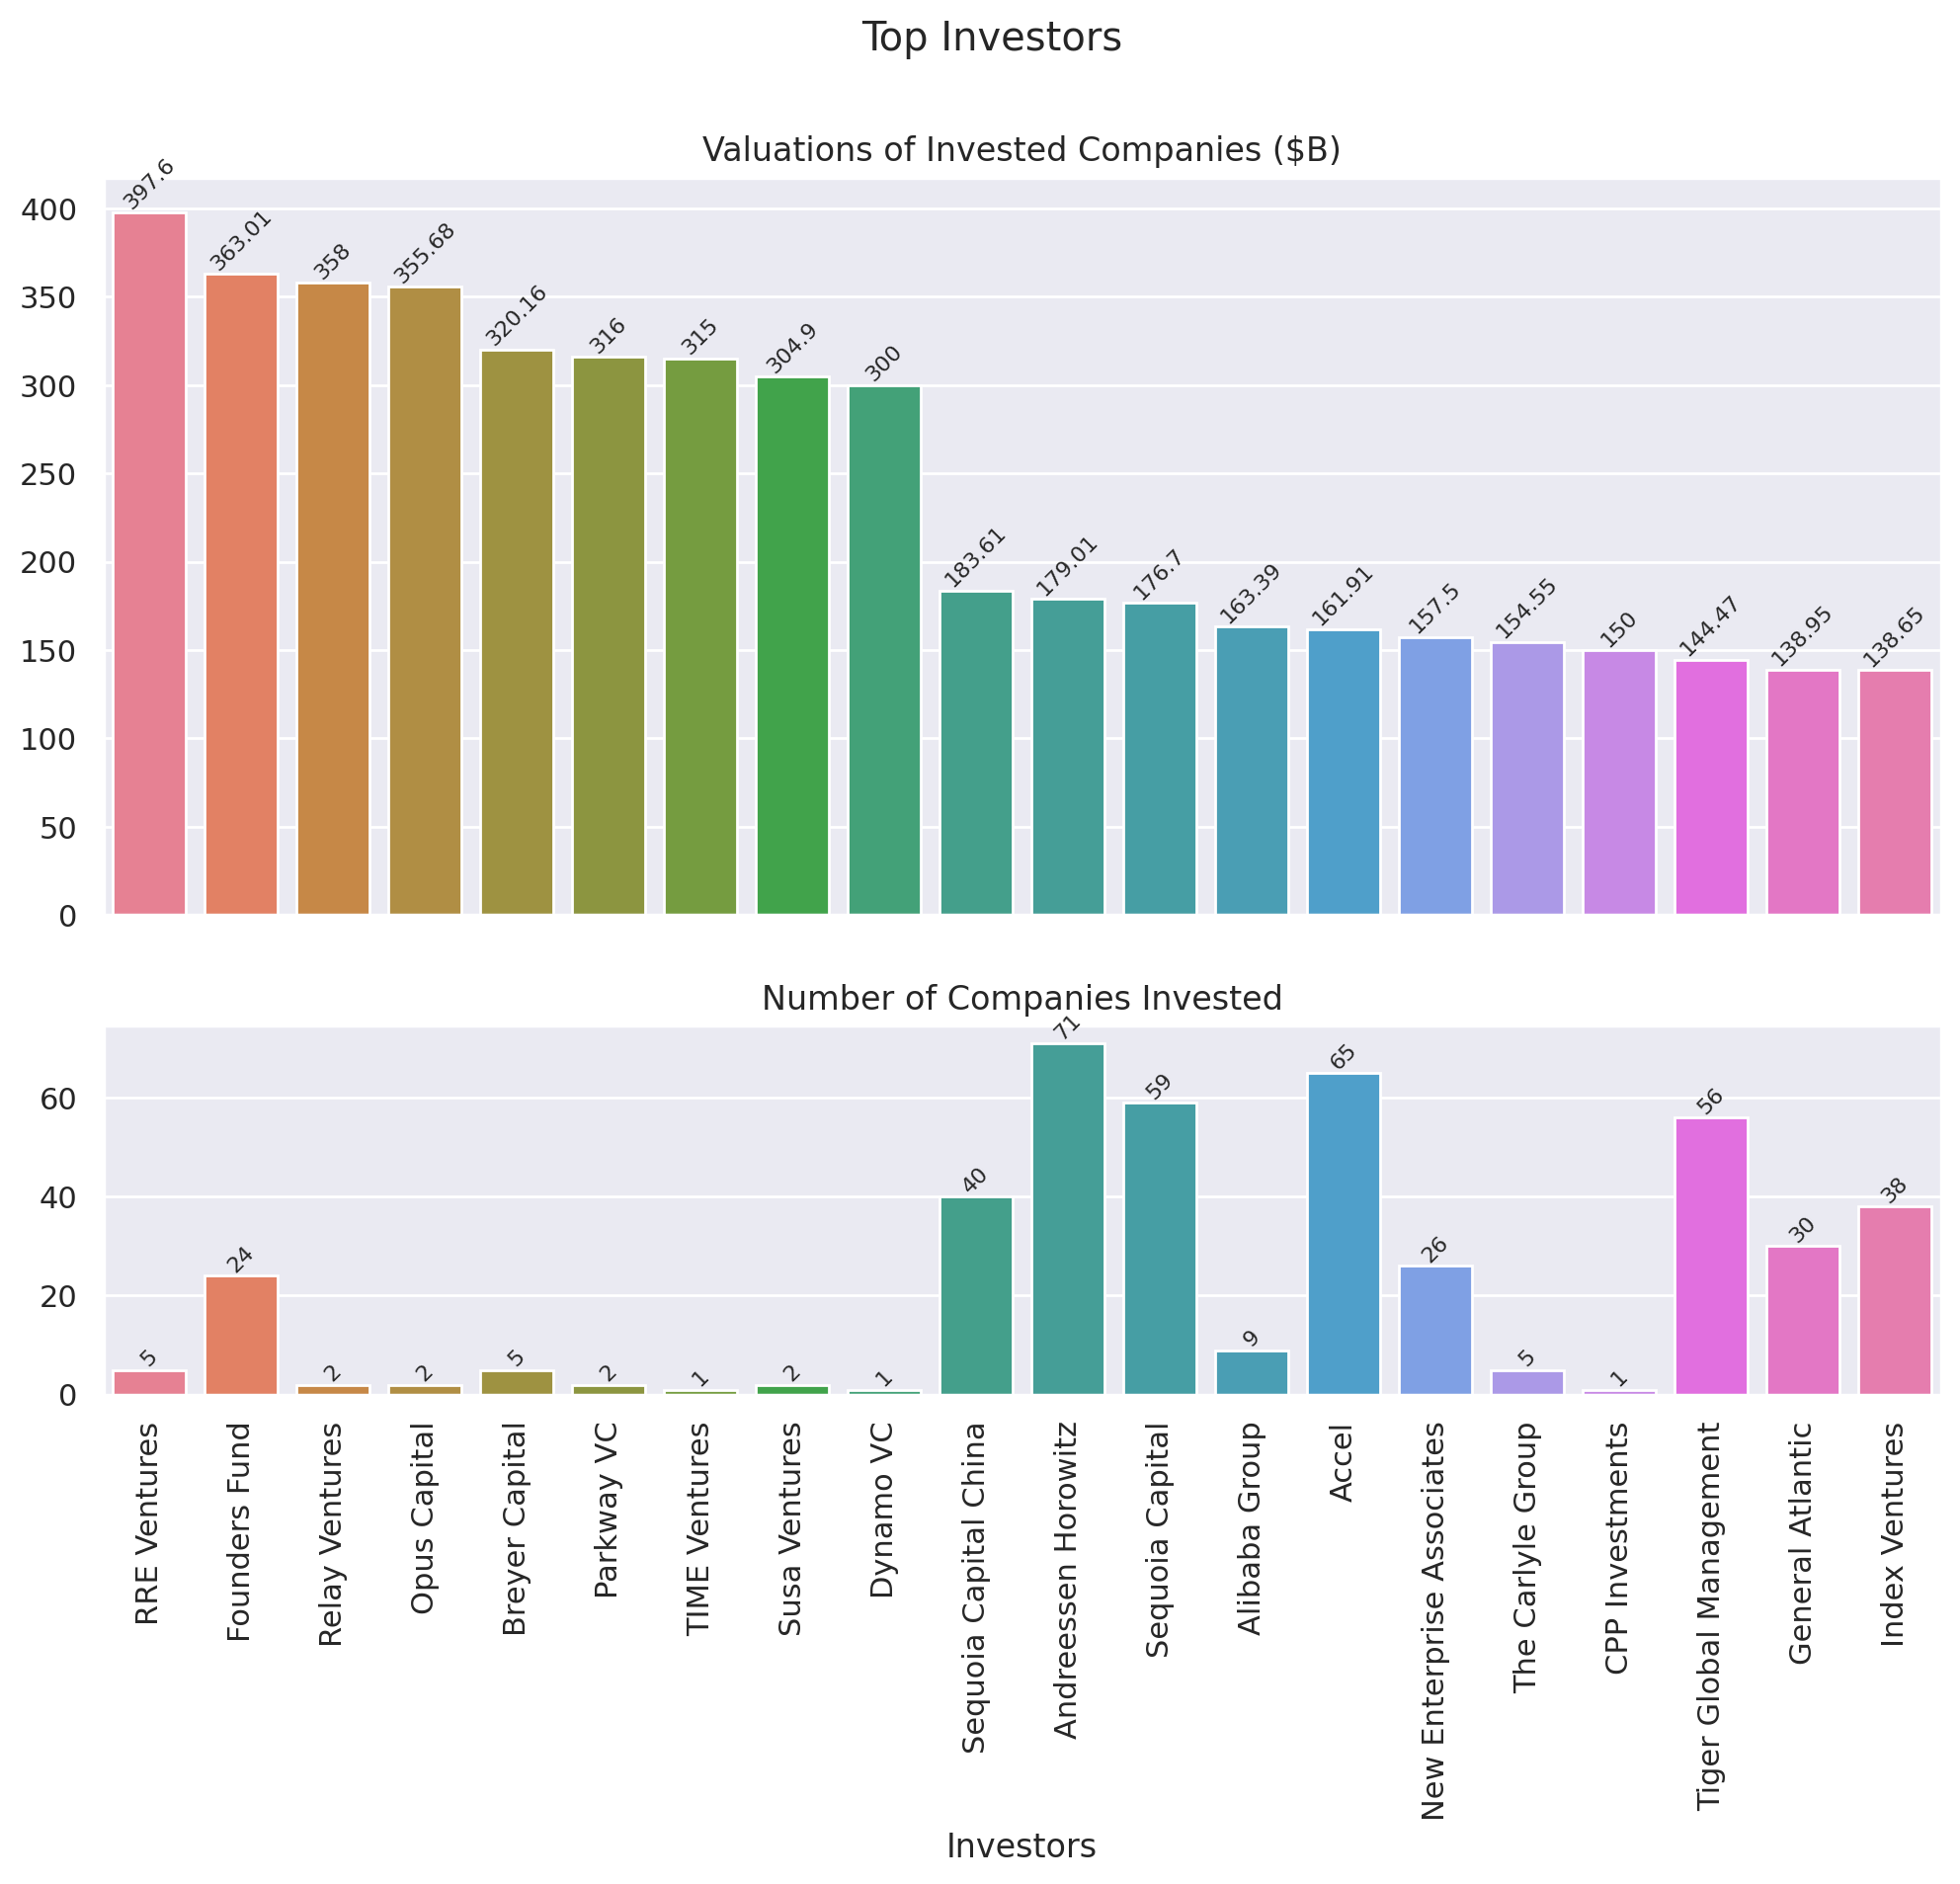

## Founder Analysis

### Top Founders

In [ ]:
top_founders = df.explode('Founder(s)')\
                  .groupby('Founder(s)')[['Latest Valuation ($B)', 'Company', 'Funding ($M)']]\
                  .agg(count=('Company', 'count'), companies=('Company', lambda x: ', '.join(x)), valuation=('Latest Valuation ($B)', 'sum'), funding=('Funding ($M)', 'sum'))\
                  .sort_values(by=['valuation', 'count'], ascending=False)\
                  .head(20)
print(top_founders)


``` example
                  count                        companies  valuation  funding
Founder(s)
Elon Musk             3  SpaceX, xAI, The Boring Company      468.7  21908.0
Ilya Sutskever        2   OpenAI, Safe Superintelligence      332.0  19000.0
Liang Rubo            1                        ByteDance      315.0   8000.0
Zhang Yiming          1                        ByteDance      315.0   8000.0
Greg Brockman         1                           OpenAI      300.0  18000.0
Sam Altman            1                           OpenAI      300.0  18000.0
John Collison         1                           Stripe       91.5   9000.0
Patrick               1                           Stripe       91.5   9000.0
Chris Xu              1                            SHEIN       66.0   4000.0
Ali Ghodsi            1                       Databricks       62.0  14000.0
Dario Amodei          1                        Anthropic       61.5   8000.0
Cameron Adams         1                            Canva       32.0    580.0
Clifford Obrecht      1                            Canva       32.0    580.0
Daniel Gross          1           Safe Superintelligence       32.0   1000.0
Daniel Levy           1           Safe Superintelligence       32.0   1000.0
Melanie Perkins       1                            Canva       32.0    580.0
Tim Sweeney           1                       Epic Games       31.5   8000.0
Alexandr Wang         1                         Scale AI       29.0   2000.0
Lucy Guo              1                         Scale AI       29.0   2000.0
Alan Trager           1                         Fanatics       27.0   5000.0
```

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

g = sns.barplot(top_founders, y='valuation', x=top_founders.index, hue=top_founders.index, legend=False, ax=ax[0])
g.set(ylabel='Company Valuations ($B)', xlabel='Founder')
for i in ax[0].containers:
    ax[0].bar_label(i, rotation=45, fontsize=8)

g = sns.barplot(top_founders, y='funding', x=top_founders.index, hue=top_founders.index, legend=False, ax=ax[1])
g.set(ylabel='Company Funding ($M)')
for i in ax[1].containers:
    ax[1].bar_label(i, rotation=45, fontsize=8)

plt.xticks(rotation=90)
plt.suptitle('Top Founders by Company Valuations')
plt.show()


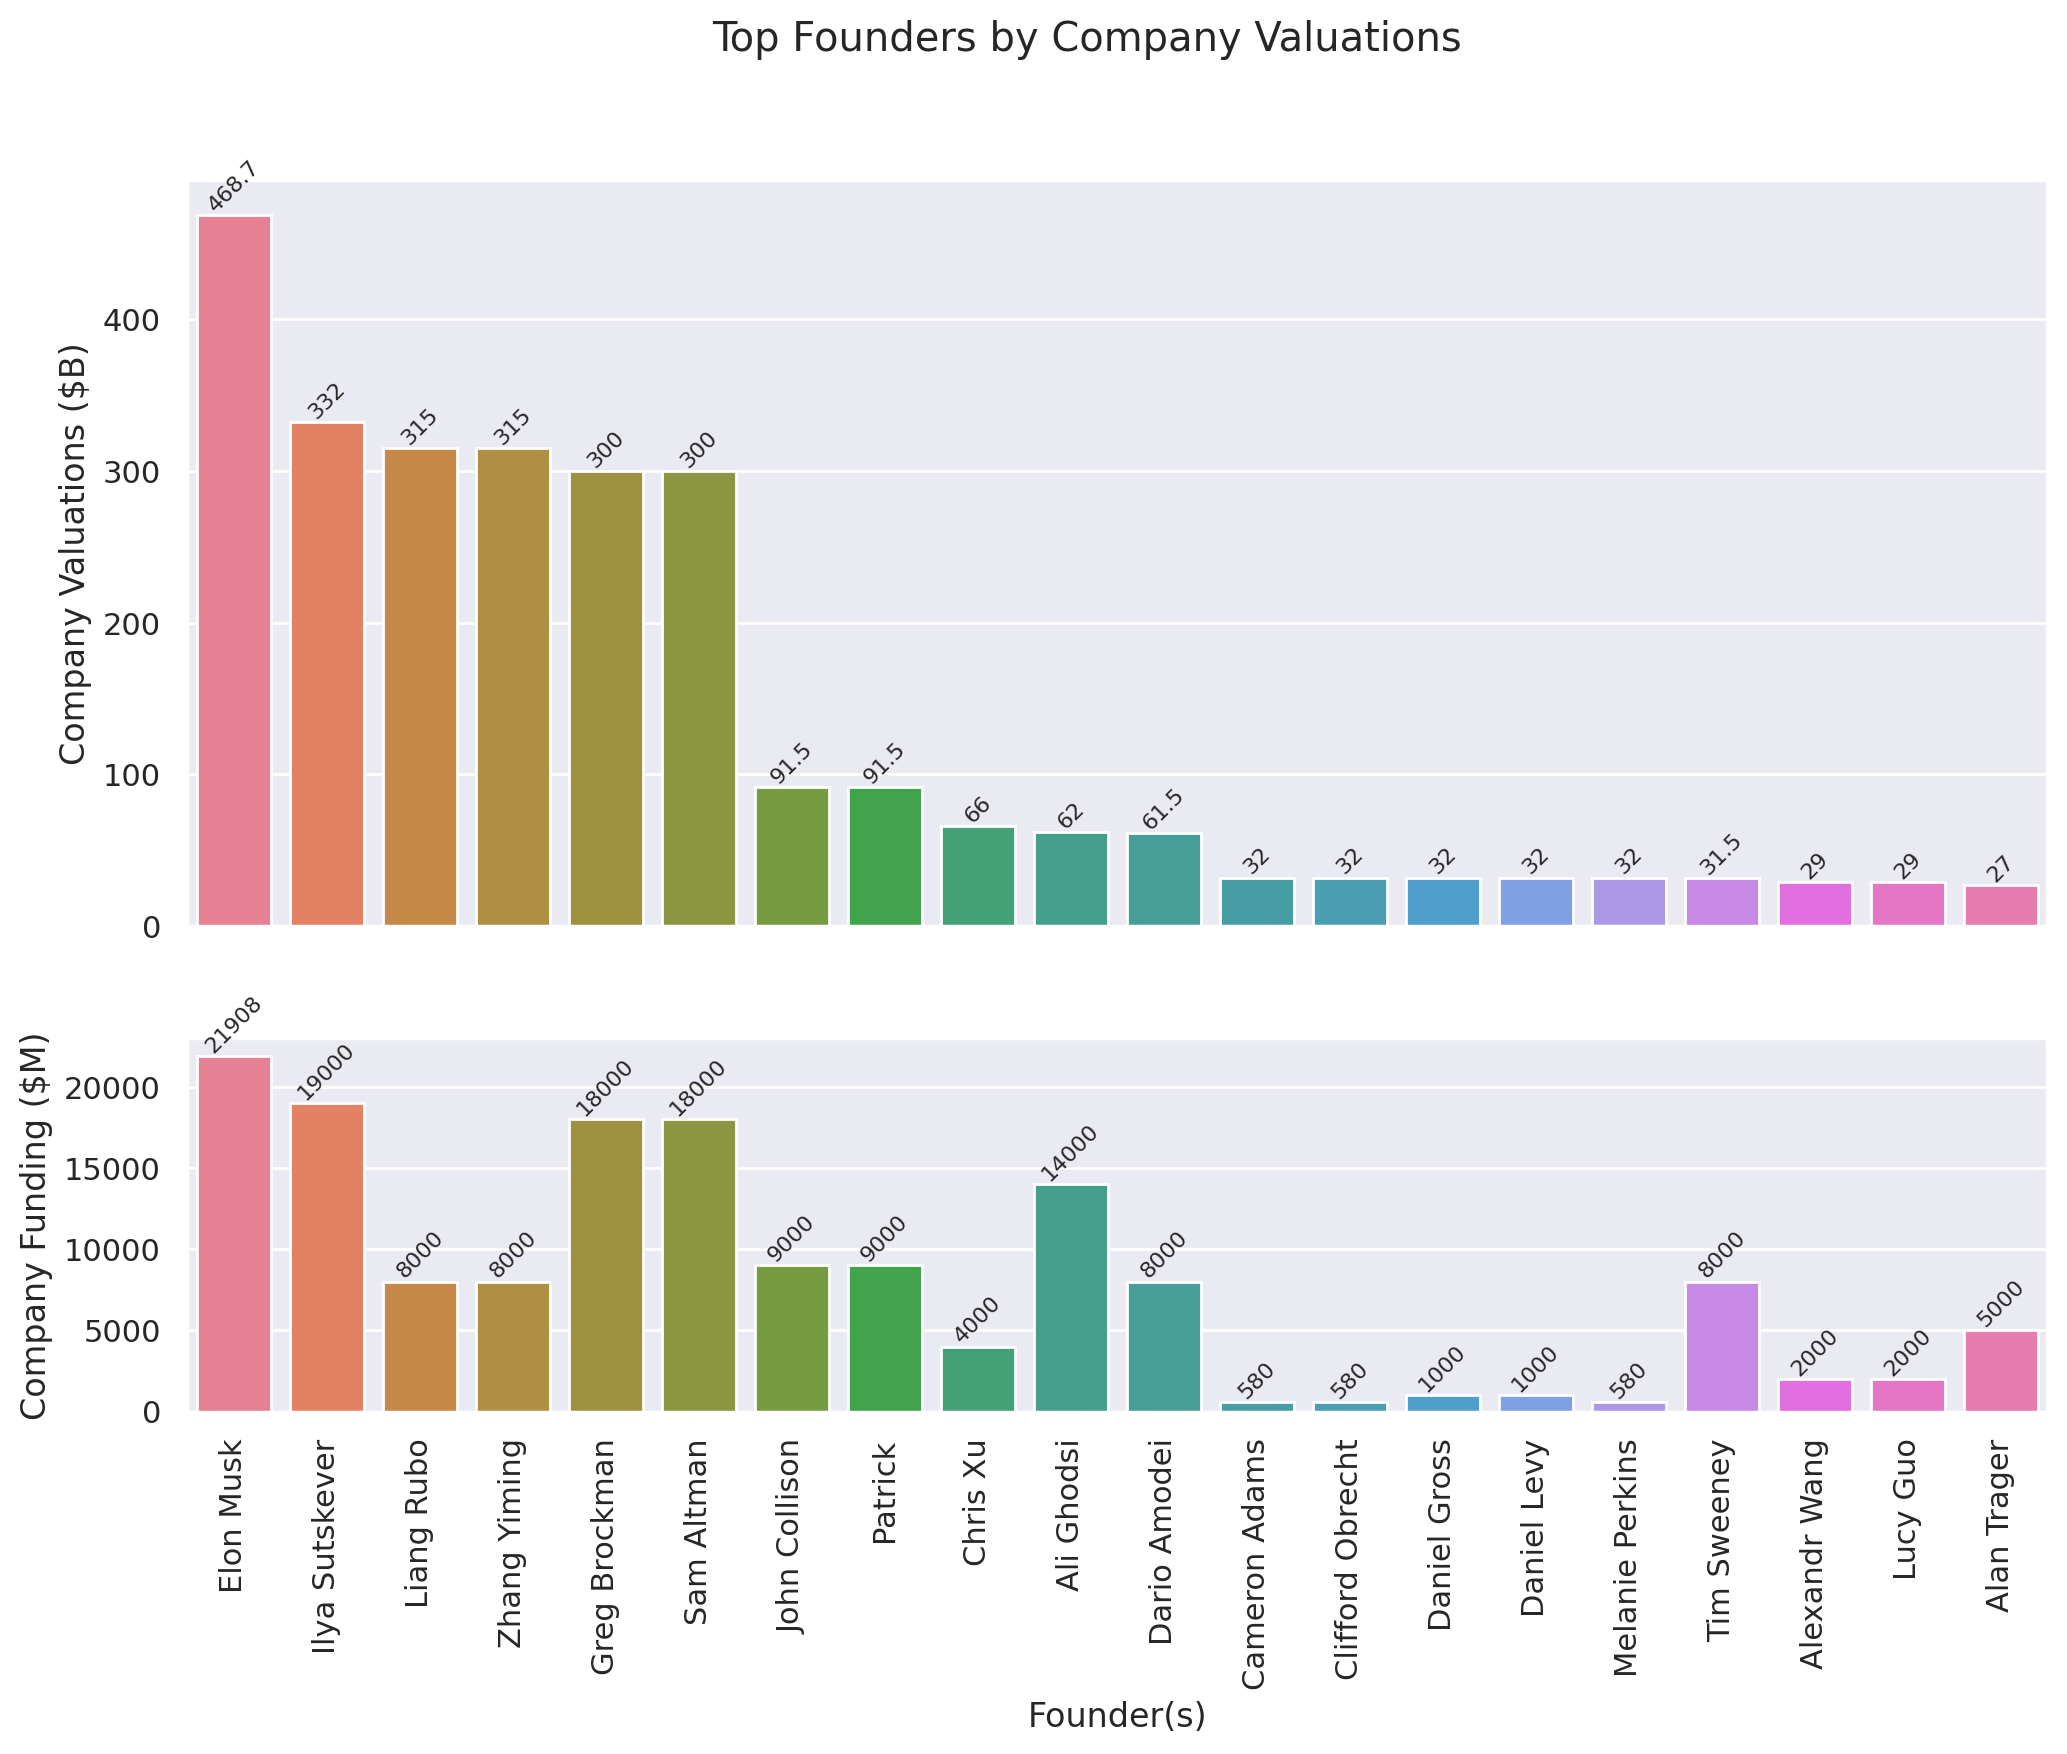

# Time-Based Analysis

## Unicorn Growth Over Time

In [ ]:
_df = df.groupby('Unicorn Year').size().reset_index(name='Count')
_df['Accumulated Count'] = _df['Count'].cumsum()
_df


|     | Unicorn Year | Count | Accumulated Count |
|-----|--------------|-------|-------------------|
| 0   | 2007         | 1     | 1                 |
| 1   | 2011         | 1     | 2                 |
| 2   | 2012         | 4     | 6                 |
| 3   | 2013         | 4     | 10                |
| 4   | 2014         | 9     | 19                |
| 5   | 2015         | 32    | 51                |
| 6   | 2016         | 17    | 68                |
| 7   | 2017         | 35    | 103               |
| 8   | 2018         | 82    | 185               |
| 9   | 2019         | 85    | 270               |
| 10  | 2020         | 91    | 361               |
| 11  | 2021         | 483   | 844               |
| 12  | 2022         | 251   | 1095              |
| 13  | 2023         | 67    | 1162              |
| 14  | 2024         | 78    | 1240              |

In [ ]:
plt.subplots(figsize=(12, 6))
sns.barplot(_df, x='Unicorn Year', y='Count', hue='Count')
plt.plot(_df['Accumulated Count'], marker='o', linestyle='dashed')
plt.suptitle('Unicorn Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Unicorns')
plt.grid(axis='y', alpha=0.7)
plt.show()


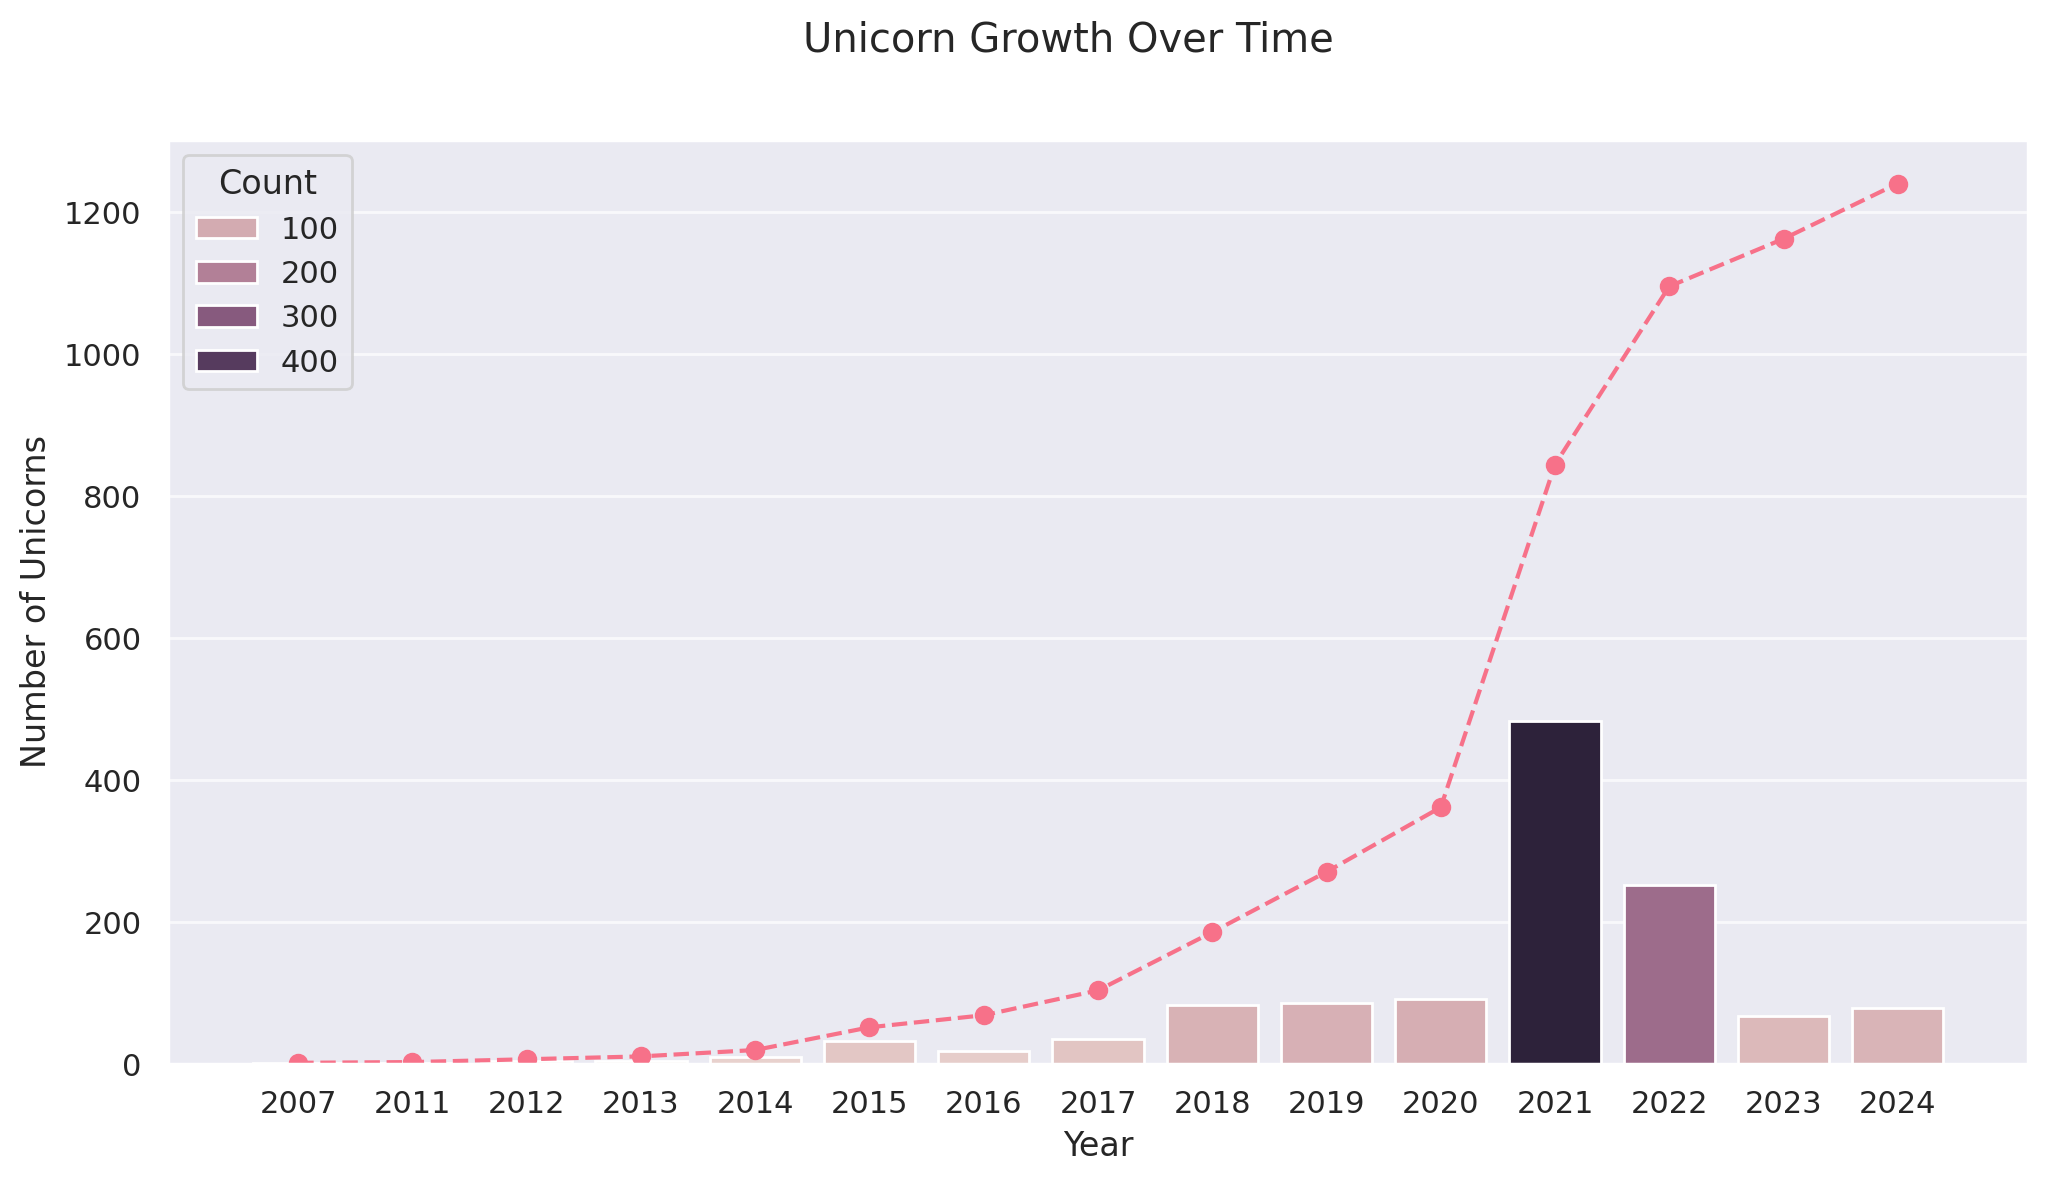

## Time to Unicorn

In [ ]:
# Calculate 5th and 95th percentiles
lower_bound = df['Years to Unicorn'].quantile(0.05)
upper_bound = df['Years to Unicorn'].quantile(0.95)
# Filter out values outside the 5th and 95th percentiles
df_filtered = df[(df['Years to Unicorn'] >= lower_bound) & (df['Years to Unicorn'] <= upper_bound)]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(df_filtered, x='Years to Unicorn', hue='Industry', bins=50, ax=ax, kde=True, alpha=.4)
ax.set(xlabel='Years', ylabel='Number of Companies')
plt.suptitle('Distribution of Time to Unicorn')
plt.grid(alpha=0.75)
plt.show()


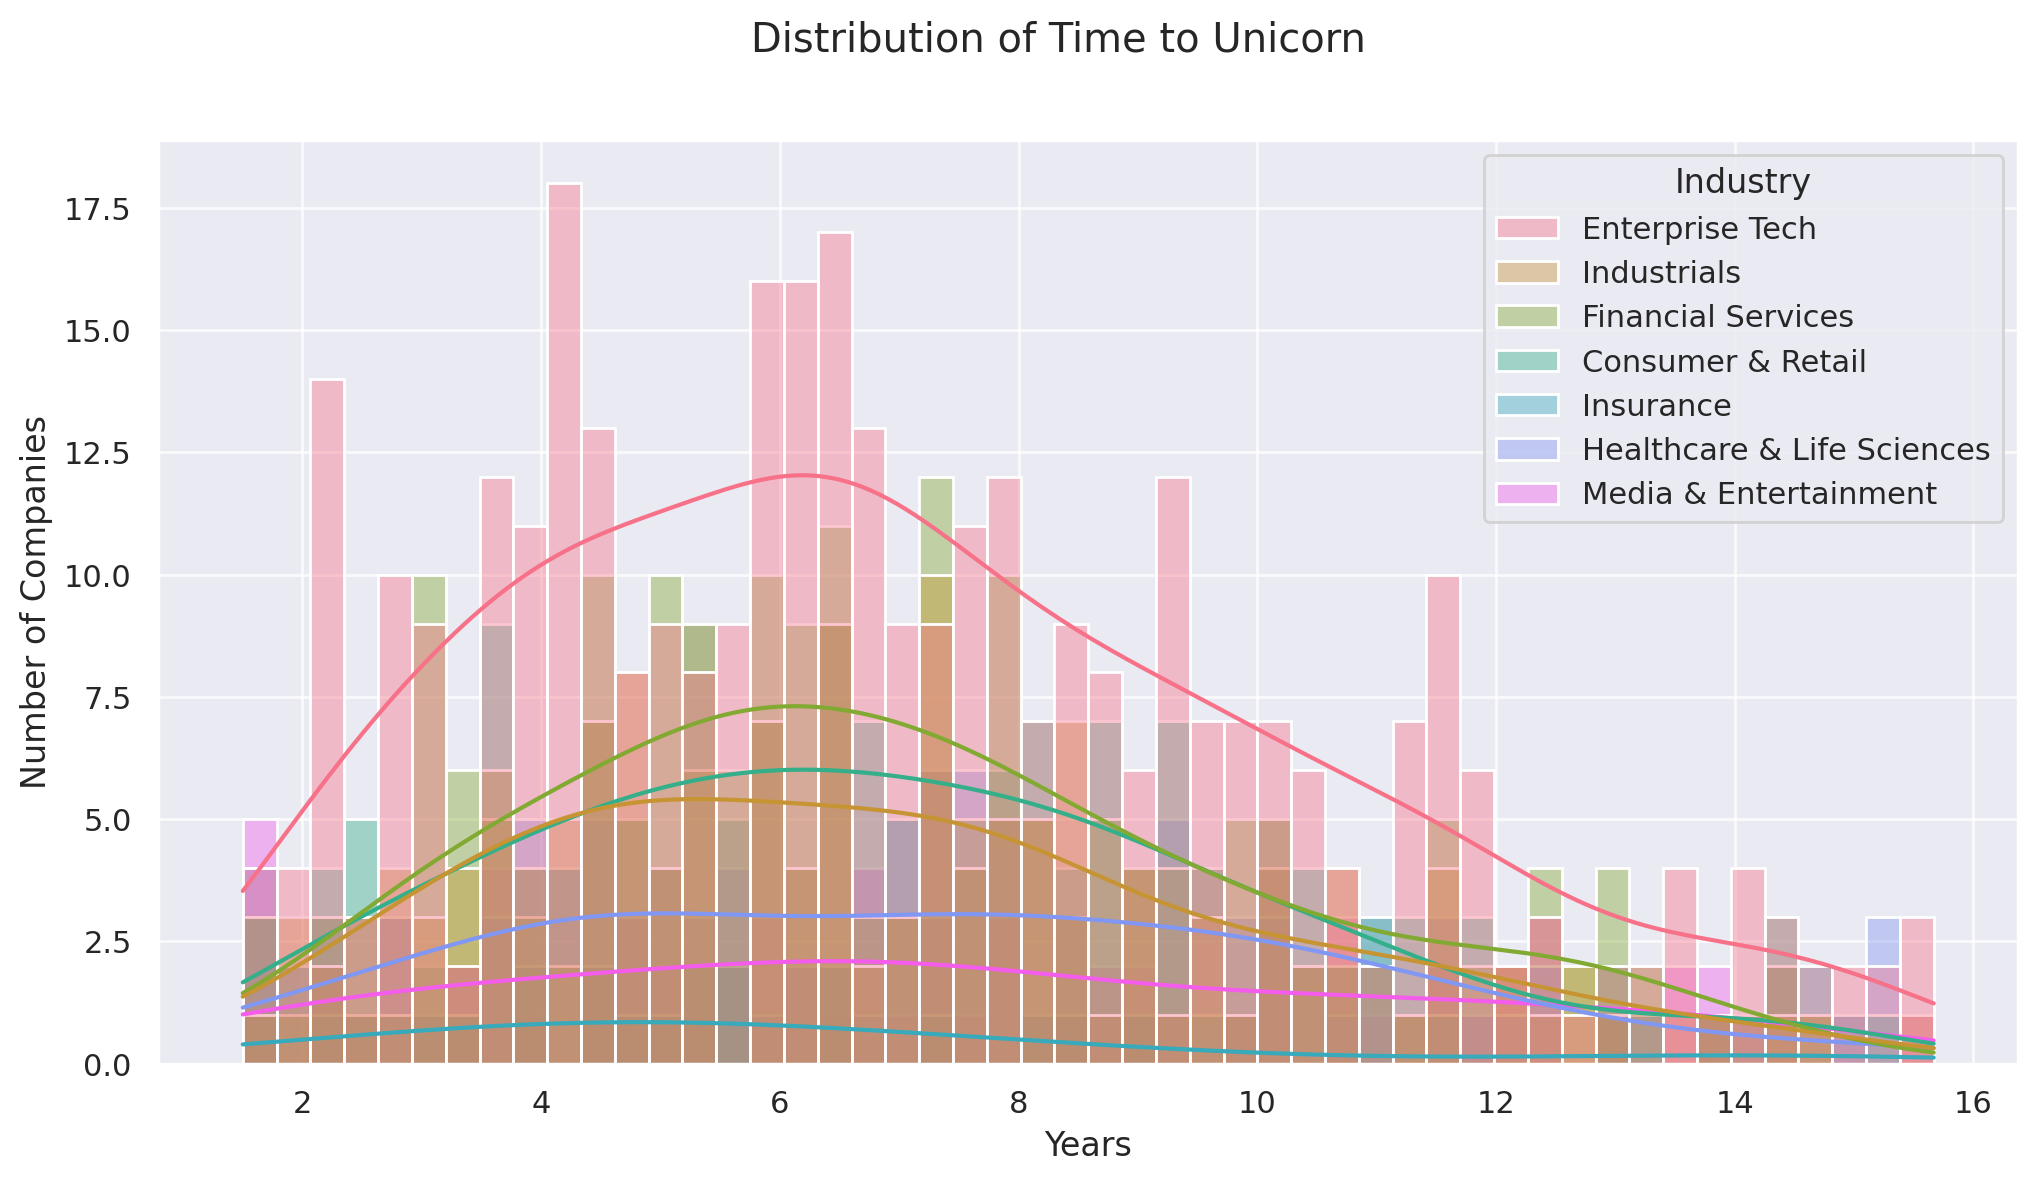

## Distribution of Valuations Over Time

In [ ]:
plt.subplots(figsize=(12, 6))
sns.scatterplot(df, x='Unicorn Date', y='Valuation ($B)', alpha=.6, hue='Industry')
plt.suptitle('Distribution of Valuations Over Time')
plt.xlabel('Date')
plt.ylabel('Amount ($B)')
plt.grid(axis='y', alpha=0.5)
plt.yscale('log')
plt.show()


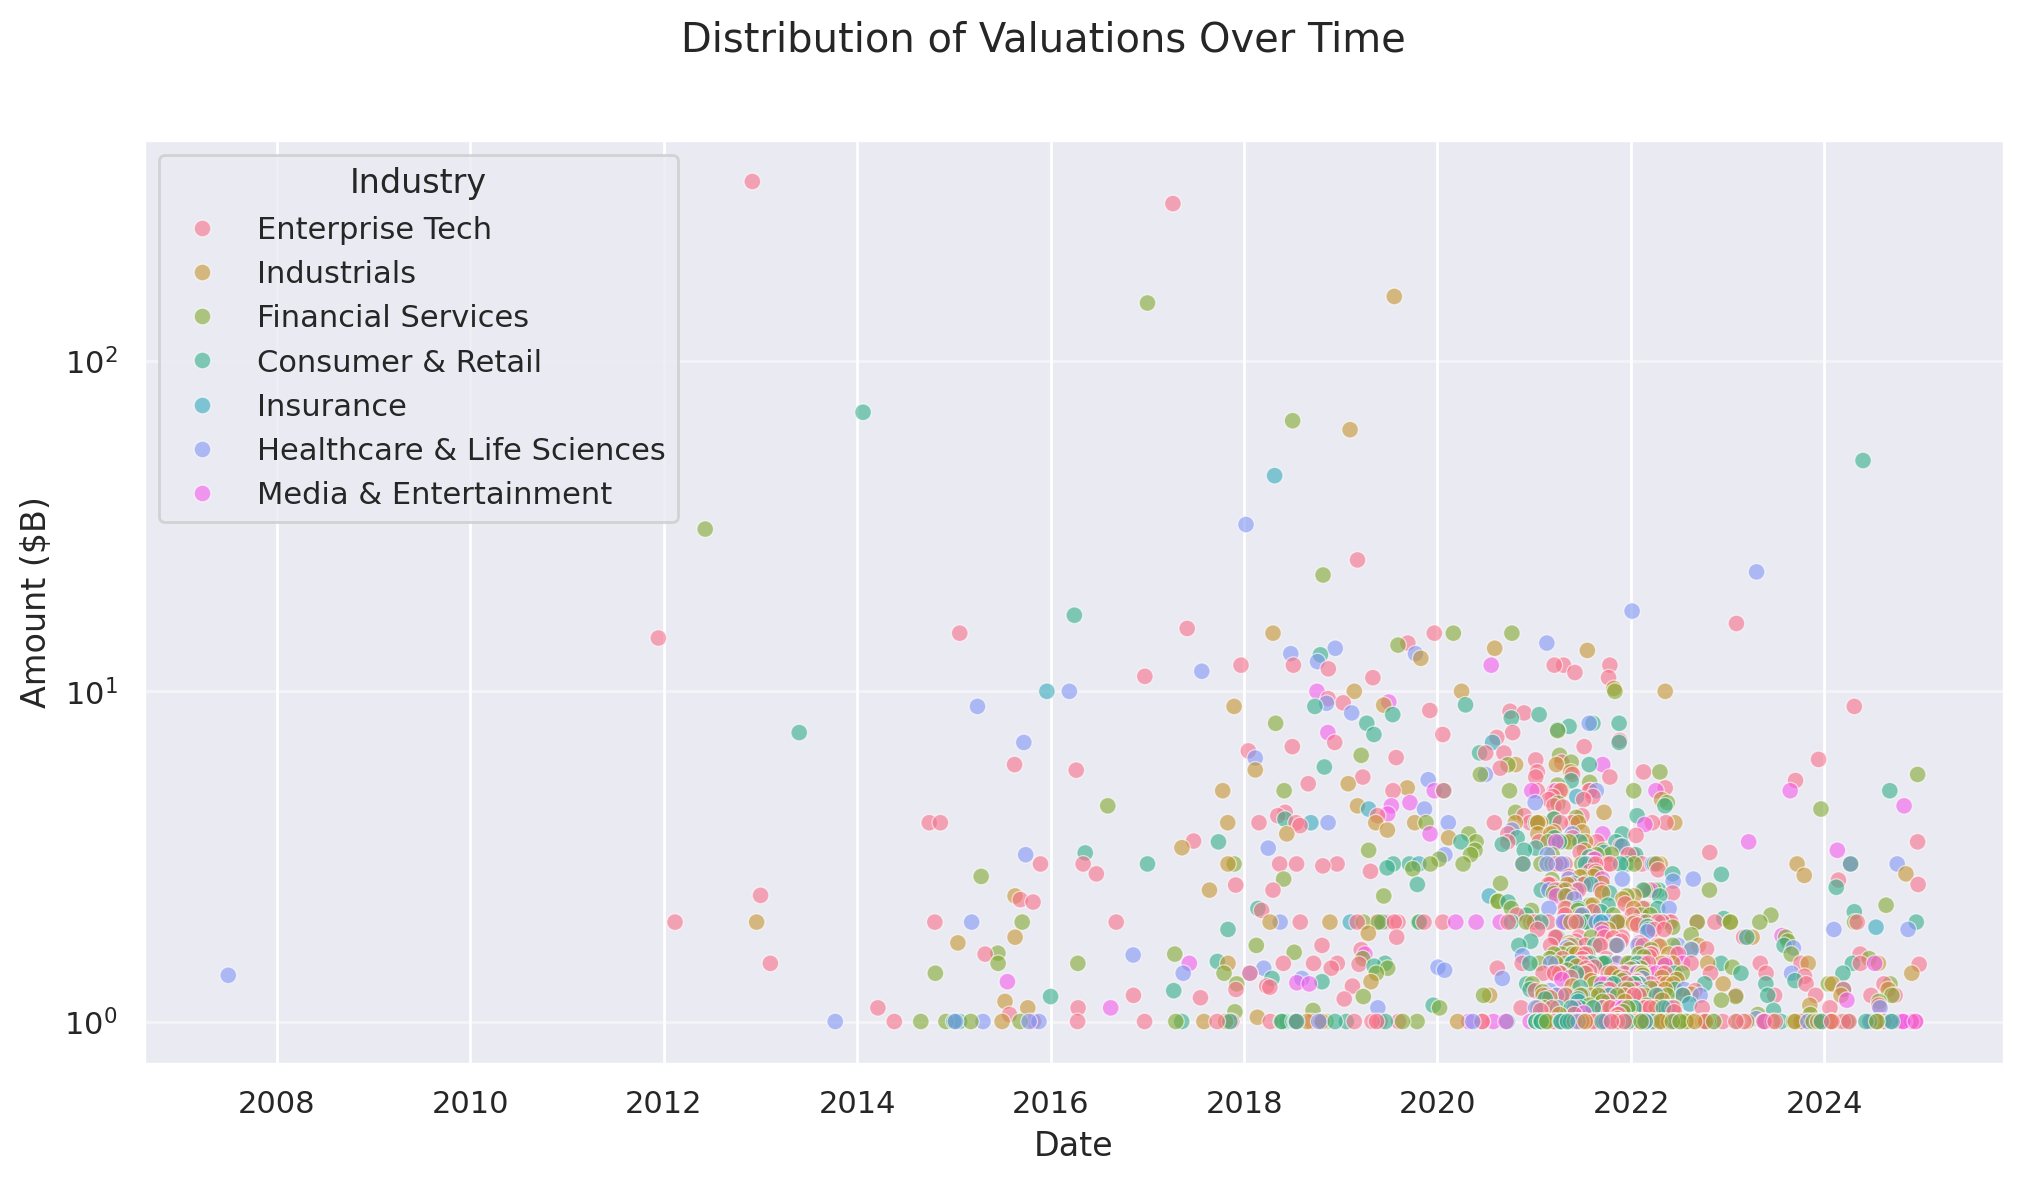

## Distribution of Funding Over Time

In [ ]:
plt.subplots(figsize=(12, 6))
sns.scatterplot(df, x='Unicorn Date', y=df['Funding ($M)'], alpha=0.6, hue='Industry')
plt.suptitle('Distribution of Funding Over Time')
plt.xlabel('Date')
plt.ylabel('Amount ($M)')
plt.grid(axis='y', alpha=0.5)
# plt.yscale('log')
plt.show()


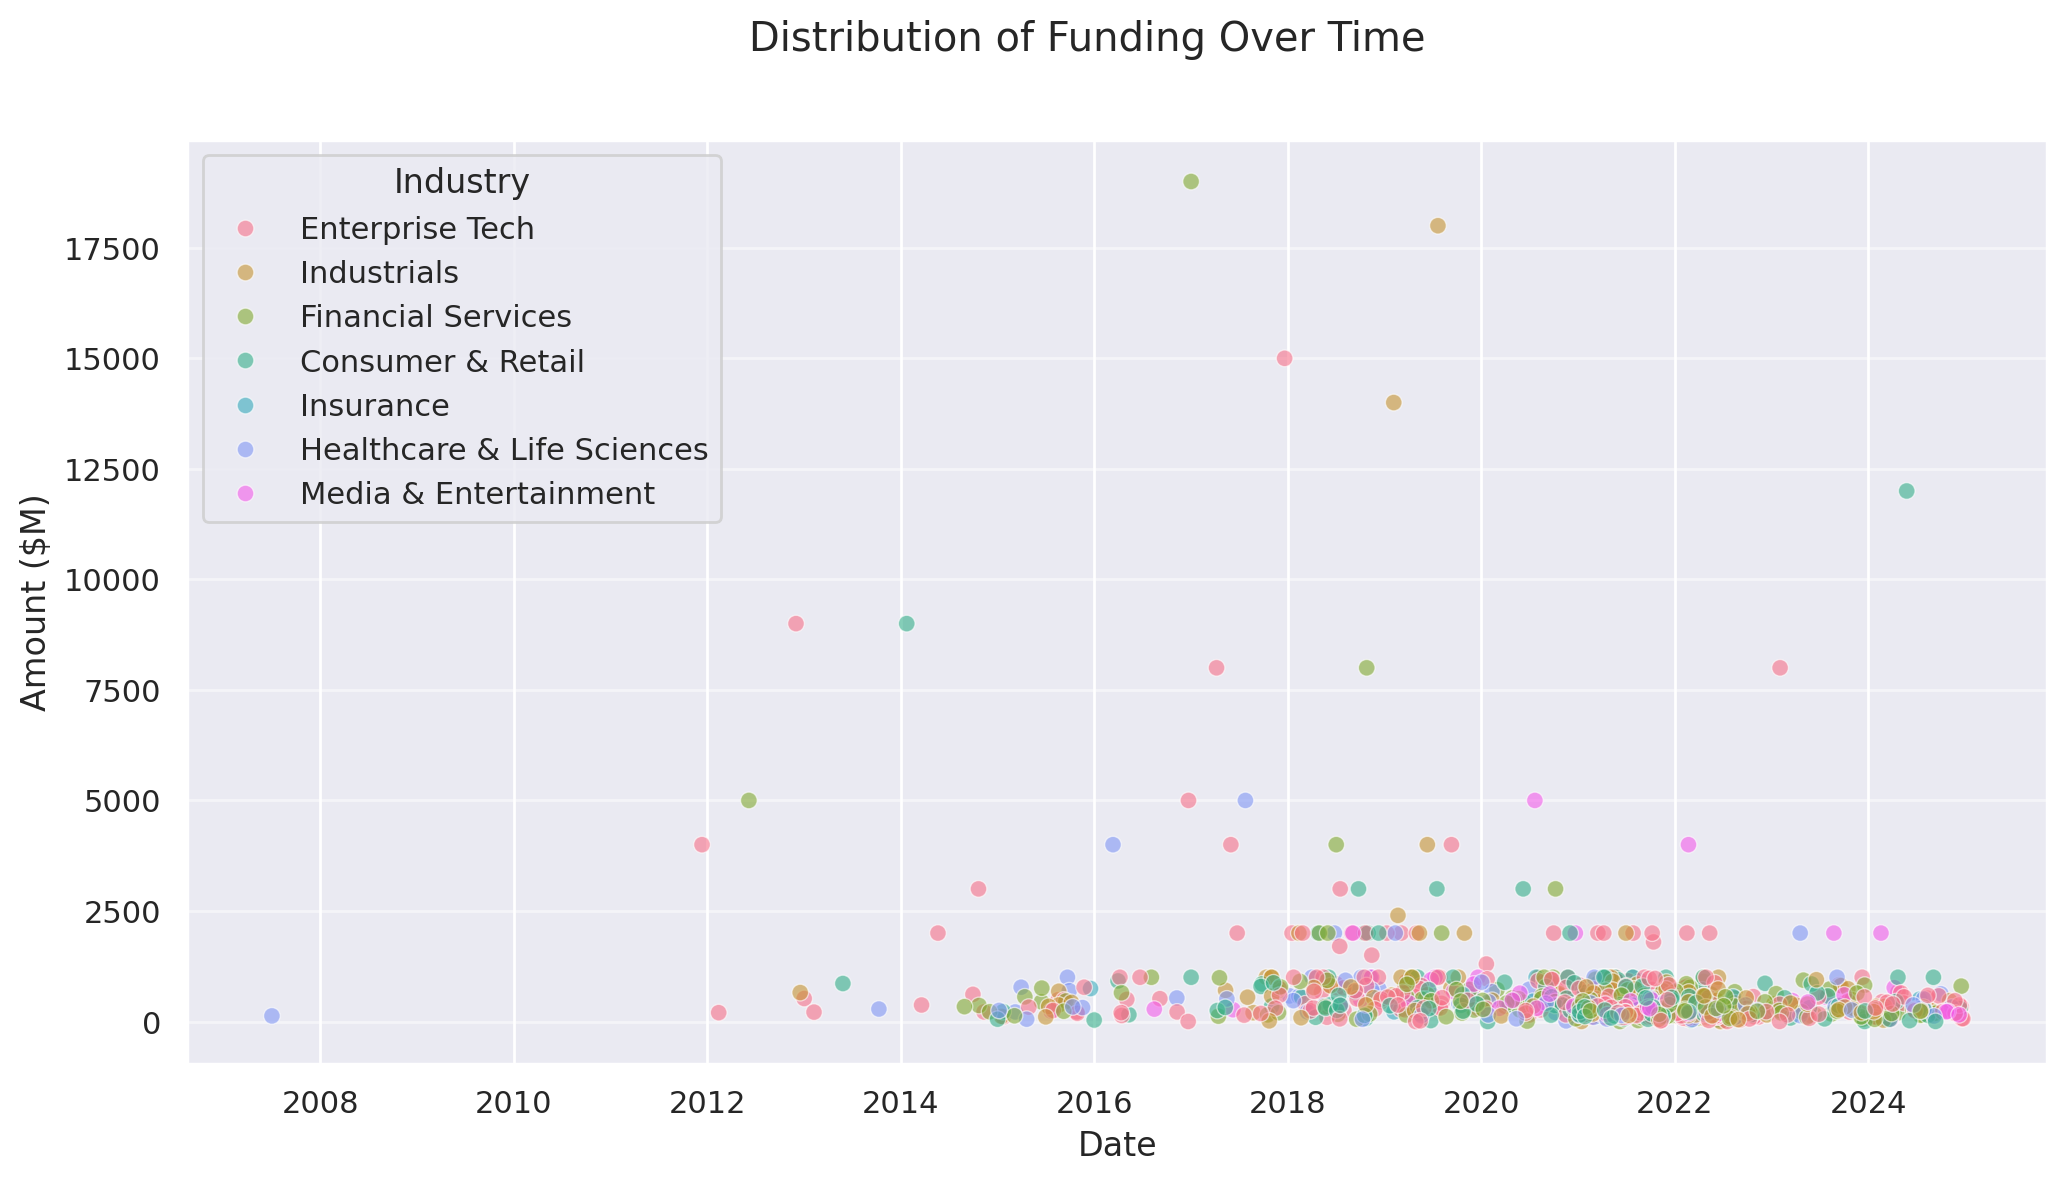

# Correlation Analysis

## Relationship between Funding and Valuation

In [ ]:
df_filtered = df[(df['Total Equity Funding ($)'] >= df['Total Equity Funding ($)'].quantile(0.05)) &
                 (df['Total Equity Funding ($)'] <= df['Total Equity Funding ($)'].quantile(0.95)) &
                 (df['Valuation ($)'] >= df['Valuation ($)'].quantile(0.05)) &
                 (df['Valuation ($)'] <= df['Valuation ($)'].quantile(0.95))]

# plt.subplots(figsize=(12, 8), dpi=300)
# sns.relplot(df, x='Total Equity Funding ($)', y='Valuation ($)', alpha=0.6, hue='Industry', row='Unicorn Type')
# print(df[df['Unicorn Type']=='Centicorn'][['Valuation ($B)', 'Funding ($B)']].corr())
g = sns.relplot(df, x='Funding ($M)', y='Latest Valuation ($B)',
                alpha=0.6, hue='Industry', col='Unicorn Type',
                facet_kws={'sharey':False, 'sharex':False})
g.axes[0,0].set(xscale='log')
# sns.jointplot(df_filtered, x='Total Equity Funding ($)', y='Valuation ($)', kind='reg', truncate=False, height=7)
# plt.suptitle('Relationship between Funding and Valuation')
plt.xlabel('Funding ($)')
plt.ylabel('Valuation ($)')
plt.grid(True)
# plt.xscale('log')
# plt.yscale('log')
plt.show()


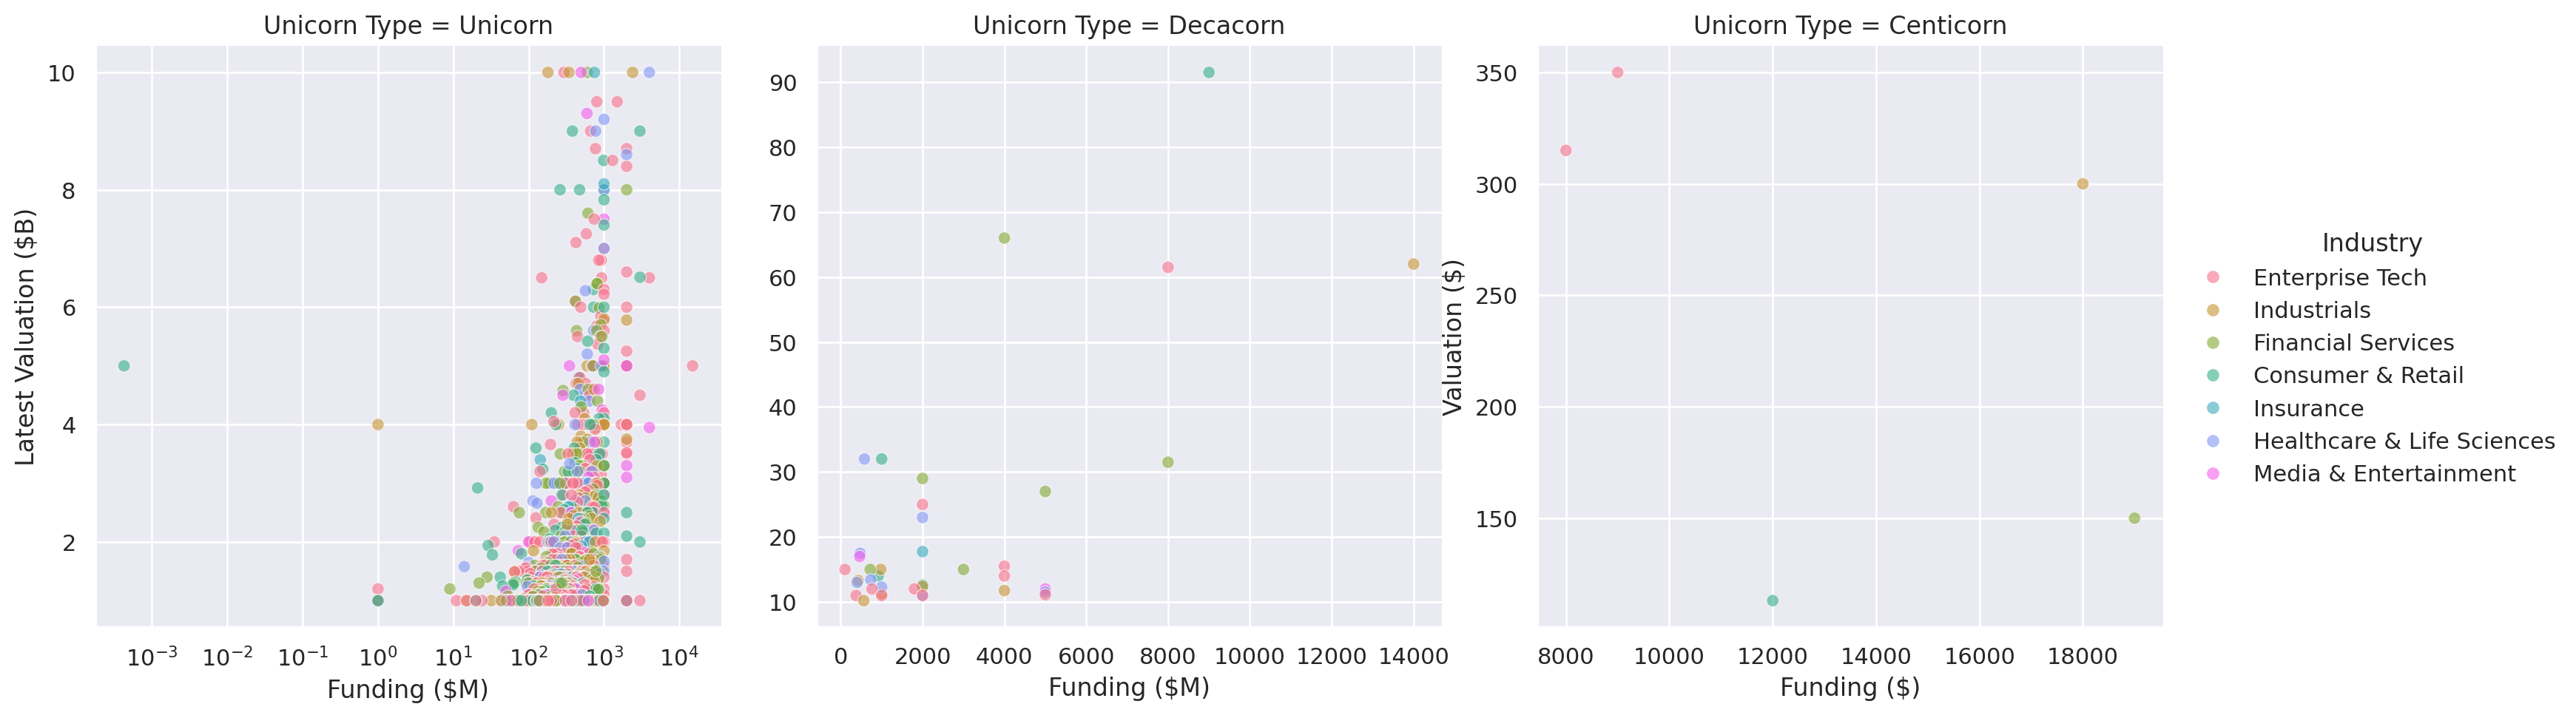

## Relationship between Time to Unicorn and Valuation

In [ ]:
# Filter out values outside the 5th and 95th percentiles
df_filtered = df[(df['Years to Unicorn'] >= df['Years to Unicorn'].quantile(0.05)) &
                 (df['Years to Unicorn'] <= df['Years to Unicorn'].quantile(0.95)) &
                 (df['Valuation ($)'] >= df['Valuation ($)'].quantile(0.05)) &
                 (df['Valuation ($)'] <= df['Valuation ($)'].quantile(0.95))]

plt.subplots(figsize=(12, 8))
sns.scatterplot(df, x=df_filtered['Years to Unicorn'], y=df['Valuation ($)'], alpha=0.6, hue='Industry')
plt.suptitle('Relationship between Time to Unicorn and Valuation')
plt.xlabel('Years')
plt.ylabel('Valuation ($)')
plt.grid(True)
plt.yscale('log')
plt.show()


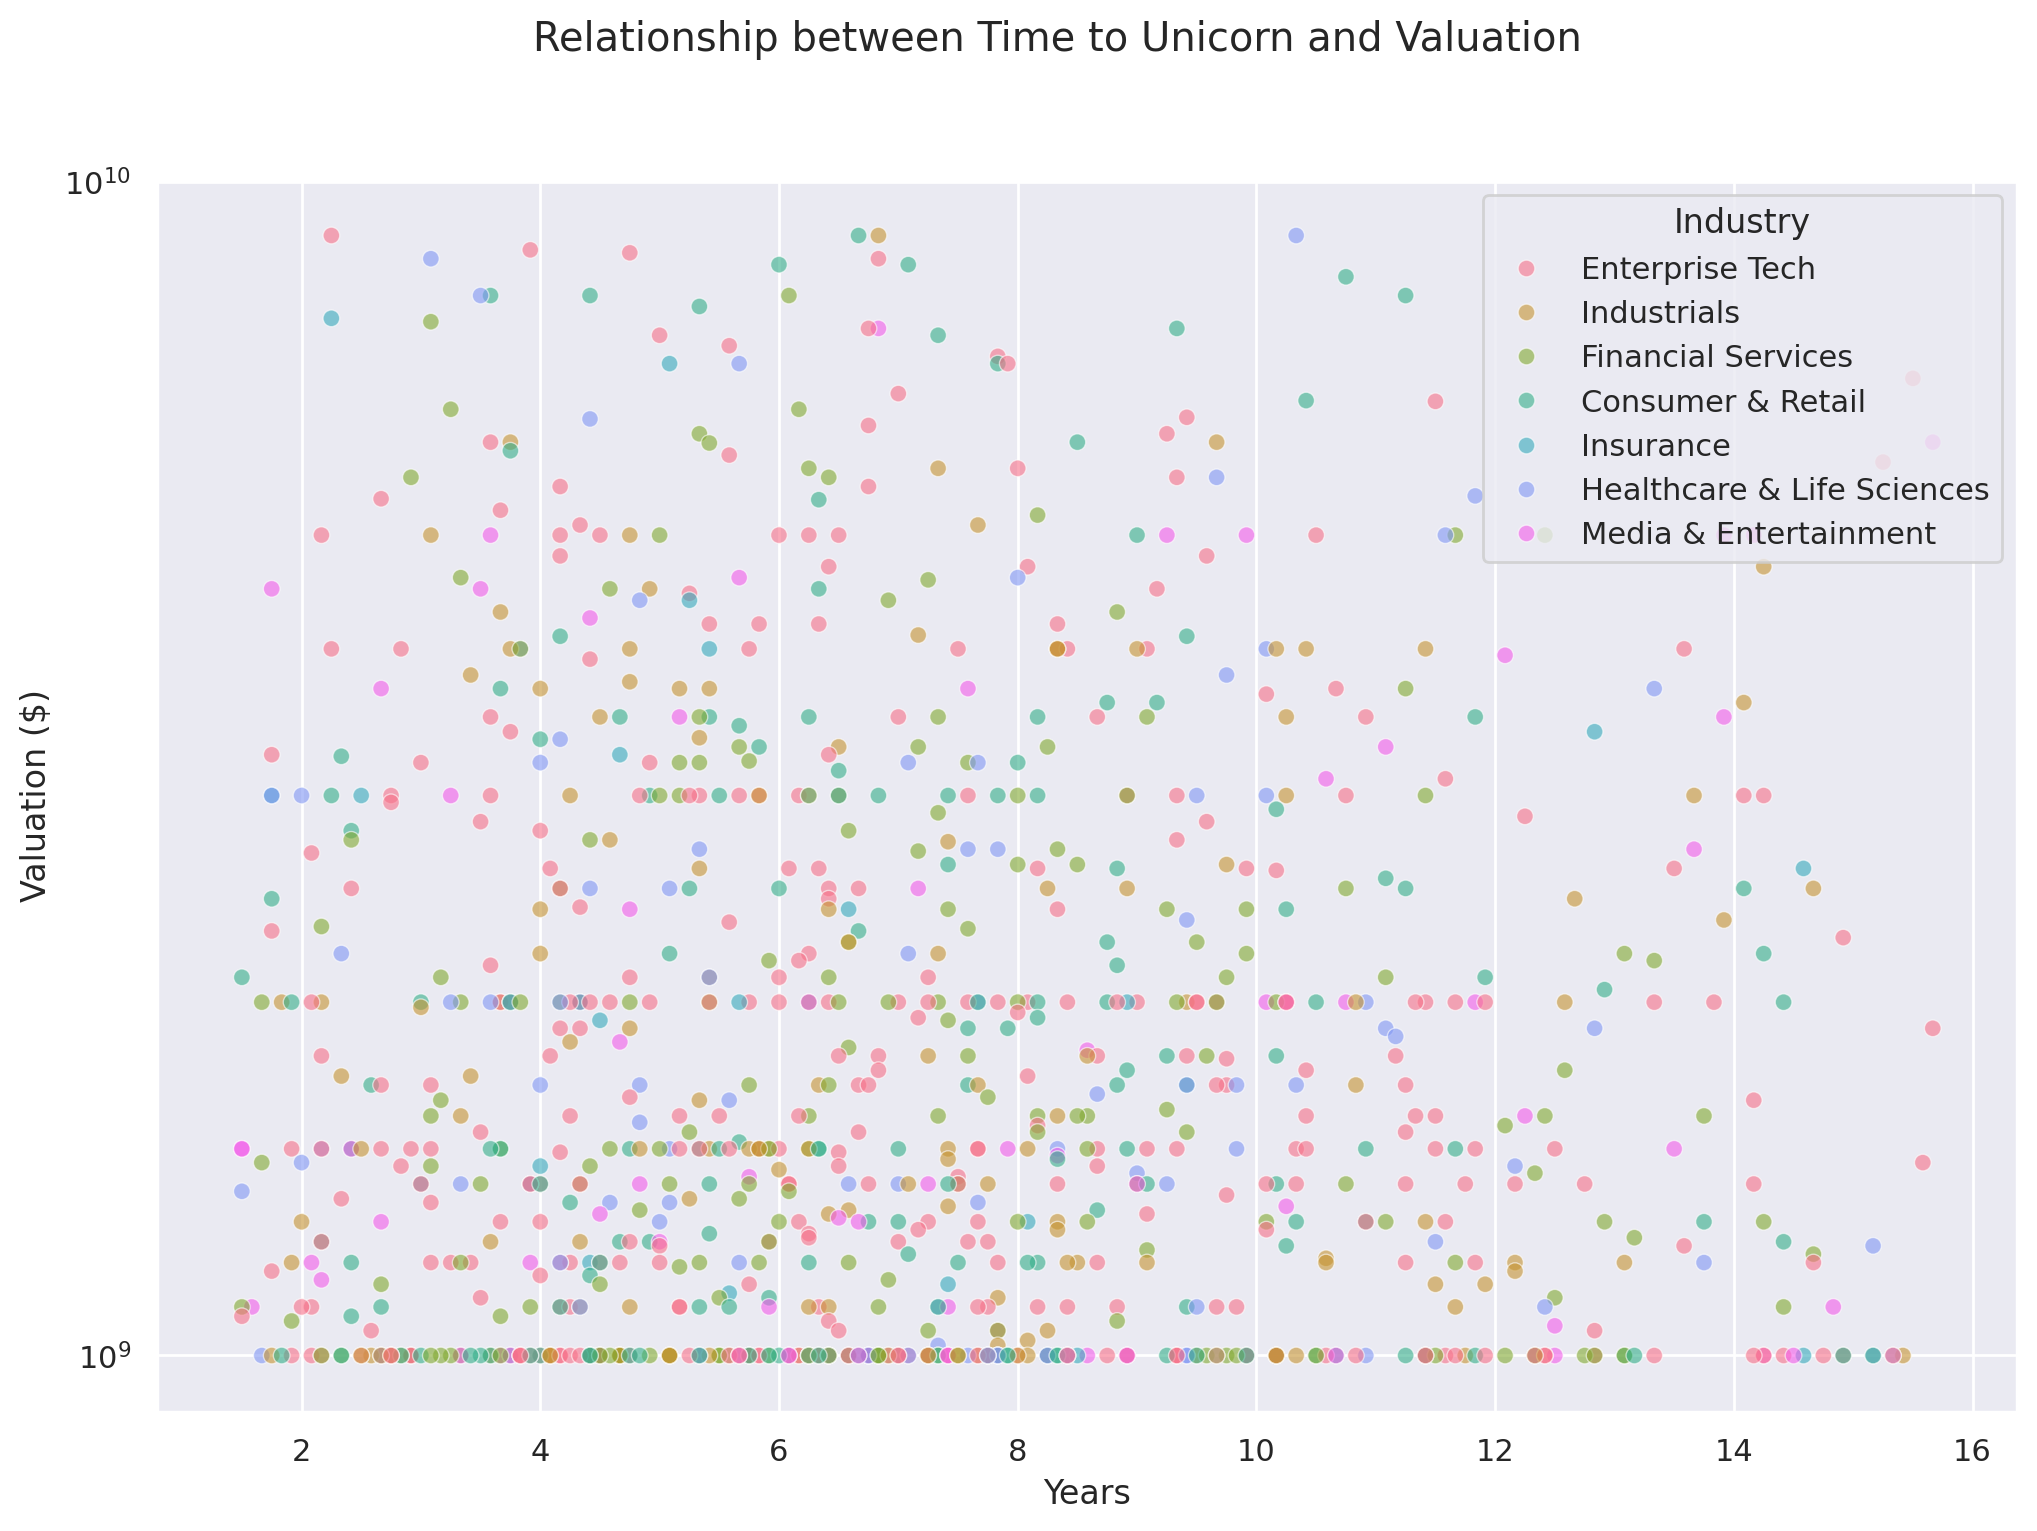

# Historical Analysis

## Survival and Acquisition

-   Find out companies no longer listed as unicorns in 2024

    ``` python
    df_2022 = pd.read_csv('input/datasets/Unicorn_Companies (March 2022).csv')
    df_2022['Valuation ($B)'] = pd.to_numeric(df_2022['Valuation ($B)'].str.replace('$', ''))
    df_exit = df_2022[~df_2022['Company'].str.lower().isin(df['Company'].str.lower())]
    ```

    ``` example
    178 companies no longer listed in 2024 unicorn list
    ```

    ``` python
    print(df_exit.head())
    ```

    ``` example
                       Company  Valuation ($B) Date Joined        Country           City                                Industry                                  Select Inverstors  Founded Year  \
    7                Instacart           39.00  12/30/2014  United States  San Francisco     Supply chain, logistics, & delivery  Khosla Ventures, Kleiner Perkins Caufield & By...        2012.0
    10                     FTX           32.00   7/20/2021        Bahamas        Fintech  Sequoia Capital, Thoma Bravo, Softbank                                                NaN        2018.0
    15             J&T Express           20.00    4/7/2021      Indonesia        Jakarta     Supply chain, logistics, & delivery  Hillhouse Capital Management, Boyu Capital, Se...        2015.0
    31  Biosplice Therapeutics           12.00    8/6/2018  United States      San Diego                                  Health           Vickers Venture Partners, IKEA GreenTech        2008.0
    39                 Weilong           10.88    5/8/2021          China          Luohe                       Consumer & retail  Tencent Holdings, Hillhouse Capital Management...           NaN

       Total Raised Financial Stage  Investors Count  Deal Terms  Portfolio Exits
    7       $2.686B             NaN             29.0        12.0              NaN
    10      $1.829B             Acq             40.0         3.0              1.0
    15      $4.653B             NaN              9.0         3.0              NaN
    31      $561.5M             NaN             10.0         1.0              NaN
    39     $559.74M             NaN              7.0         1.0              NaN
    ```

-   Financial Stage

    ``` python
    df_2022['Financial Stage'].value_counts()
    ```

    ``` example
    Financial Stage
    Acquired       22
    Divestiture     8
    IPO             7
    Acq             7
    Asset           1
    Take            1
    Management      1
    Reverse         1
    Corporate       1
    Name: count, dtype: int64
    ```

### Top Exited Unicorns as of March 2022

In [ ]:
df_exit_top_companies = df_exit.sort_values('Valuation ($B)', ascending=False).head(20)


In [ ]:
plt.subplots(figsize=(12, 6))
ax = sns.barplot(df_exit_top_companies,
                 x='Company',
                 y='Valuation ($B)',
                 hue='Company')
for i in ax.containers:
    ax.bar_label(i)
plt.suptitle('Top Exited Unicorns as of March 2022')
plt.ylabel('Valuation ($B)')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.show()


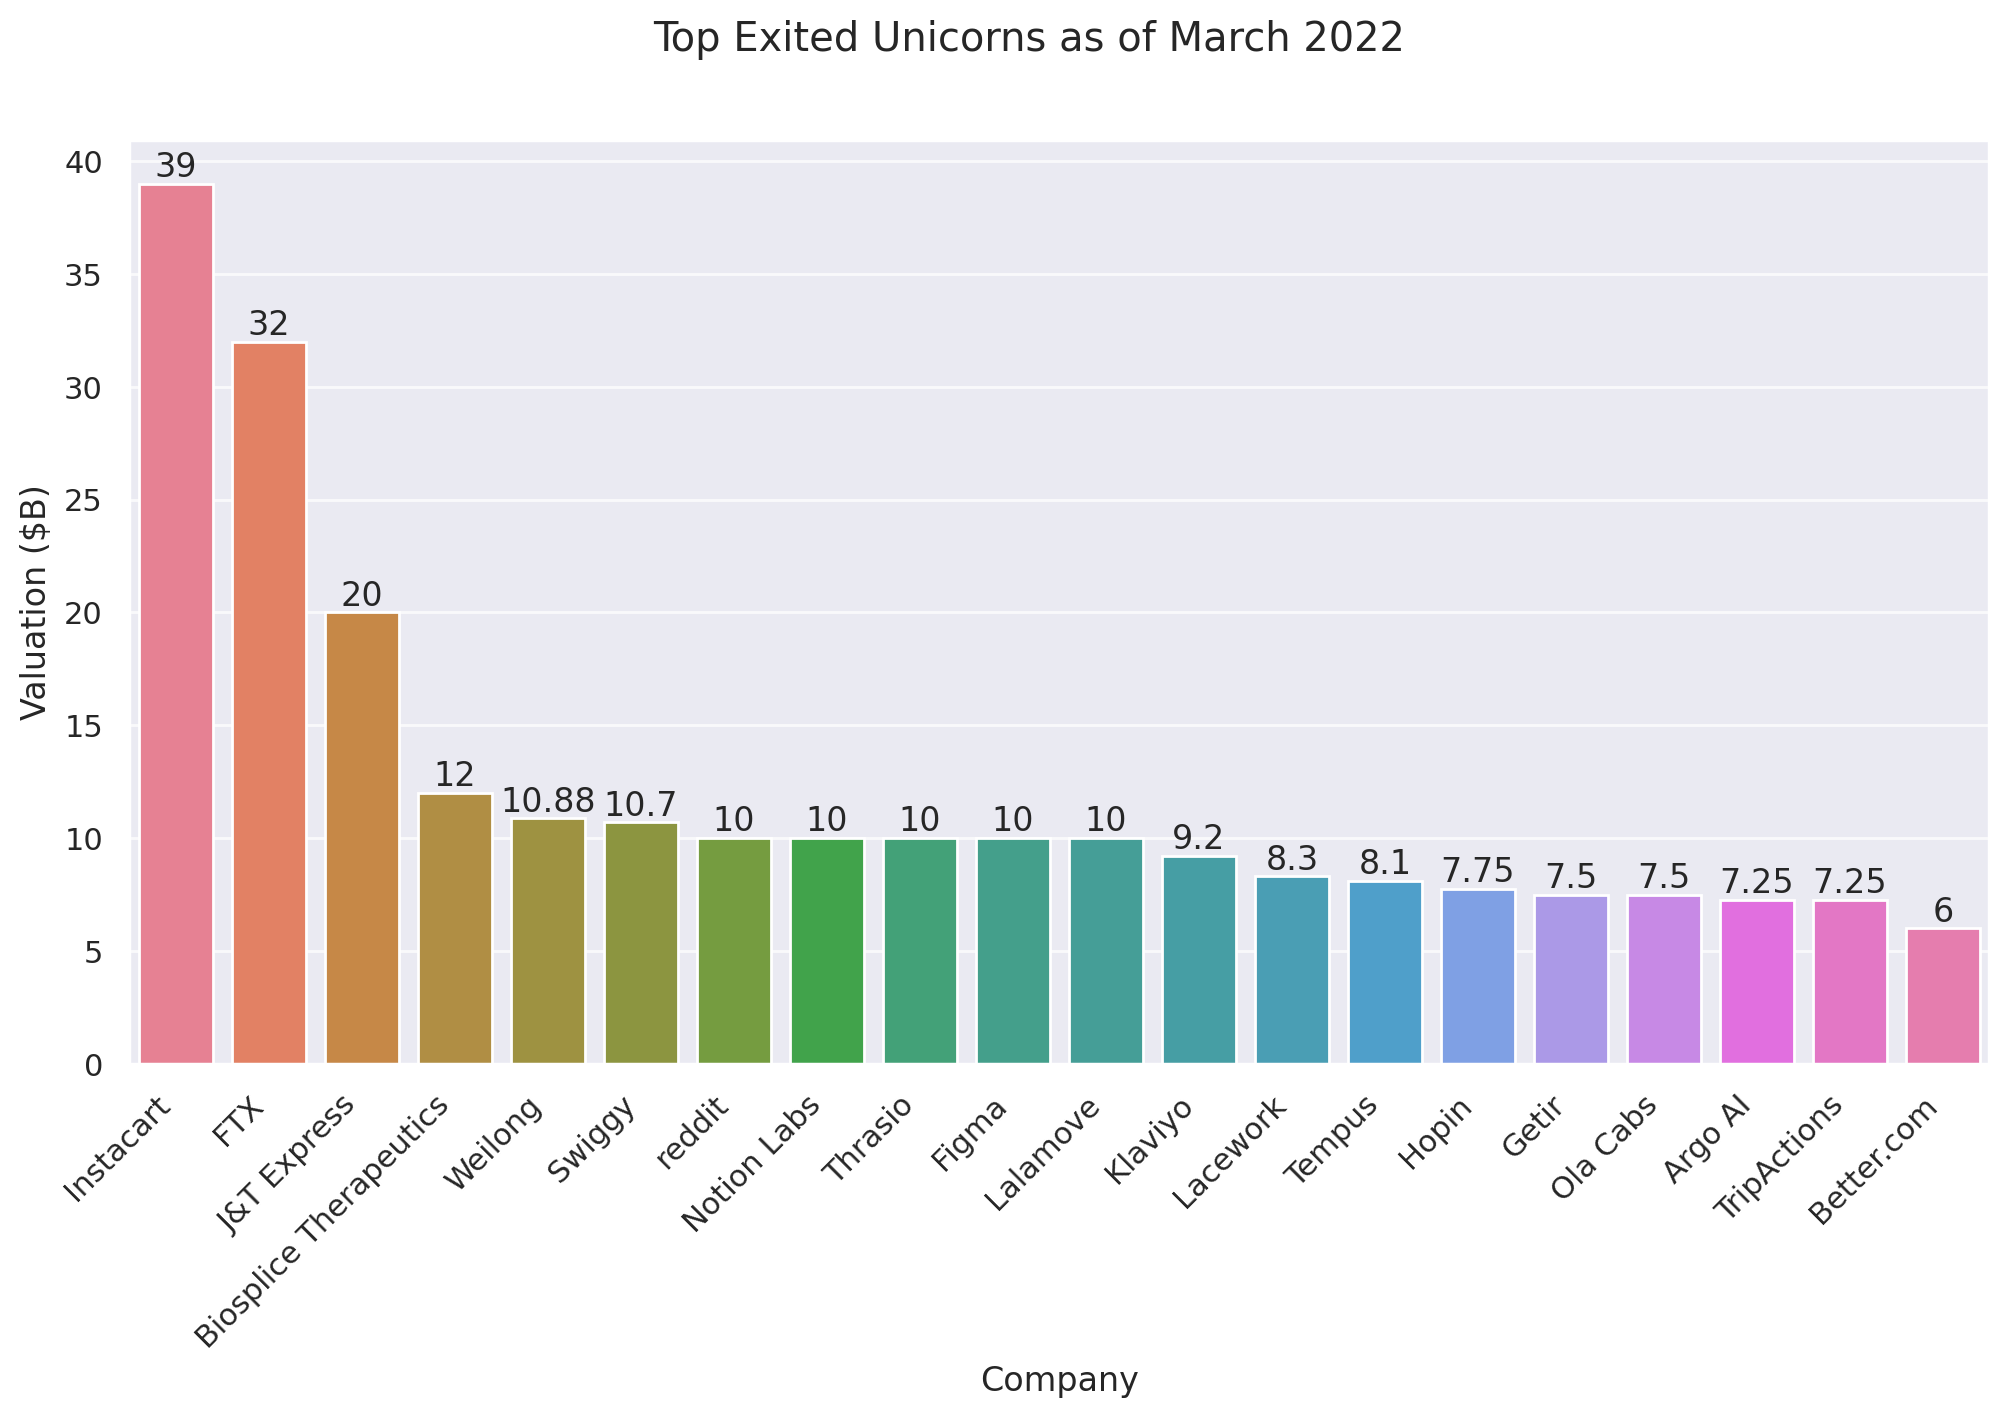

<u>**Insights:**</u>

-   **Leading Exited Unicorn:**

    **Instacart** stands out as the top exited unicorn with a valuation
    of **\$39B**. This indicates significant market presence and
    investor confidence prior to its exit.

-   **Notable Competitors:**

    -   **FTX**, despite its subsequent bankruptcy, had a valuation of
        **\$32B**, highlighting its rapid growth and substantial funding
        within the cryptocurrency sector.
    -   **J&T Express** and **Biosplice Therapeutics** follow with
        valuations of **\$20B** and **\$12B**, respectively, indicating
        strong competition in logistics and healthcare sectors.

-   **Diverse Industries:**

    -   The chart features unicorns across various industries, including
        logistics (J&T Express), biotechnology (Biosplice Therapeutics),
        food delivery (Swiggy), and technology (NerdWallet, Robinhood).
    -   This diversity underscores the broad appeal and investment
        potential across different sectors.

-   **Valuation Range:**

    The valuations of exited unicorns vary significantly, with the
    lowest being \$6B (related to Beekeeper). This range suggests that
    while some companies achieved massive scale, others still
    represented substantial exits.

-   **Market Trends:**

    The presence of companies like **Swiggy** and **NerdWallet**
    indicates ongoing investor interest in technology-driven solutions,
    particularly in food delivery and financial services.

-   **Implications for Investors:**

    -   The valuations reflect both the potential for high returns in
        emerging sectors and the risks associated with exits, as
        demonstrated by FTX's downfall.
    -   Investors may consider industry trends and market demands when
        evaluating future investments in unicorns.

### Exit Reasons of Former Unicorns

In [ ]:
_df = pd.read_csv('input/raw_data/list-of-unicorn-former-startups_20250619 (wikipedia).csv')
_df['Company'] = _df['Company'].str.strip()
def correct_exit_reasons(s):
    s = re.sub(r'\[.*\]', '', s)
    s= s.strip()
    if 'merge' in s.lower():
        return 'Merged'
    if 'acquire' in s.lower() or 'acquisition' in s.lower() or 'takeover' in s.lower():
        return 'Acquired'
    if 'devaluation' == s.lower():
        return 'Devalued'
    if 'direct listing' == s.lower():
        return 'IPO'
    return s
_df['Exit reason'] = _df['Exit reason'].dropna().apply(correct_exit_reasons)
_df['Exit reason'].value_counts()


``` example
Exit reason
IPO           128
Acquired       53
Merged         14
Defunct         3
Devalued        3
Bankruptcy      2
Name: count, dtype: int64
```

In [ ]:
exit_reasons = _df['Exit reason'].value_counts().reset_index(name='Count')
plt.subplots(figsize=(12, 6))
ax = sns.barplot(exit_reasons, x='Exit reason', y='Count', hue='Exit reason')
for i in ax.containers:
    ax.bar_label(i)
plt.suptitle('Exit Reasons of Former Unicorns')
plt.show()


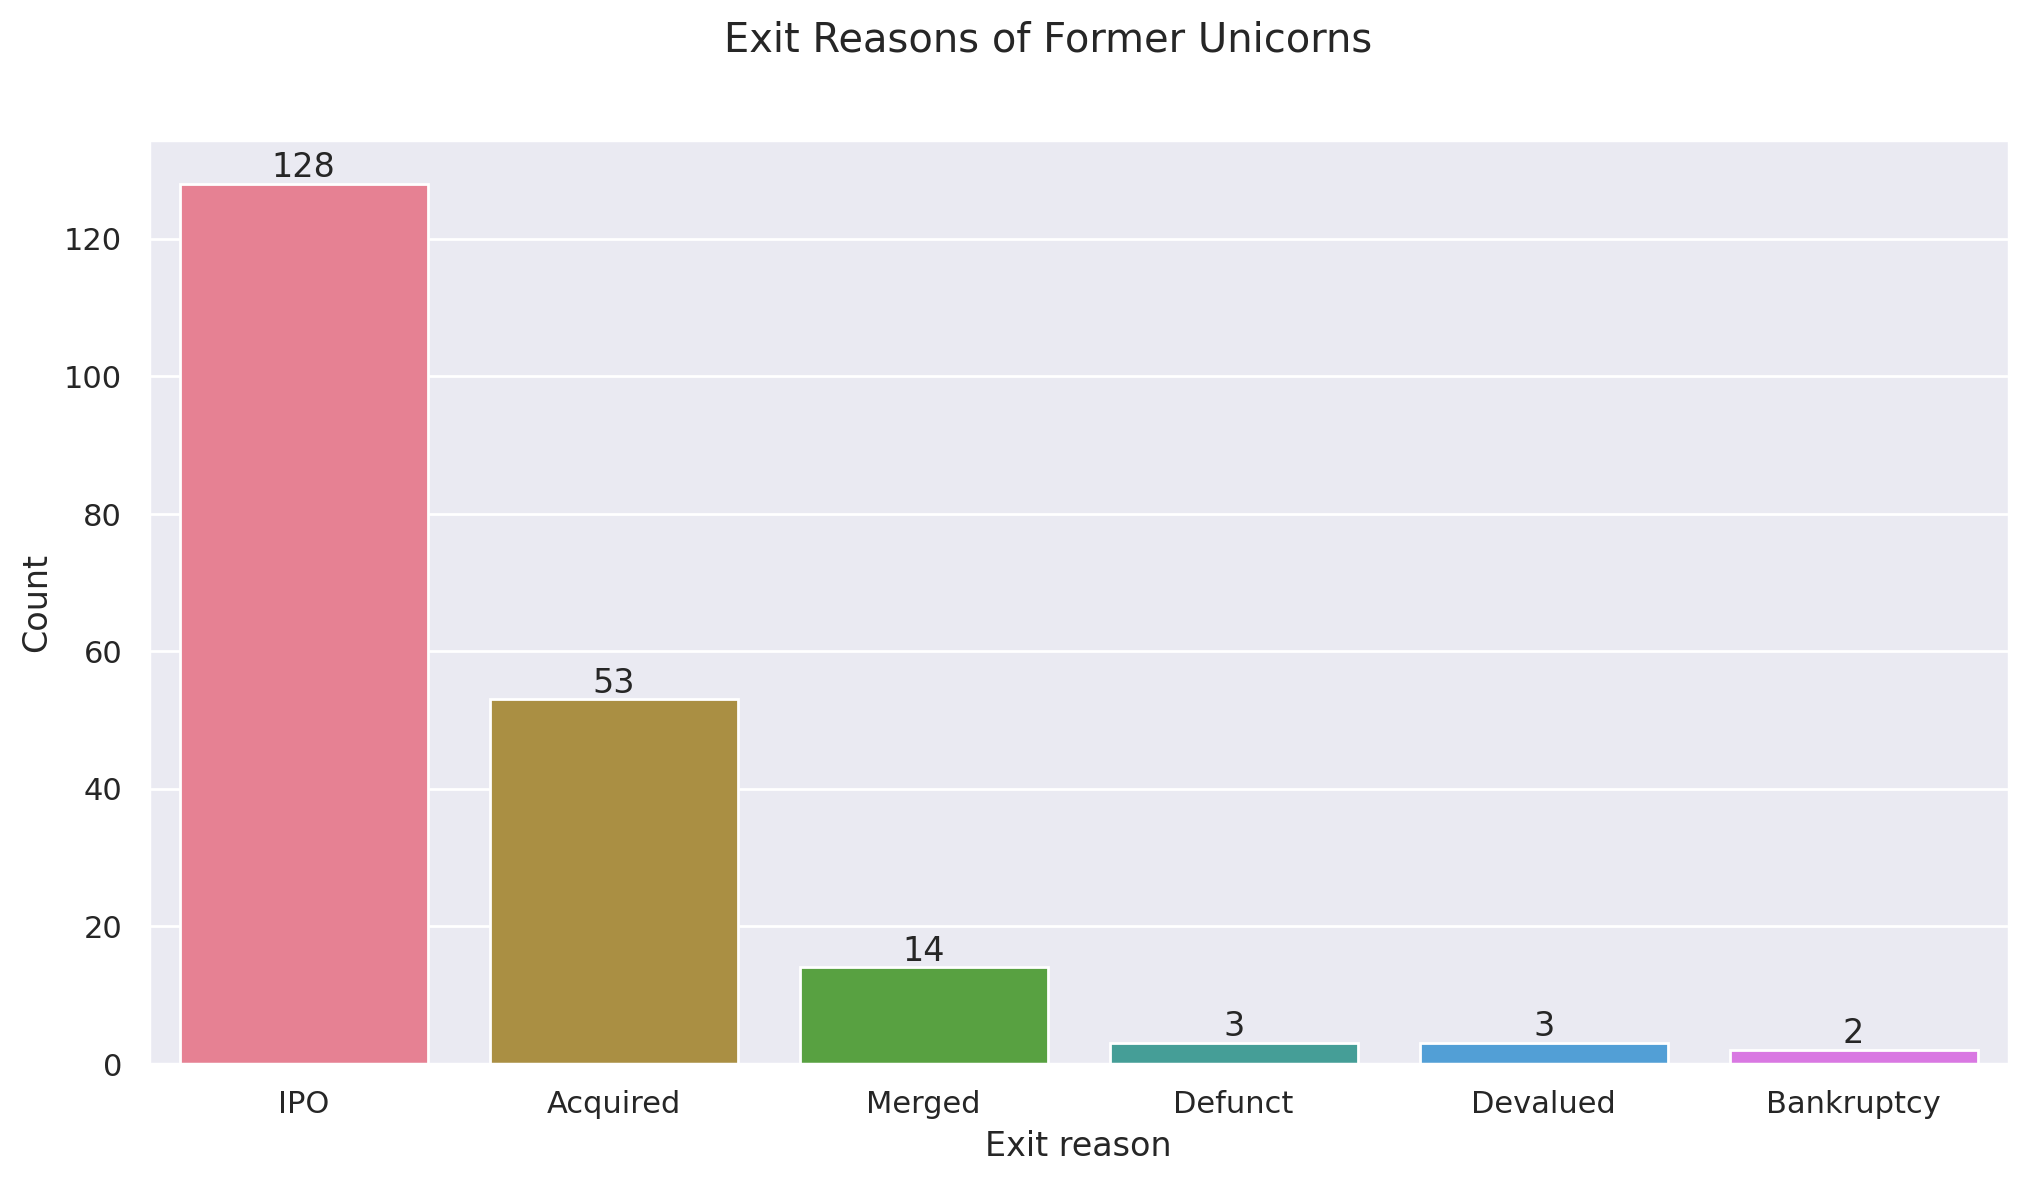

The chart illustrates that most unicorns have successful exit
strategies, predominantly through IPOs and acquisitions. The relatively
low numbers for defunct, devalued, and bankrupt companies indicate that,
despite challenges, the unicorn landscape has robust potential for
growth and successful exits. This information is valuable for investors
assessing the viability and longevity of unicorn businesses.

# Funded by Y-Combinator

Y Combinator, founded in 2005 by Paul Graham and others, is a
prestigious startup accelerator based in Silicon Valley that provides
early-stage companies with seed funding, mentorship, and resources over
a three-month program held twice a year. Startups receive initial
funding in exchange for equity and culminate in a Demo Day where they
pitch to investors. Y Combinator has launched successful companies like
Airbnb, Dropbox, and Stripe, significantly impacting the startup
ecosystem and inspiring numerous other accelerators globally.

-   **Datasets**

    -   **YC Campanies**

        ``` python
        df_yc_companies = pd.read_csv('input/datasets/2024 YCombinator All Companies Dataset/companies.csv')

        df_yc_industries = pd.read_csv('input/datasets/2024 YCombinator All Companies Dataset/industries.csv')
        df_yc_tags = pd.read_csv('input/datasets/2024 YCombinator All Companies Dataset/tags.csv')
        df_yc_companies = df_yc_companies.merge(df_yc_industries[['id', 'industry']].groupby('id')['industry'].agg(list).reset_index(), on='id', how='left')
        df_yc_companies = df_yc_companies.merge(df_yc_tags.groupby('id')['tag'].agg(list).reset_index(), on='id', how='left')
        df_yc_companies = df_yc_companies[['name', 'slug', 'oneLiner', 'website', 'smallLogoUrl', 'teamSize', 'tag', 'industry', 'batch']].rename(columns={
            'name': 'Company',
            'slug': 'Slug',
            'oneLiner': 'Short Description',
            'website': 'Website',
            'smallLogoUrl': 'Logo',
            'teamSize': 'Team Size',
            'tag': 'Tags',
            'industry': 'Industries',
            'batch': 'Batch'
        })
        print(df_yc_companies.info())
        ```

        ``` example
        <class 'pandas.core.frame.DataFrame'>
        RangeIndex: 4844 entries, 0 to 4843
        Data columns (total 9 columns):
         #   Column             Non-Null Count  Dtype
        ---  ------             --------------  -----
         0   Company            4844 non-null   object
         1   Slug               4841 non-null   object
         2   Short Description  4692 non-null   object
         3   Website            4817 non-null   object
         4   Logo               4197 non-null   object
         5   Team Size          4766 non-null   float64
         6   Tags               4463 non-null   object
         7   Industries         4825 non-null   object
         8   Batch              4844 non-null   object
        dtypes: float64(1), object(8)
        memory usage: 340.7+ KB
        None
        ```

        ``` python
        df2_yc_companies = pd.read_json('input/datasets/yc_startups.json')
        print(df2_yc_companies.info())
        ```

        ``` example
        <class 'pandas.core.frame.DataFrame'>
        RangeIndex: 1000 entries, 0 to 999
        Data columns (total 12 columns):
         #   Column       Non-Null Count  Dtype
        ---  ------       --------------  -----
         0   name         1000 non-null   object
         1   description  1000 non-null   object
         2   location     1000 non-null   object
         3   url          1000 non-null   object
         4   tags         1000 non-null   object
         5   site_url     999 non-null    object
         6   tag_line     999 non-null    object
         7   long_desc    999 non-null    object
         8   thumbnail    975 non-null    object
         9   founders     999 non-null    object
         10  meta         999 non-null    object
         11  socials      999 non-null    object
        dtypes: object(12)
        memory usage: 93.9+ KB
        None
        ```

    -   **YC Founders**

        ``` python
        df_yc_founders = pd.read_csv('input/datasets/2024 YCombinator All Companies Dataset/founders.csv')
        print(df_yc_founders.info())
        ```

        ``` example
        <class 'pandas.core.frame.DataFrame'>
        RangeIndex: 8465 entries, 0 to 8464
        Data columns (total 8 columns):
         #   Column           Non-Null Count  Dtype
        ---  ------           --------------  -----
         0   first_name       8461 non-null   object
         1   last_name        8456 non-null   object
         2   hnid             8465 non-null   object
         3   avatar_thumb     8465 non-null   object
         4   current_company  7624 non-null   object
         5   current_title    2201 non-null   object
         6   company_slug     8465 non-null   object
         7   top_company      8465 non-null   bool
        dtypes: bool(1), object(7)
        memory usage: 471.3+ KB
        None
        ```

## How many YC companies are in unicorn status currently?

In [ ]:
df_yc_unicorns = df.assign(tmp_col=df.Company.str.lower()).merge(
    df_yc_companies[['Company', 'Slug', 'Short Description', 'Website', 'Logo', 'Team Size', 'Tags', 'Industries', 'Batch']].assign(tmp_col=lambda x: x.Company.str.lower()),
    on='tmp_col', how='inner').drop(['tmp_col', 'Company_y'], axis=1).rename(columns={'Company_x': 'Company'})
df_yc_unicorns['Batch Season'] = df_yc_unicorns['Batch'].apply(lambda x: 'Summer' if x[0]=='S' else 'Winter')
df_yc_unicorns['Batch Year'] = pd.to_numeric(df_yc_unicorns['Batch'].apply(lambda x: f'20{x[1:]}'))
print(df_yc_unicorns.info())


``` example
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Company                   96 non-null     object
 1   Valuation ($B)            96 non-null     float64
 2   Total Equity Funding ($)  96 non-null     int64
 3   Unicorn Date              96 non-null     datetime64[ns]
 4   Date Founded              96 non-null     int64
 5   Years to Unicorn          96 non-null     float64
 6   Industry                  96 non-null     object
 7   Country                   96 non-null     object
 8   City                      96 non-null     object
 9   Select Investors          96 non-null     object
 10  Valuation ($)             96 non-null     float64
 11  Unicorn Year              96 non-null     int32
 12  Funding ($B)              96 non-null     float64
 13  Funding ($M)              96 non-null     float64
 14  Investors                 96 non-null     object
 15  Months to Unicorn         96 non-null     int64
 16  Latest Valuation ($B)     96 non-null     float64
 17  Sector                    30 non-null     object
 18  Founder(s)                15 non-null     object
 19  Unicorn Type              96 non-null     category
 20  Slug                      96 non-null     object
 21  Short Description         95 non-null     object
 22  Website                   96 non-null     object
 23  Logo                      94 non-null     object
 24  Team Size                 94 non-null     float64
 25  Tags                      90 non-null     object
 26  Industries                96 non-null     object
 27  Batch                     96 non-null     object
 28  Batch Season              96 non-null     object
 29  Batch Year                96 non-null     int64
dtypes: category(1), datetime64[ns](1), float64(7), int32(1), int64(4), object(16)
memory usage: 21.7+ KB
None
```

## Top Companies by Valuation

In [ ]:
df_top_yc_unicorns = df_yc_unicorns.sort_values(by='Latest Valuation ($B)', ascending=False).head(20)
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(data=df_top_yc_unicorns, x='Company', y='Latest Valuation ($B)', hue='Company')
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Top YC unicorns by Valuation')
plt.show()


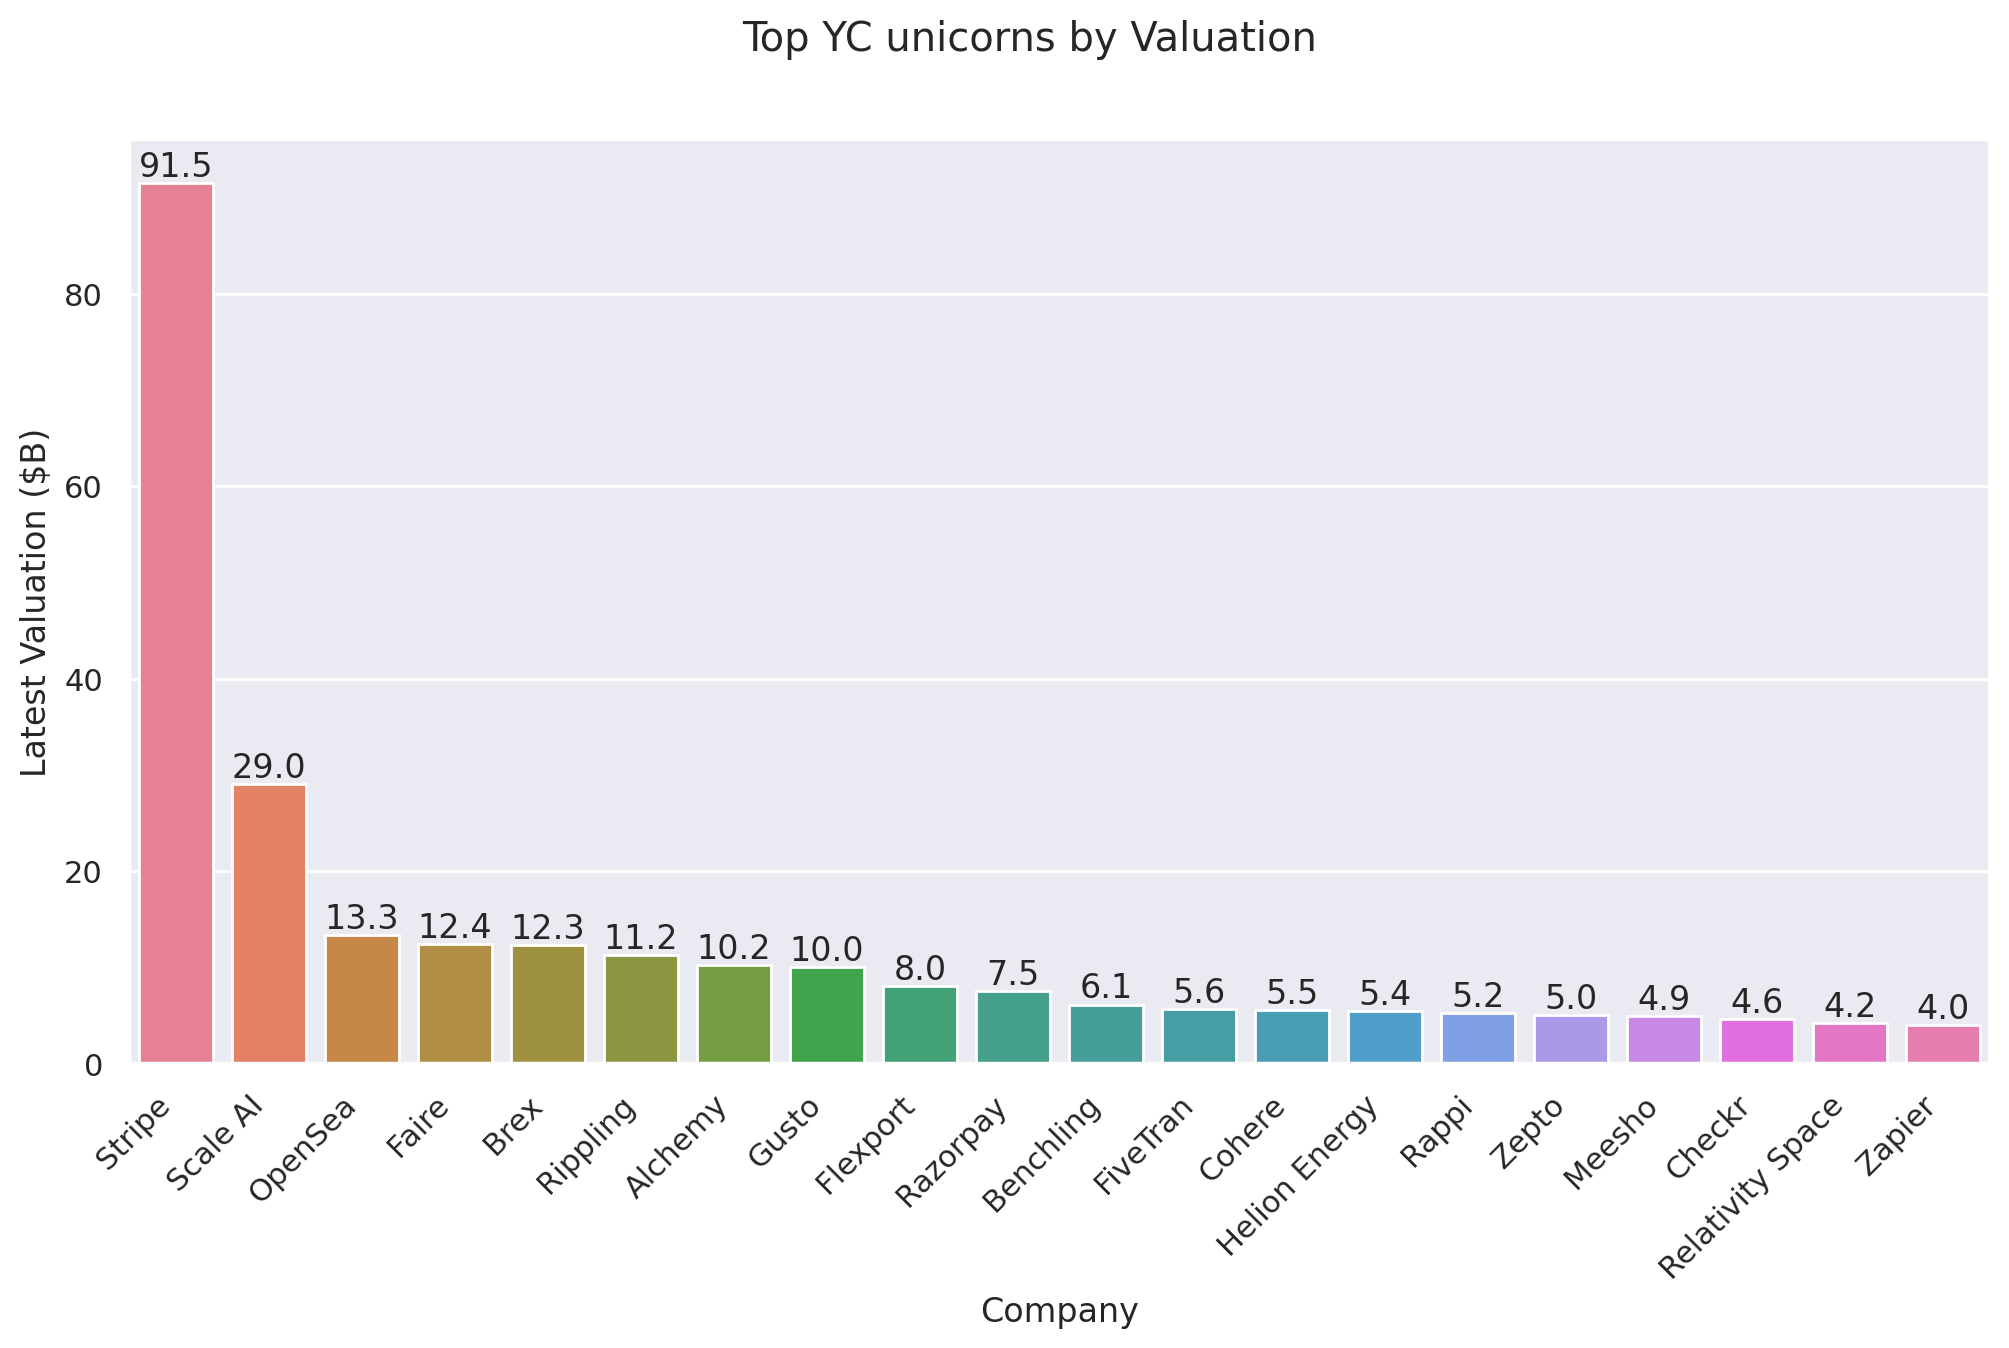

The chart illustrates the valuation landscape of top Y Combinator
unicorns, with Stripe leading substantially. The varied valuations
reflect a healthy startup ecosystem with strong growth potential across
different sectors. Investors may find valuable opportunities by
analyzing the performance and sectors of these unicorns.

\subsubsection\*{Insights:}

-   **Leading Unicorn:**

    **Stripe** is the top unicorn with a valuation of **\$91.5B**,
    indicating its dominant position in the payment processing industry.
    This high valuation reflects the company's significant market impact
    and widespread adoption among businesses.

-   **Strong Competitors:**

    -   **Scale AI** follows with a valuation of **\$29B**, showcasing
        its importance in the artificial intelligence sector. This
        positions Scale AI as a key player in the rapidly growing AI
        market.
    -   Other notable unicorns include **OpenSea** (\$13.3B) and
        **Brew** (Brewdog) (\$12.4B), highlighting the diversity of
        successful companies in sectors like blockchain and beverage.

-   **Valuation Distribution:**

    -   The chart displays a significant drop in valuation from Stripe
        to Scale AI, indicating a steep decline in market leader
        dominance. The next highest valuations cluster around the \$10B
        mark, with several companies like Rippling, Alchemy, and Gusto
        valued between \$11B and \$13B.

-   **Emerging Sectors:**

    -   Companies like **Flexport** and **Benchling** indicate strong
        interest in logistics and life sciences, respectively. This
        suggests that investors are keen on sectors with potential for
        innovation and growth.

-   **Valuation Range:**

    The lowest valuation among the listed unicorns is \$4.2B (Relativity
    Space), showing that while there is a significant range in
    valuations, all listed companies have achieved substantial market
    value as unicorns.

-   **Investment Trends:**

    The diversity among the top unicorns, covering industries from
    fintech to logistics and AI, suggests that venture capitalists are
    actively investing across various sectors. This diversification can
    mitigate risks associated with market fluctuations.

## YC Batch Distribution

In [ ]:
_df = df_yc_unicorns.groupby(['Batch Year', 'Batch Season']).size().reset_index(name='count').sort_values(by='Batch Year')
print(_df)


``` example
    Batch Year Batch Season  count
0         2009       Summer      2
1         2011       Summer      3
2         2011       Winter      1
3         2012       Summer      3
4         2012       Winter      2
5         2013       Summer      1
6         2013       Winter      1
7         2014       Summer      6
8         2014       Winter      3
9         2015       Summer      7
10        2015       Winter      3
11        2016       Summer      5
12        2016       Winter     11
14        2017       Winter      7
13        2017       Summer      5
15        2018       Summer      3
16        2018       Winter      8
17        2019       Summer      1
18        2019       Winter      4
19        2020       Summer      4
20        2020       Winter      3
21        2021       Summer      1
22        2021       Winter      3
23        2022       Summer      1
24        2022       Winter      1
25        2023       Summer      1
26        2023       Winter      1
27        2024       Summer      3
28        2024       Winter      2
```

In [ ]:
plt.subplots(figsize=(12,6))
sns.barplot(_df, x='Batch Year', y='count', hue='Batch Season')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Batch Distribution of YC Unicorns')
plt.show()


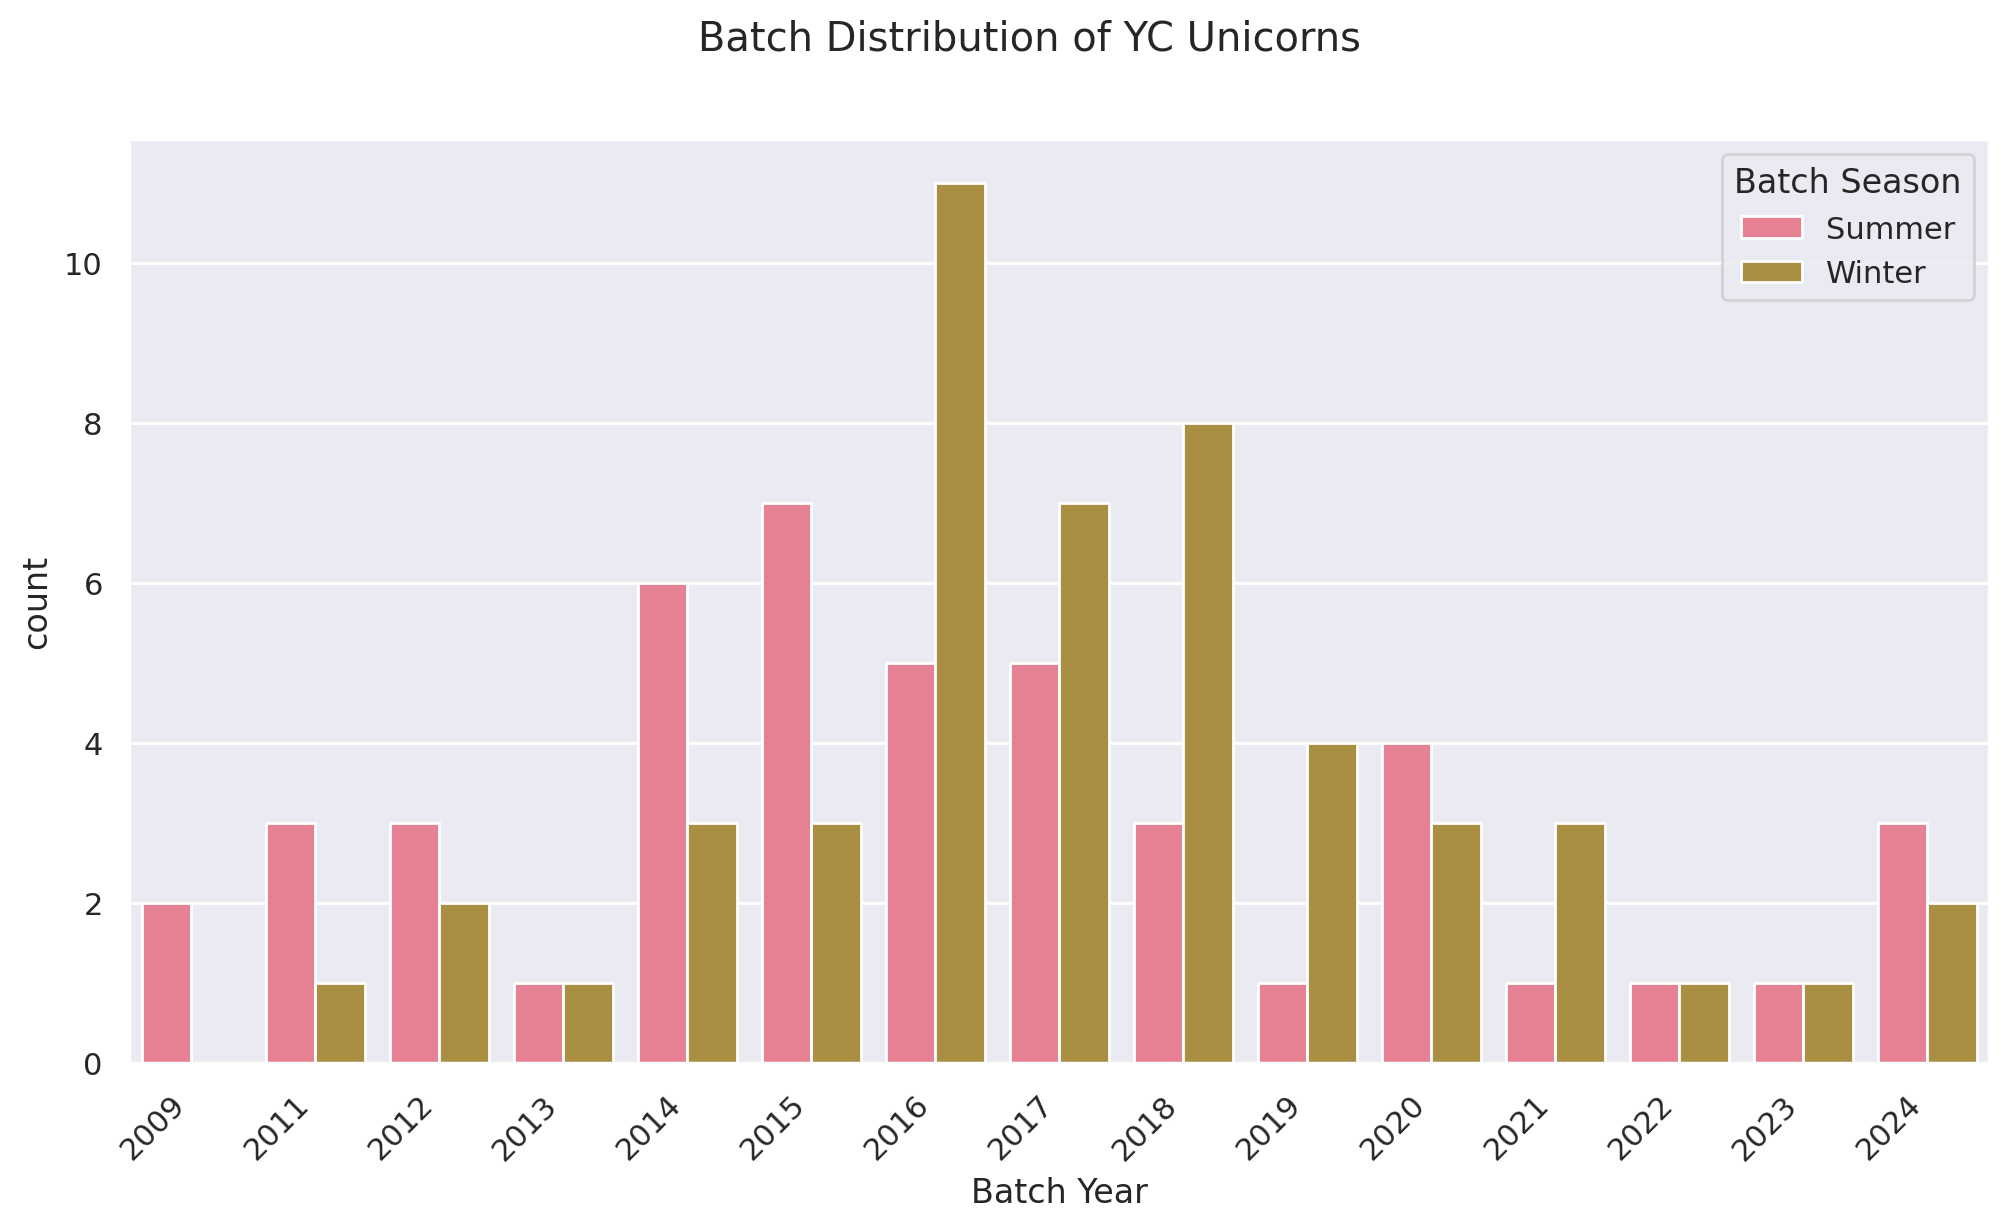

## Top Countires

In [ ]:
top_countries = df_yc_unicorns['Country'].value_counts().nlargest(20).index
top_countries


``` example
Index(['United States', 'India', 'United Kingdom', 'Canada', 'Mexico', 'Indonesia', 'Colombia', 'Australia', 'Senegal', 'Estonia', 'Spain'], dtype='object', name='Country')
```

## Top Categories

In [ ]:
top_categories = df_yc_unicorns['Tags'].explode().value_counts().head(20).reset_index(name='Count')
print(top_categories)


``` example
                       Tags  Count
0                      SaaS     25
1                   Fintech     22
2                       B2B     17
3           Developer Tools     10
4   Artificial Intelligence      8
5          Machine Learning      7
6               Marketplace      7
7                   HR Tech      6
8                E-commerce      5
9                        AI      5
10                Analytics      4
11               Enterprise      4
12                 Payments      4
13                Logistics      4
14                  Climate      4
15                      API      3
16            Manufacturing      3
17               Compliance      3
18            Generative AI      3
19                   Retail      3
```

In [ ]:
plt.subplots(figsize=(12,6))
ax = sns.barplot(data=top_categories, x='Tags', y='Count', hue='Tags')
ax.set(ylabel='Number of Companies',
       xlabel='Category')
for i in ax.containers:
    ax.bar_label(i)
plt.xticks(rotation=45, ha='right')
plt.suptitle('Top Categories')
plt.show()


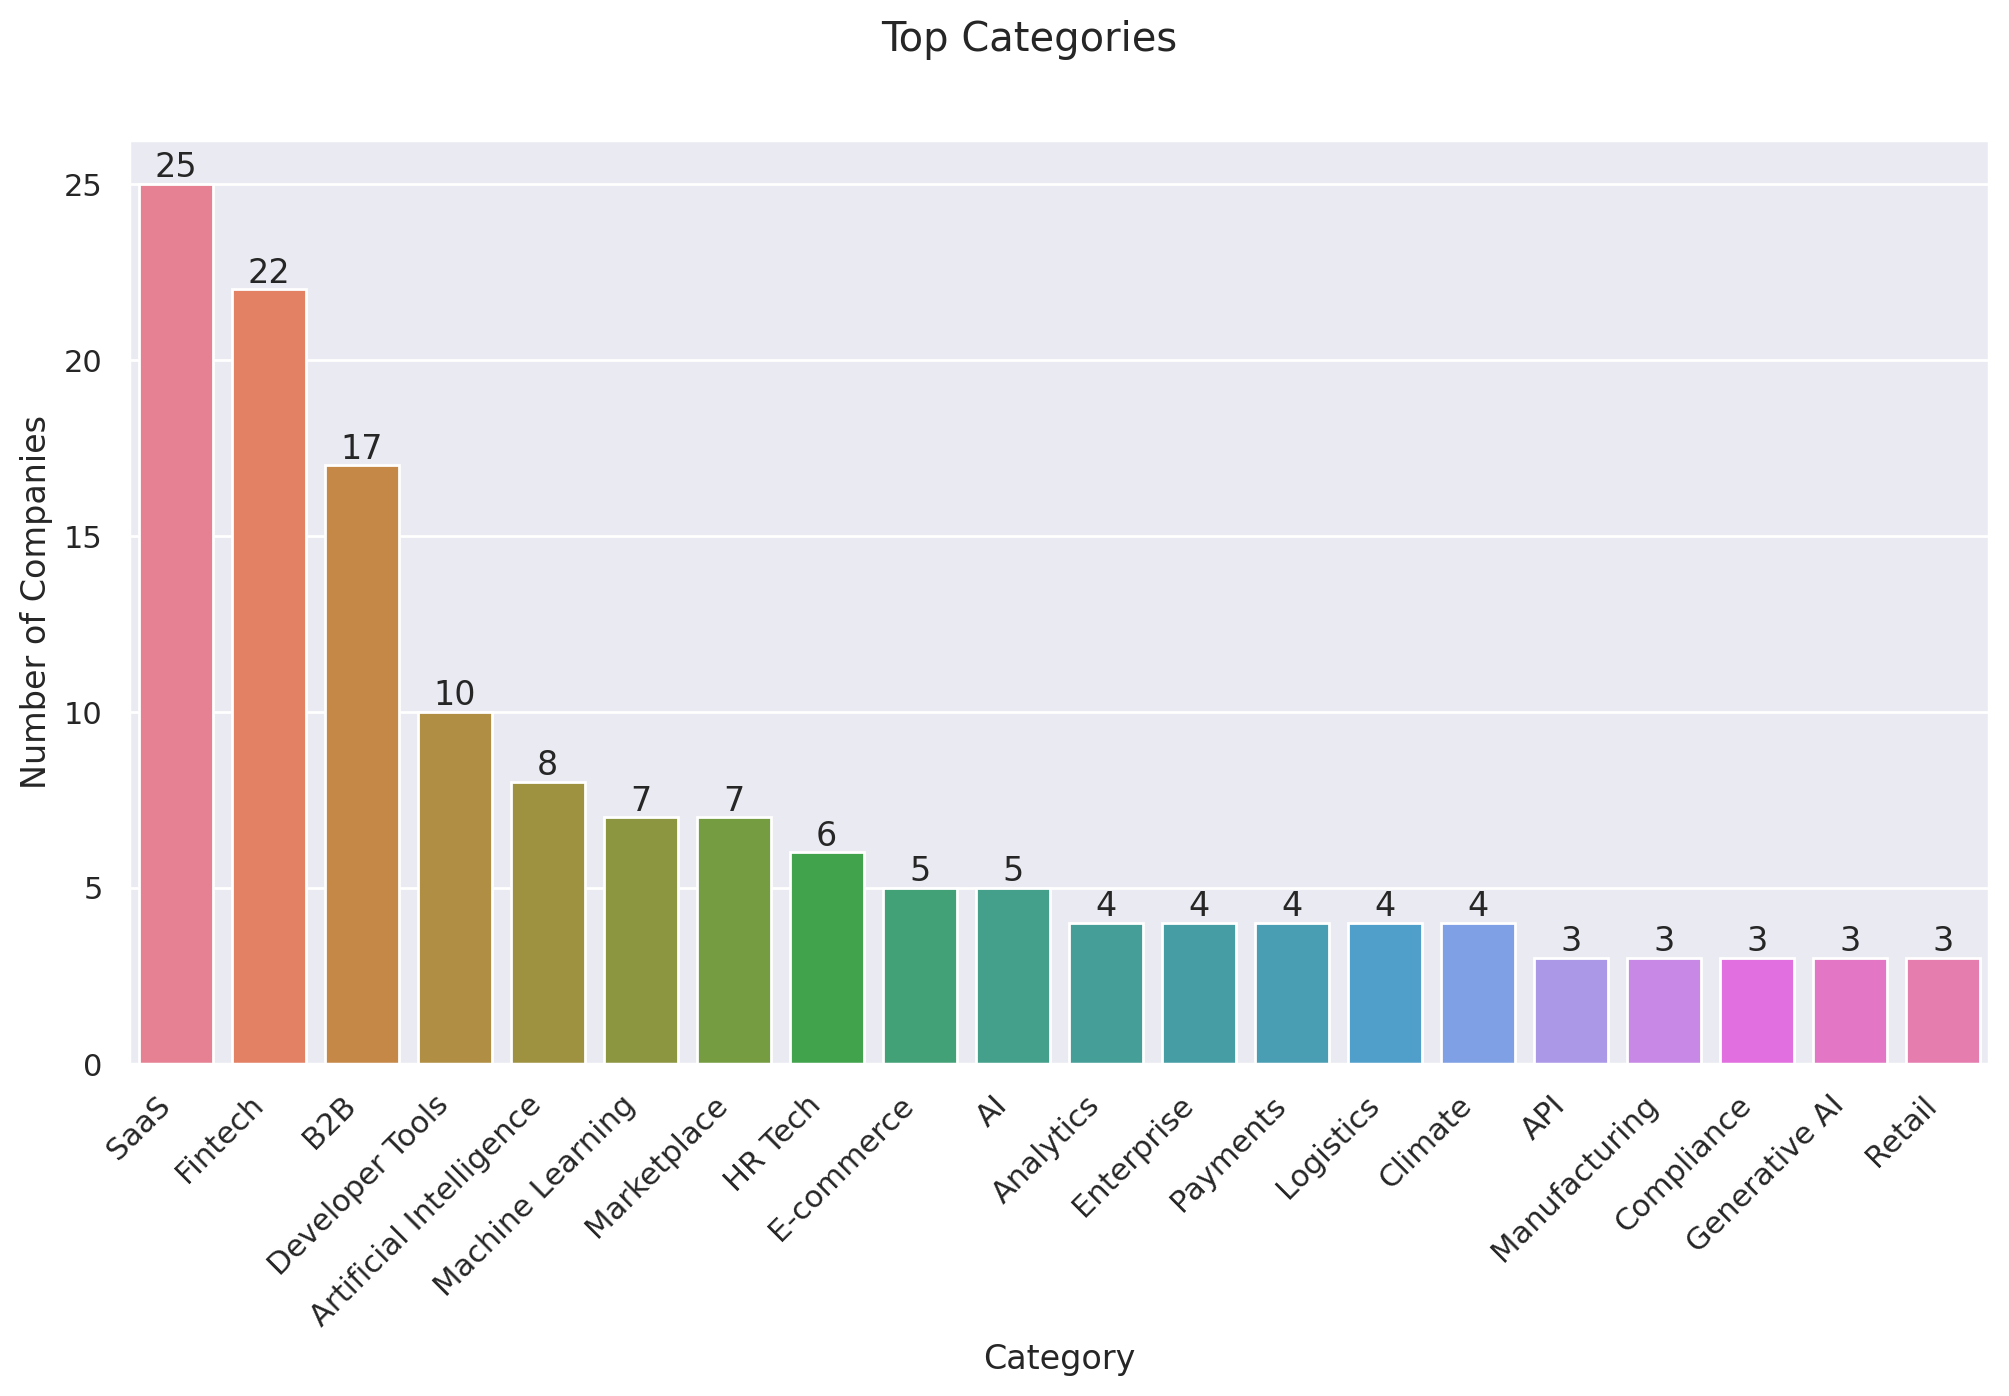

\subsubsection\*{Insights:}

-   **Dominant Category - SaaS:**

    **SaaS (Software as a Service)** leads the chart with **25
    companies**, indicating a strong market demand for
    subscription-based software solutions. This category's popularity
    reflects the growing trend of businesses adopting cloud-based
    services.

-   **Financial Technology (Fintech):**

    **Fintech** follows closely with **22 companies**, showcasing the
    robust growth in financial services technology. The rise of digital
    payment solutions and financial management tools has driven
    significant interest in this sector.

-   **Diverse Categories:**

    Other notable categories include **Developer Tools** (17 companies)
    and **B2B** (10 companies), indicating a healthy ecosystem for tools
    that facilitate business operations and development.

-   **Emerging Technologies:**

    Categories such as **Artificial Intelligence** (9 companies) and
    **Machine Learning** (7 companies) illustrate the increasing focus
    on AI-driven solutions across various industries, reflecting
    investment trends in cutting-edge technology.

-   **E-Commerce and HR Tech:**

    **E-Commerce** and **HR Tech** both have 6 companies, indicating
    ongoing innovation and competition in online retail and human
    resources technology, respectively.

-   **Other Notable Categories:**

    Categories like **Payments**, **Logistics**, and **Clinical** have 4
    companies each, highlighting niche markets that are also attracting
    attention and investment.

-   **Smaller Categories:**

    Categories such as **Analytics**, **Automation**, and **Education**
    have 3 companies each, suggesting that while they are less
    represented, there is still interest in these areas.

\subsubsection\*{Conclusion:}

The chart illustrates a diverse startup ecosystem with a strong emphasis
on SaaS and fintech. The presence of emerging technologies like AI and
machine learning indicates significant innovation potential. Investors
may consider these categories for future opportunities, as they
highlight areas of growth and market demand.

### Team Size Distribution across Different Categories

In [ ]:
_df = df_yc_unicorns.explode('Tags')
_df = _df[_df['Tags'].isin(top_categories['Tags'])]
_df = _df.dropna(subset=['Team Size'])
_df = _df.sort_values(by='Latest Valuation ($B)', ascending=False).head(50)

plt.subplots(figsize=(12,6))
ax = sns.scatterplot(_df, x='Tags', y='Team Size', hue='Company')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set(ylabel='Team Size',
       xlabel='Category')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Team Size Distribution across Different Categories')
plt.show()


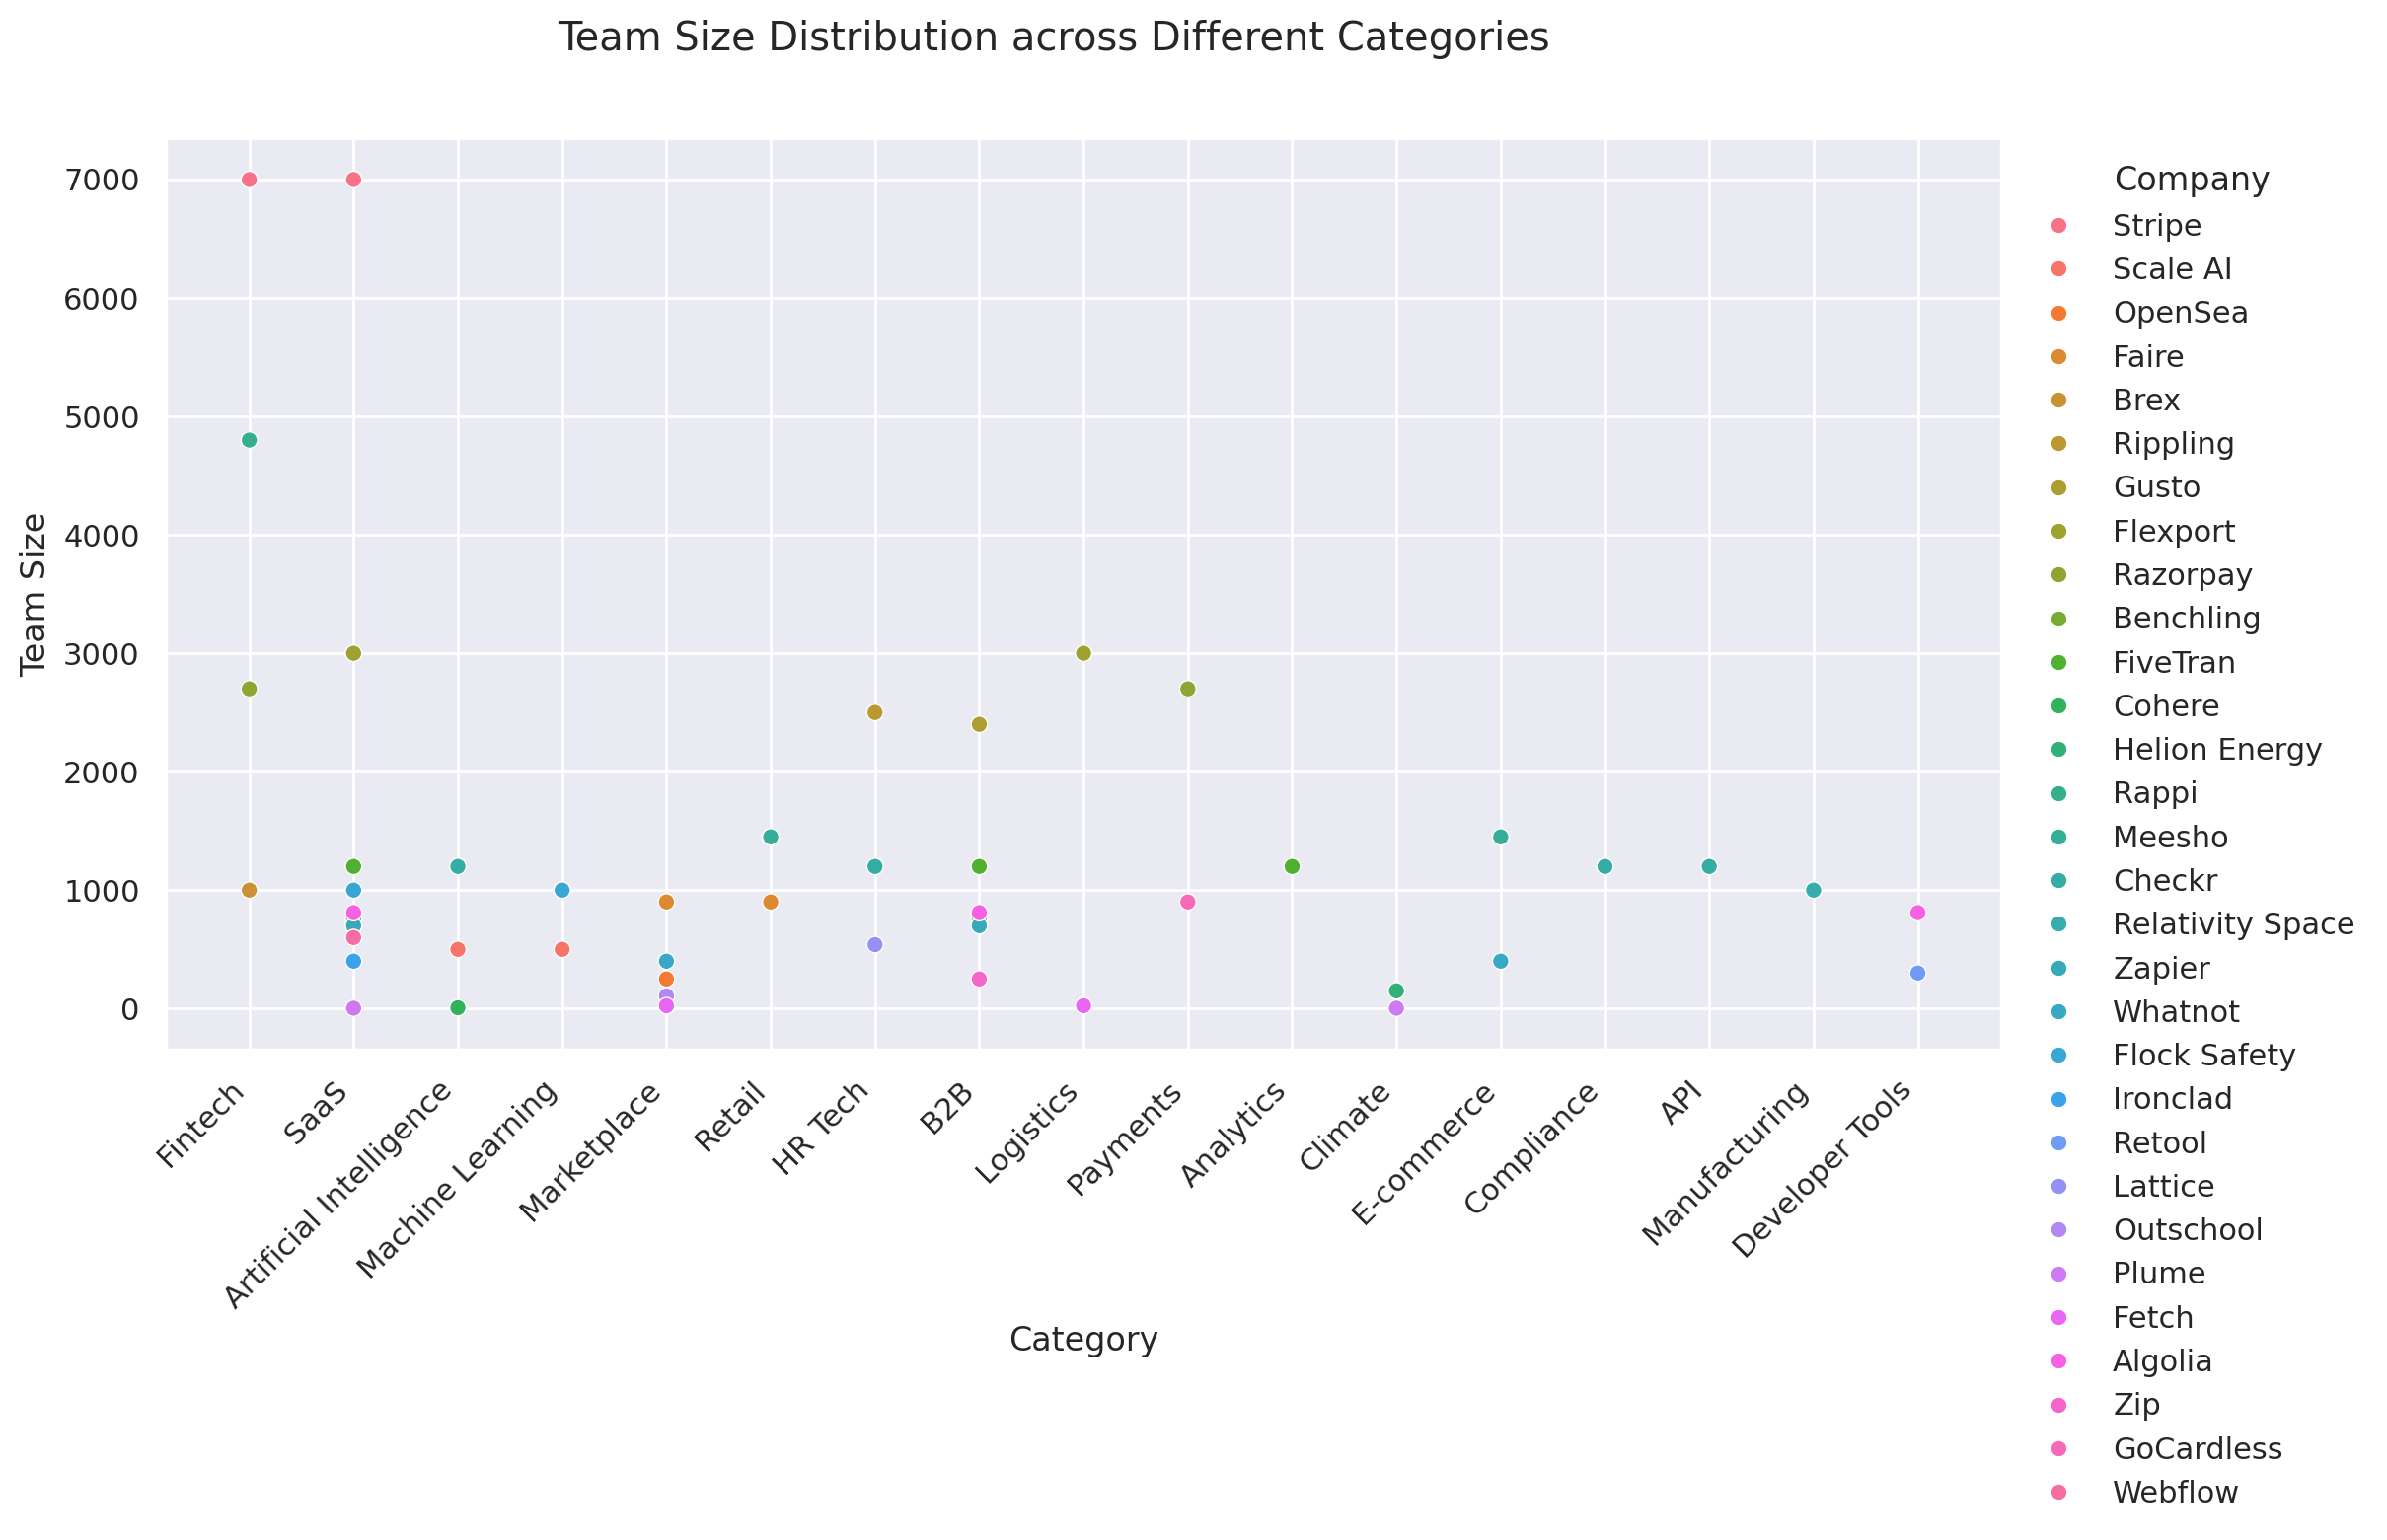

\subsubsection\*{Insights:}

-   **Leading Companies by Team Size:**

    **Stripe** has notably large team sizes, reaching close to 7000
    employees. This suggests a substantial operational scale, likely
    driven by their extensive service offerings and market demand.

-   **Diverse Team Sizes:**

    The chart displays a wide range of team sizes across different
    categories, indicating that companies in the same sector can vary
    significantly in scale. For instance, while some fintech and SaaS
    companies have large teams, others in emerging fields like AI or
    machine learning may operate with smaller teams.

-   **Fintech and SaaS Dominance:**

    Categories like **Fintech** and **SaaS** feature prominently among
    the companies with larger team sizes. This aligns with the need for
    robust support and development teams in sectors that require
    continuous innovation and customer service.

-   **Smaller Companies in Emerging Categories:**

    Companies in categories like **Analytics**, **Education**, and
    **Developer Tools** tend to have smaller team sizes, suggesting they
    may be in earlier stages of growth or focusing on niche markets.

-   **Potential for Growth:**

    The presence of companies with smaller teams in high-potential
    categories (like AI and machine learning) indicates opportunities
    for scaling up as market demand increases. Investors may find these
    companies appealing for future growth prospects.

-   **Industry Variability:**

    The variability in team sizes within categories suggests that
    operational strategies and business models can differ significantly,
    impacting how companies scale and hire.

\subsubsection\*{Conclusion:}

The chart highlights the relationship between team size and industry
category, showing that larger companies are prevalent in established
sectors like fintech and SaaS. In contrast, emerging categories may
still have room for growth. This information can guide investors and
stakeholders in identifying companies with potential for future
expansion and innovation.

# Predictive Analysis

-   **Valuation Predictions:** Use regression models to predict future
    valuations based on funding and industry factors.
-   **Time to Unicorn**: Model the factors influencing the time taken to
    reach unicorn status.

# References

-   \[\[<https://en.wikipedia.org/wiki/Unicorn_(finance)>\]\[Unicorn
    (finance) \[wikipedia\]​\]\]
-   [The YC Startup Directory](https://www.ycombinator.com/companies)